In [1]:
###################### Magic commands

##%%timeit -n 1 -r 1
#%%time
import time
#start = time.time()

###################### at the end

#end = time.time()
#print(end - start)

###################### Packages

import numpy as np
import numpy.random as npr
import pandas as pd
#import Pyarrow # for pandas
import scipy.special
import math 
import numba
import matplotlib.pyplot as plt
from scipy.stats import linregress

# pip install fbm
# from fbm import FBM

###################### Options

npr.seed(0)
import warnings
warnings.filterwarnings('ignore')

#<
#>

############### Tools transfering numpy to numba

@numba.njit(parallel=True, fastmath=False) 
def np_apply_along_axis_2darray(func1d, axis, arr):
  assert arr.ndim == 2
  assert axis in [0, 1]
  if axis == 0:
    result = np.empty(arr.shape[1])
    for i in numba.prange(len(result)):
      result[i] = func1d(arr[:, i])
  else:
    result = np.empty(arr.shape[0])
    for i in numba.prange(len(result)):
      result[i] = func1d(arr[i, :])
  return result

@numba.njit(parallel=True, fastmath=False) 
def np_mean_2darray(array, axis):
  return np_apply_along_axis(np.mean, axis, array)

@numba.njit(parallel=True, fastmath=False) 
def np_std_2darray(array, axis):
  return np_apply_along_axis(np.std, axis, array)

################################################## Non-empty

def check_cond(gamma,c,tau,q):
    if 0<tau:
        if gamma<1 and 0<gamma and 2<q and 0<c and 2*(c+tau)*gamma<1 and q*(1-2*tau*gamma)>2 and q*c*gamma>1 and tau <1/(2*gamma):
            print('Valid!')
        else:
            print('Not valid!')
    else:
        if gamma<1 and 0<gamma and 2<q and 0<c and 2*(c+tau)*gamma<1 and q*c*gamma>1:
            print('Valid!')
        else:
            print('Not valid!')        
    return

def check_cond_no_q(gamma,c,tau):
    if gamma<1 and 0<gamma and 0<c and 2*(c+tau)*gamma<1:
        print('Valid!')
    else:
        print('Not valid!')   
    return

@numba.njit(parallel=True, fastmath=True)
def find_cond_all(h_gamma,h_c,h_tau,h_q,max_c,max_tau,max_q):
    gamma_mesh = np.linspace(0.01,0.99,h_gamma)
    c_mesh = np.linspace(0.1,max_c,h_c)
    tau_mesh = np.linspace(-max_tau,max_tau,h_tau)
    q_mesh = np.linspace(2.1,max_q,h_q)
    for gamma_index in numba.prange(h_gamma):
        for c_index in numba.prange(h_c): 
            for tau_index in numba.prange(h_tau):
                for q_index in numba.prange(h_q):
                    gamma=gamma_mesh[gamma_index]
                    c=c_mesh[c_index]
                    tau=tau_mesh[tau_index]
                    q=q_mesh[q_index]
                    if 0<tau:
                        if 2<q and 0<c and 2*(c+tau)*gamma<1 and q*(1-2*tau*gamma)>2 and q*c*gamma>1:
                            print([gamma, c, tau, q])
                    else:
                        if 2<q and 0<c and 2*(c+tau)*gamma<1 and q*c*gamma>1:
                            print([gamma, c, tau, q])                        
    return 'Done!'

@numba.njit(parallel=True, fastmath=False)
def find_cond_no_q(grid_gamma,max_tau):
    gamma_mesh = np.linspace(0,1,grid_gamma+1)[1:grid_gamma]
    c_mesh = np.arange(1,10)
    tau_mesh = np.arange(-max_tau,max_tau+1)
    for gamma_index in numba.prange(gamma_mesh.shape[0]):
        for c_index in numba.prange(c_mesh.shape[0]): 
            for tau_index in numba.prange(tau_mesh.shape[0]):
                gamma=gamma_mesh[gamma_index]
                c=c_mesh[c_index]
                tau=tau_mesh[tau_index]
                if 2*(c+tau)*gamma<1:
                    print([gamma, c, tau])
    return 'Done!'

@numba.njit(parallel=True, fastmath=False)
def find_gamma_no_q(grid_gamma,c,tau):
    gamma_mesh = np.linspace(0,1,grid_gamma+1)[1:grid_gamma]
    for gamma_index in numba.prange(gamma_mesh.shape[0]):
        gamma=gamma_mesh[gamma_index]
        if 2*(c+tau)*gamma<1:
            print([gamma, c, tau])
    return 'Done!'

@numba.njit(parallel=True, fastmath=False)
def find_cond_c_no_q(c,grid_gamma,max_tau):
    gamma_mesh = np.linspace(0,1,grid_gamma+1)[1:grid_gamma]
    tau_mesh = np.arange(-max_tau,max_tau+1)
    for gamma_index in numba.prange(gamma_mesh.shape[0]):
        for tau_index in numba.prange(tau_mesh.shape[0]):
            gamma=gamma_mesh[gamma_index]
            tau=tau_mesh[tau_index]
            if 2*(c+tau)*gamma<1:
                print([gamma, c, tau])
    return 'Done!'

@numba.njit(parallel=True, fastmath=False)
def find_cond_c_tau_no_q(c,tau,grid_gamma):
    gamma_mesh = np.linspace(0,1,grid_gamma+1)[1:grid_gamma]
    tau_mesh = np.arange(-max_tau,max_tau+1)
    for gamma_index in numba.prange(gamma_mesh.shape[0]):
        for tau_index in numba.prange(tau_mesh.shape[0]):
            gamma=gamma_mesh[gamma_index]
            tau=tau_mesh[tau_index]
            if 2*(c+tau)*gamma<1:
                print([gamma, c, tau])
    return 'Done!'

################################################## Generating Data

@numba.njit(parallel=False, fastmath=False)
def Lomax_quantile_function(x,theta,s):  
    return s*((1-x)**(-1/theta)-1)

@numba.njit(parallel=True, fastmath=False)
def Pareto_quantile_function(x,gamma,s): # support is  {x \ge s} and theta=1/\gamma
    return s*(1-x)**(-gamma)

#The Burr distribution has survival distribution $\bar{F}(y)=(1+y^\rho)^{-\theta} \in 2\RV_{-\theta \rho,-\rho}$ where $x\ge 0$ and $\theta,\rho>0$.
@numba.njit(parallel=True, fastmath=False) # rho,theta positive
def Burr_quantile_function(x,theta,rho): 
    return ((1-x)**(-1/theta)-1)**(1/rho)

@numba.njit(parallel=True, fastmath=False)
def beta_func3(d):
    grid=np.linspace(0,1,d)
    norm=np.sqrt(np.sum(np.exp(-grid**2+grid)**2)/d)
    return np.exp(-grid**2+grid)/norm

@numba.njit(parallel=True, fastmath=False)
def beta_func2(d):
    grid=np.linspace(0,1,d)
    norm=np.sqrt(np.sum(np.exp(-grid)**2)/d)
    return np.exp(-grid)/norm

@numba.njit(parallel=True, fastmath=False)
def beta_func(d):
    grid=np.linspace(0,1,d)
    norm=np.sqrt(np.sum(np.sin(2*np.pi*grid)**2)/d)
    return np.sin(2*np.pi*grid)/norm

@numba.njit(parallel=True, fastmath=False)
def beta_func5(d):
    grid=np.linspace(0,1,d)
    norm=np.sqrt(np.sum(np.sin(1/(1/12+grid**2))/d))
    return np.sin(1/(1/12+grid**2))/norm

@numba.njit(parallel=True, fastmath=False)
def beta_func6(d):
    grid=np.linspace(0,1,d)
    norm=np.sqrt(np.sum(np.cos(2*np.pi*grid+np.sin(1/(grid+1/10)))/d))
    return np.cos(2*np.pi*grid+np.sin(1/(grid+1/10)))/norm

@numba.njit(parallel=True, fastmath=False)
def beta_func7(d):
    grid=np.linspace(0,1,d)
    norm=np.sqrt(np.sum(np.cos(2*np.pi*grid)**2)/d)
    return np.cos(2*np.pi*grid)/norm


@numba.njit(parallel=True, fastmath=False)
def beta_func4(d):
    grid=np.linspace(0,1,d)
    norm=np.sqrt(np.sum(np.sin(2*np.pi*grid)**2)/d)
    return np.sin(2*np.pi*grid)/norm

@numba.njit(parallel=True, fastmath=False)
def coeurjolly_cholesky_fbm_1D(d,H,sigma):
    H2 = 2 * H
    matcov = np.zeros((d-1,d-1))
    for i in numba.prange(d-1):
        for j in numba.prange(i,d-1):
            r = (sigma**2)*(1/2)*(abs(i+1)**H2 + abs(j+1)**H2 - abs(j - i)**H2)
            r = r/(d**H2)
            matcov[i, j] = r
            matcov[j, i] = matcov[i, j]
    L = np.linalg.cholesky(matcov)
    Z = npr.normal(0,1,size=(d - 1))
    fBm = np.dot(L , Z)
    #out=np.concatenate(([0], fBm))
    # out=np.hstack(([0], fBm))
    out= np.asarray([0] + list(fBm))
    return out

# @Article{RePEc:jss:jstsof:v:005:i07,
#  author={Coeurjolly, Jean-Francois},
#  title={{Simulation and identification of the fractional Brownian motion: a bibliographical and comparative study}},
#  journal={Journal of Statistical Software},
#  year=2000,
#  volume={5},
#  number={i07},
#  pages={},
#  month={},
#  keywords={},
#  doi={http://hdl.handle.net/10.18637/jss.v005.i07}
#}

@numba.njit(parallel=True, fastmath=False)
def coeurjolly_cholesky_fbm_array(Z,H,sigma): # Z=npr.normal(0,1,size=(N,n,d - 1))
    N=Z.shape[0]
    n=Z.shape[1]
    d=Z.shape[2]+1
    out = np.zeros((N,n,d))
    for p in numba.prange(N):
        for q in numba.prange(n):    
            H2 = 2 * H
            matcov = np.zeros((d-1,d-1))
            for i in numba.prange(d-1):
                for j in numba.prange(i,d-1):
                    r = (sigma**2)*(1/2)*(abs(i+1)**H2 + abs(j+1)**H2 - abs(j - i)**H2)
                    r = r/(d**H2)
                    matcov[i, j] = r
                    matcov[j, i] = matcov[i, j]
            L = np.linalg.cholesky(matcov)
            fBm = np.dot(L , Z[p,q,:])
            #out=np.concatenate(([0], fBm))
            # out=np.hstack(([0], fBm))
            out[p,q,:]= np.asarray([0] + list(fBm))
    return out

@numba.njit(parallel=True, fastmath=False)
def sigma(u,c,snr): 
    return (u**c)/snr

@numba.njit(parallel=True, fastmath=False)
def noise_mean(d,mu):
    grid=np.linspace(0,1,d)
    return mu*grid

@numba.njit(parallel=True, fastmath=False)
def coeurjolly_cholesky_fbm_var(Y,Z,H,c,snr,mu): #Z = npr.normal(0,1,size=(N,n,d - 1))  
                                     #Y = Pareto_iterated_sample(N,n,theta,s)
    N=Y.shape[0]
    n=Y.shape[1]
    d=Z.shape[2]+1
    out = np.zeros((N,n,d))
    H2 = 2 * H
    matcov = np.zeros((d-1,d-1))
    for p in numba.prange(N):
        for q in numba.prange(n):
            matcov = np.zeros((d-1,d-1))
            for i in numba.prange(d-1):
                for j in numba.prange(i,d-1):
                    r = (sigma(Y[p,q],c,snr)**2)*(1/2)*(abs(i+1)**H2 + abs(j+1)**H2 - abs(j - i)**H2)
                    r = r/(d**H2)
                    matcov[i, j] = r
                    matcov[j, i] = matcov[i, j]
            L = np.linalg.cholesky(matcov)
            fBm = np.dot(L , Z[p,q,:])
            out[p,q,:]= np.asarray([0]+list(fBm)) + noise_mean(d,mu)
    return out

################################################## Estimation

@numba.njit(parallel=True, fastmath=False) 
def esdf(data,x): # Empirical Survival Distribution Function of Y. Here, x.shape = (N,) or (N,n) is the threshold
    # data is Y and data.shape = (N,n)
    N=data.shape[0]
    n=data.shape[1]
    if x.ndim == 1:
        indicator_matrix = np.transpose(np.where(np.transpose(data)>x,1,0)) # binary matrix with same shape as data representating the indicator matrix 1_{X_ij<x_j}
    if x.ndim == 2:
        indicator_matrix = np.where(data>x,1,0)
    return np.sum(indicator_matrix,axis=1)/n # (N,)
    
@numba.njit(parallel=True, fastmath=False)
def threshold_index(X,Y,Y_sort_index,tau,m,start): # 0\le start \le n-1
    N=X.shape[0]
    n=X.shape[1]
    out=np.zeros((N,))
    aux=concomittant_corr(X,Y,Y_sort_index,tau,m)[:,start:]
    return start+np.argmax(aux,axis=1)
    
@numba.njit(parallel=True, fastmath=False)
def threshold(X,Y,Y_sort_index,tau,m,start): # 0\le start \le n-1
    N=X.shape[0]
    n=X.shape[1]
    y_matrix_out = np.zeros((N,n))
    YY=np.copy(Y)
    Y_sort=sort_2d_array(YY)
    index = threshold_index(X,Y,Y_sort_index,tau,m,start)
    for i in numba.prange(N):
        y_matrix_out[i,:] = Y_sort[i,n-index[i]-1]*np.ones((n,))
    return y_matrix_out

@numba.njit(parallel=True, fastmath=False) 
def fepls_weight(Y,y_matrix,nu): # Y of size (N,n)
                             # y_matrix of shape (N,n), for instance y_matrix = y*np.ones((N,n)) where y threshold
                             # nu is such that \psi(x) = x^nu
    N=Y.shape[0]
    n=Y.shape[1]
    out=np.zeros((N,))
    aux = Y**nu # size (N,n) - \psi(Y_i)
    aux2 = np.multiply(aux,np.greater_equal(Y,y_matrix)) # size (N,n) - Product \psi(Y_i)*1_{Y_i \ge y}
    return np.sum(aux2,axis=1)/n # size (N,)

#@numba.njit(parallel=True, fastmath=False) # It seems that "greater_equal" and numba don't work well together
def fepls(X,Y,y_matrix,tau): # X of size (N,n,d) and Y of size (N,n)
                             # y_matrix of shape (N,n), for instance y_matrix = y*np.ones((N,n)) where y threshold
                             # tau is the tail index of \vfi
    N=X.shape[0]
    n=X.shape[1]
    d=X.shape[2]
    out=np.zeros((N,d))
    for j in range(d):
        aux = np.multiply(X[:,:,j],Y**tau) # size (N,n,d) - Product \vfi(Y_i)*X_i
        out2 = np.multiply(aux,np.greater_equal(Y,y_matrix)) # size (N,n) - Product \vfi(Y_i)*X_i*1_{Y_i \ge y}
        out[:,j]= np.sum(out2,axis=1)/n # (N,d)
    norms=np.sqrt(np.sum(out**2,axis=1)/d) # length (N,)
    out2 =  out * (norms.reshape((norms.size, 1)))**(-1)
    return out2 # size (N,d)

@numba.njit(parallel=True, fastmath=False) 
def fepls_numba(X,Y,y_matrix,tau): # X of size (N,n,d) and Y of size (N,n)
                             # y_matrix of shape (N,n), for instance y_matrix = y*np.ones((N,n)) where y threshold
                             # tau is the tail index of \vfi
    N=X.shape[0]
    n=X.shape[1]
    d=X.shape[2]
    out=np.zeros((N,d))
    for j in numba.prange(d):
        aux = np.multiply(X[:,:,j],Y**tau) # size (N,n,d) - Product \vfi(Y_i)*X_i
        out2 = np.multiply(aux,np.greater_equal(Y,y_matrix)) # size (N,n) - Product \vfi(Y_i)*X_i*1_{Y_i \ge y}
        out[:,j]= np.sum(out2,axis=1)/n # (N,d)
    norms=np.sqrt(np.sum(out**2,axis=1)/d) # length (N,)
    out2 =  out * (norms.reshape((norms.size, 1)))**(-1)
    return out2 # size (N,d)

# g(t)= t^c with c \in \{1/4,1/2,1,3/2\} 
# X = g(Y)\beta + \eps

@numba.njit(parallel=True, fastmath=False) 
def Hill(Y,int_seq): # Y of size (N,n), y number, int_seq is an intermediate sequence, ie such that int_seq << n
    N=Y.shape[0]
    n=Y.shape[1]
    Y_ord=np.copy(Y)
    Y_ord=np.sort(Y_ord) 
    Y_2=Y_ord[:,n-int_seq-1]
    aux=Y_ord/Y_2[:, None]
    out=np.log(aux[:,0:n-int_seq])
    return (1/int_seq)*np.sum(out,axis=1) # size (N,)

#### Same as np.sort for 2D arrays but works with numba njit+parallel
@numba.njit(parallel=True, fastmath=False) 
def sort_2d_array(x):
    n,m=np.shape(x)
    for row in numba.prange(n):
        x[row]=np.sort(x[row])
    return x

@numba.njit(parallel=True, fastmath=False) 
def hatbeta_dot_beta(X,Y,tau,l):
    N=X.shape[0]
    n=X.shape[1]
    d=X.shape[2]    
    y_array=np.zeros((N,n,np.arange(int(n/l)).size))
    out=np.zeros((N,np.arange(int(n/l)).size))
    YY=np.copy(Y)
    for p in numba.prange(int(n/l)):
        y_array[:,0,p]=sort_2d_array(YY)[:,n-l*p-1]
        for k in numba.prange(N):
            y_array[k,:,p]=y_array[k,0,p]
        hat_beta=fepls_numba(X,Y,y_array[:,:,p],tau) 
        out[:,p]=(1/d)*np.sum(np.multiply(hat_beta,X[:,p,:]),axis=1) 
    return out

@numba.njit(parallel=True, fastmath=False) 
def concomittant_corr(X,Y,Y_sort_index,tau,m): # 1\le m \le n # Y_sort_index = np.argsort(Y,axis=1)
    N = X.shape[0]
    n = X.shape[1]
    d = X.shape[2]
    out = np.zeros((N,m))
    YY=np.copy(Y)
    Y_sort=sort_2d_array(YY)
    for k in numba.prange(m):
        y_array = np.zeros((N,n,k+1))
        aux = np.zeros((N,k+1))
        aux2 = np.zeros((N,k+1))
        aux3 = Y_sort[:,n-k-1:] # shape (N,k+1)
        aux3_sum = np.sum(aux3,axis=1)
        for i in numba.prange(k):
            y_array[:,0,i] = Y_sort[:,n-i-1]
            for j_2 in numba.prange(N):
                y_array[j_2,:,i] = y_array[j_2,0,i]
            hat_beta = fepls_numba(X,Y,y_array[:,:,i],tau) 
            for j_1 in numba.prange(N):
                i_c = Y_sort_index[j_1,i]
                aux[j_1,i]=(1/d)*np.sum(np.multiply(hat_beta[j_1,:],X[j_1,i_c,:]))
                aux2[j_1,i]= np.multiply(aux[j_1,i],Y_sort[j_1,n-i-1]) 
                out[j_1,k]= np.corrcoef(aux3[j_1,:],aux[j_1,:])[0,1]
    return out
    
def bitcoin_concomittant_corr(X,Y,tau,m): # 1\le m \le n 
    N = X.shape[0]
    n = X.shape[1]
    d = X.shape[2]
    out = np.zeros((m))
    Y_sort=np.sort(Y,axis=1)
    Y_sort_index = np.argsort(Y,axis=1)
    for k in range(m):
        y_array = np.zeros((N,n,k+1))
        aux = np.zeros((k+1))
        aux2 = np.zeros((k+1))
        aux3 = Y_sort[0,n-k-1:] # shape (k+1)
        aux3_sum = np.sum(aux3)
        for i in range(k):
            y_array[:,:,i] = (Y_sort[0,n-i-1])*np.ones((1,n))
            hat_beta = fepls(X,Y,y_array[:,:,i],tau) 
            i_c = Y_sort_index[0,i]
            aux[i]=(1/d)*np.sum(np.multiply(hat_beta[0,:],X[0,i_c,:]))
            aux2[i]= np.multiply(aux[i],Y_sort[0,n-i-1]) 
            out[k]= np.corrcoef(aux3,aux)[0,1]
    return np.abs(out)

@numba.njit(parallel=True, fastmath=False) 
def hatbeta_dot_X(X,hat_beta): # hat_beta=fepls(X,Y,y_matrix,tau) of shape (N,d)
    N=X.shape[0]
    n=X.shape[1]
    d=X.shape[2]    
    out=np.zeros((N,n))
    for i in numba.prange(n):
            out[:,i]=(1/d)*np.sum(np.multiply(hat_beta,X[:,i,:]),axis=1) 
    return out

@numba.njit(parallel=True, fastmath=False) # the same as np.dot(X,beta_func(d))/d (which is preferable)
def beta_dot_X(X):
    N=X.shape[0]
    n=X.shape[1]
    d=X.shape[2]    
    out=np.zeros((N,n))
    for i in numba.prange(n):
            out[:,i]=(1/d)*np.sum(np.multiply(X[:,i,:],beta_func(d)),axis=1) 
    return out
    
@numba.njit(parallel=True, fastmath=False) # np.dot(X,beta_func(d))/d
def beta_dot_X(X,beta_param):
    N=X.shape[0]
    n=X.shape[1]
    d=X.shape[2]    
    out=np.zeros((N,n))
    for i in numba.prange(n):
        if beta_param == 1:
            out[:,i]=(1/d)*np.sum(np.multiply(X[:,i,:],beta_func(d)),axis=1)
        elif beta_param == 2:
            out[:,i]=(1/d)*np.sum(np.multiply(X[:,i,:],beta_func2(d)),axis=1)
        elif beta_param == 3:
            out[:,i]=(1/d)*np.sum(np.multiply(X[:,i,:],beta_func3(d)),axis=1)
        elif beta_param == 4:
            out[:,i]=(1/d)*np.sum(np.multiply(X[:,i,:],beta_func4(d)),axis=1)
    return out
    
@numba.njit(parallel=True, fastmath=False) 
def conditional_cov_Y_hat_beta_X(X,Y,hat_beta,y_matrix,tau): #hat_beta = fepls(X,Y,y_matrix,tau)
    N=X.shape[0]
    n=X.shape[1]
    d=X.shape[2]    
    A=hatbeta_dot_X(X,hat_beta)
    cov_A=np.zeros((N,))
    cov_B=np.zeros((N,))
    for k in numba.prange(N):
        cov_A[k] = (((A[k,:])[Y[k,:]>y_matrix[k,:]])*((Y[k,:])[Y[k,:]>y_matrix[k,:]])).mean() - ((A[k,:])[Y[k,:]>y_matrix[k,:]]).mean()*((Y[k,:])[Y[k,:]>y_matrix[k,:]]).mean()
    return cov_A

#@numba.njit(parallel=True, fastmath=False) # does not work with numba (no idea why)
def conditional_cov_Y_beta_X(X,Y,y):
    N=X.shape[0]
    n=X.shape[1]
    d=X.shape[2]    
    B=beta_dot_X(X)
    cov_B=np.zeros((N,))
    for k in numba.prange(N):
        cov_B[k] = (((B[k,:])[Y[k,:]>y])*((Y[k,:])[Y[k,:]>y])).mean()-((B[k,:])[Y[k,:]>y]).mean()*((Y[k,:])[Y[k,:]>y]).mean()
    return cov_B

def Exponential_QQ_Plot_1D(Y,k):
    n=Y.shape[1]
    out=np.zeros((k))
    out2=np.zeros((k))
    YY=np.sort(Y,axis=1)
    for i in range(k):
        out[i]=np.log((k+1)/(i+1))
        out2[i]=  np.log(YY[0,n-i-1])-np.log(YY[0,-k])
    return np.column_stack((out,out2))

################################################## Conditional quantile estimation (2D+3D array)
################# Application: Bitcoin/SP500 quantile

@numba.njit(parallel=True, fastmath=False) 
def Epanechnikov_kernel_2D(x): # x is a np.array of shape (p,q);     W=np.where(np.abs(x)<=1,1,0)
    out = np.zeros_like(x)
    x=np.asarray(x)
    for i in numba.prange(x.shape[0]):
        for j in numba.prange(x.shape[1]):
            if x[i,j]<=1 and x[i,j]>=0:
                out[i,j] = np.multiply(3/2,1-np.power(x[i,j],2))
            else:
                out[i,j]=0
    return out

@numba.njit(parallel=True, fastmath=False) 
def Epanechnikov_kernel_1D(x): # x is a np.array of shape (p);     W=np.where(np.abs(x)<=1,1,0)
    out = np.zeros_like(x)
    x=np.asarray(x)
    for i in numba.prange(x.shape[0]):
        if x[i]<=1 and x[i]>=0:
            out[i] = np.multiply(3/2,1-np.power(x[i],2))
        else:
            out[i]=0
    return out
    
@numba.njit(parallel=False, fastmath=False) 
def Gaussian_kernel(x):
    return (1/np.sqrt(2*np.pi))*np.exp(-0.5*np.power(x,2))


@numba.njit(parallel=True, fastmath=False) 
def univariate_Nadaraya_weight(X_dimred,x,h,kernel): # X_dimred of shape (N,n) just as Y 
    # e.g., X_dimred = hatbeta_dot_X(X,hat_beta) = F0
    # hat_beta=fepls(X,Y,y_matrix,tau)=E0; x real and h positive
    N=X_dimred.shape[0]
    n=X_dimred.shape[1]
    out=np.zeros((N,n))
    if kernel == 1:
        K_h=Epanechnikov_kernel_2D((X_dimred-x)/h) # shape (N,n)
    if kernel == 2:
        K_h=Gaussian_kernel((X_dimred-x)/h) # shape (N,n)
    return K_h/np.sum(K_h) ### shape = (N,n)

@numba.njit(parallel=True, fastmath=False) 
def plot_quantile_test_2D(X,Y,X_dimred,inner_prod,x_func,alpha,a,b,m,h,h_func,kernel): # X_dimred.shape = Y.shape = (N,n), e.g., X_dimred = hatbeta_dot_X(X,hat_beta) = F0
    # x_func = any vector in H, eg beta_func(d) or E0[0,:]; h_func is positive
    # x_func_dot_beta.shape in \R; it represents the inner product between x_func (where we project for the plot) and the vector in H reducing the dimension
    # inner_prod.shape \in\R represents (x_func,beta)
    #  beta is reducing the dimension, i.e., X_dimred=(X,beta).
    # X_dimred = (X,beta); Y|X_dimred = x vs Y|X=x*x_func  
    out = np.zeros((m,2))
    x_grid = np.linspace(a,b,m)
    for p in numba.prange(m):
        weight_func=functional_Nadaraya_weight_2D(X[0,:,:],x_grid[p]*x_func,h_func,kernel) 
        weight1=univariate_Nadaraya_weight(X_dimred,x_grid[p]*inner_prod,h,kernel)[0,:]  
        out[p,0]=weighted_quantile(Y[0,:],weight1,alpha)
        out[p,1]=weighted_quantile(Y[0,:],weight_func,alpha)
    return out

@numba.njit(parallel=True, fastmath=False) 
def univariate_Nadaraya_weight_2D(X_2D,dimred,x_func,x,h,type,kernel): # X of shape (n,d), Y of shape (n), dimred and x_func of shape (d,)
    # dimred of shape (d,) is e.g. beta_func(d) or (fepls(X,Y,y_matrix,tau))[0,:]
    # Y|(X,dimred)=(x_func,dimred) (type 1) vs Y|(X,dimred) = x (type 2)
    d=x_func.shape[0]
    if type == 1:
        if kernel == 1:
            K_h=Epanechnikov_kernel_1D((np.dot(X_2D,dimred)/d-np.dot(x_func,dimred)/d)/h) # shape (n,)
        if kernel == 2:
            K_h=Gaussian_kernel((np.dot(X_2D,dimred)/d-np.dot(x_func,dimred)/d)/h) # shape (n,)
    if type == 2:     
        if kernel == 1:
            K_h=Epanechnikov_kernel_1D((np.dot(X_2D,dimred)/d-x)/h) # shape (n,)
        if kernel == 2:
            K_h=Gaussian_kernel((np.dot(X_2D,dimred)/d-x)/h) # shape (n,)
    return K_h/np.sum(K_h) ### shape = (,n)

@numba.njit(parallel=True, fastmath=False) 
def functional_Nadaraya_weight_2D(X_2D,x_func,h,kernel): # X.shape = (n,d); h is positive ; x_func \in H ie of shape (d,)
    d=x_func.shape[0]
    aux = (X_2D-x_func*np.ones(d))**2 # shape = (n,d)
    norm = np.sqrt((1/d)*np.sum(aux,axis=1)) # shape = (n,)
    if kernel == 1:
        K_h= Epanechnikov_kernel_1D(norm/h) # shape = (n,)
    if kernel == 2:
        K_h= Gaussian_kernel(norm/h)## shape = (n,)
    return K_h/np.sum(K_h) ### shape = (n,)

@numba.njit(parallel=True, fastmath=False) 
def univariate_Nadaraya_weight_3D(X,dimred_2D,x_func,x,h,type,kernel): # X of shape (N,n,d), Y of shape (N,n), dimred_2D of shape (N,d)
    # x_func of shape (d,) is e.g. beta_func(d) or (fepls(X,Y,y_matrix,tau))[0,:]
    # x is a real number (e.g., x=x_grid[p] for p \leq m)
    # Y|(X,dimred)=(x_func,dimred) (type 1) vs Y|(X,dimred) = x (type 2)
    N=X.shape[0]
    n=X.shape[1]
    d=X.shape[2]
    K_h = np.zeros((N,n))
    for i in numba.prange(N):
        if type == 1:
            if kernel == 1:
                K_h[i,:]=Epanechnikov_kernel_1D((np.dot(X[i,:,:],dimred_2D[i,:])/d-np.dot(x_func,dimred_2D[i,:])/d)/h) # shape (n,)
            if kernel == 2:
                K_h[i,:]=Gaussian_kernel((np.dot(X[i,:,:],dimred_2D[i,:])/d-np.dot(x_func,dimred_2D[i,:])/d)/h) # shape (n,)
        if type == 2:
            if kernel == 1:
                K_h[i,:]=Epanechnikov_kernel_1D((np.dot(X[i,:,:],dimred_2D[i,:])/d-x)/h) # shape (n,)   
            if kernel == 2:
                K_h[i,:]=Gaussian_kernel((np.dot(X[i,:,:],dimred_2D[i,:])/d-x)/h) # shape (n,)
    return np.transpose(np.transpose(K_h)/np.sum(K_h,axis=1)) ### shape = (N,n)

@numba.njit(parallel=True, fastmath=False) 
def functional_Nadaraya_weight_3D(X,x_func,h_func_2D,kernel): # X.shape = (N,n,d); h_func_2D.shape = (N,n); x_func \in H ie of shape (d,)
    N=X.shape[0]
    n=X.shape[1]
    d=X.shape[2]
    aux = np.zeros((N,n,d))
    for i in numba.prange(N):
        aux[i,:,:] = (X[i,:,:]-x_func*np.ones(d))**2
    norm = np.sqrt((1/d)*np.sum(aux,axis=2))
    if kernel == 1:
        K_h= Epanechnikov_kernel_2D(norm/h_func_2D)
    if kernel == 2:
        K_h= Gaussian_kernel(norm/h_func_2D)      
    return np.transpose(np.transpose(K_h)/np.sum(K_h,axis=1)) ### shape = (N,n)

@numba.njit(parallel=True, fastmath=False)   
def weighted_quantile(data,weight,alpha):  # data.shape=weight.shape=(n,) 
    # alpha is the treshold in (0,1)
    sorter = np.argsort(data)
    data = data[sorter]
    weight = weight[sorter]
    weighted_quantiles = np.cumsum(weight) - 0.5 * weight
    weighted_quantiles /= np.sum(weight)
    return np.interp(alpha, weighted_quantiles, data)

@numba.njit(parallel=True, fastmath=False) 
def iterated_weq_2D(data_2D,weight,alpha): # same treshold for all marginals and iterations 
    # data.shape = (N,n); weight.shape=(N,n)
    N=data_2D.shape[0]
    n=data_2D.shape[1]
    out = np.zeros((N,))
    for k in numba.prange(N):
        out[k]=weighted_quantile(data_2D[k,:],weight[k,:],alpha)
    return out # shape = (N)

@numba.njit(parallel=True, fastmath=False) 
def plot_quantile_conditional(X,Y,dimred1,dimred2,x_func,alpha,a,b,m,h_vector,h_func_vector,kernel): 
    # dimred1,2 and x_func of shape (d,), e.g., dimred = E0[0,:] with E0 = fepls(X,Y,y_matrix,tau)
    # x_func = any vector in H, eg beta_func(d) or E0[0,:]
    # h_vector.shape = h_func_vector.shape = (m,)
   # Y|(X,dimred1)=(x*x_func,dimred1) (type 1) vs Y|(X,dimred2) = x (type 2) vs Y|X = x*x_func (type functional)
    out = np.zeros((m,3))
    x_grid = np.linspace(a,b,m)
    for p in numba.prange(m):
        #weight_func=functional_Nadaraya_weight(X,x_grid[p]*x_func,h)[0,:]#functional_Nadaraya_weight_Bitcoin(X,x_grid[p]*x_func,h)
        weight_func=functional_Nadaraya_weight_2D(X[0,:,:],x_grid[p]*x_func,h_func_vector[p],kernel)
        weight1=univariate_Nadaraya_weight_2D(X[0,:,:],dimred1,x_grid[p]*x_func,x_grid[p],h_vector[p],1,kernel)
        weight2=univariate_Nadaraya_weight_2D(X[0,:,:],dimred2,x_grid[p]*x_func,x_grid[p],h_vector[p],2,kernel)
        out[p,0]=weighted_quantile(Y[0,:],weight1,alpha)
        out[p,1]=weighted_quantile(Y[0,:],weight2,alpha)
        out[p,2]=weighted_quantile(Y[0,:],weight_func,alpha)
    return out

@numba.njit(parallel=True, fastmath=False) 
def plot_quantile_conditional_on_sample(X,Y,dimred,alpha,covalues,h_vector,h_func_vector,kernel): 
    # X of shape (N,n,d) and Y of shape (N,n) with N=1;n=...;d=1440
    # covalues=np.dot(X_SPXUSD_BTC,E0_SPXUSD_BTC[0,:])/d   # shape = (N,n) = (1,431) family of (<X_i,dimred>)_{1\le i \le n} avec dimred \in H de taille (d,)=(1440)
    # dimred of shape (d,), e.g., dimred = E0[0,:] with E0 = fepls(X,Y,y_matrix,tau)
    # h_vector.shape = h_func_vector.shape = (n,)
    # Y|(X,dimred) = <x_i,dimred> (type 2) vs Y|X = covalues*dimred (type functional)
    n=Y.shape[1]
    out = np.zeros((n,2))
    for p in numba.prange(n):
        weight2=univariate_Nadaraya_weight_2D(X[0,:,:],dimred,dimred,covalues[0,p],h_vector[p],2,kernel)
        weight_func=functional_Nadaraya_weight_2D(X[0,:,:],covalues[0,p]*dimred,h_func_vector[p],kernel)
        out[p,0]=weighted_quantile(Y[0,:],weight2,alpha)
        out[p,1]=weighted_quantile(Y[0,:],weight_func,alpha)
    return out

@numba.njit(parallel=True, fastmath=False) 
def plot_quantile_conditional_on_sample2(X,Y,dimred,covalues,x_func,alpha,h_vector,h_func_vector,kernel): 
    # X of shape (N,n,d) and Y of shape (N,n) with N=1;n=...;d=1440
    # covalues=np.dot(X_SPXUSD_BTC,E0_SPXUSD_BTC[0,:])/d   # shape = (N,n) = (1,431) family of (<X_i,dimred>)_{1\le i \le n} avec dimred \in H de taille (d,)=(1440)
    # dimred of shape (d,), e.g., dimred = E0[0,:] with E0 = fepls(X,Y,y_matrix,tau)
    # h_vector.shape = h_func_vector.shape = (n,)
    # Functional: X = x_func \in H; Univariate (type 2): <X,dimred>=covalues\in \R with covalues=<X_i,x_func> for 1 \le i \le n.   
    # x_func is a generical function/vector of shape (d,) and dimred is the FEPLS, i.e., E0[0,:] also of shape (d,)
    n=Y.shape[1]
    out = np.zeros((n,2))
    for p in numba.prange(n):
        weight2=univariate_Nadaraya_weight_2D(X[0,:,:],dimred,dimred,covalues[0,p],h_vector[p],2,kernel)
        weight_func=functional_Nadaraya_weight_2D(X[0,:,:],covalues[0,p]*dimred,h_func_vector[p],kernel)
        out[p,0]=weighted_quantile(Y[0,:],weight2,alpha)
        out[p,1]=weighted_quantile(Y[0,:],weight_func,alpha)
    return out


@numba.njit(parallel=True, fastmath=False)
def plot_quantile_covariate_dimred_vs_func_3D(X,Y,dimred1,dimred2,x_func,alpha,a,b,m,h,h_func_2D,kernel): # dimred1,2 of shape (N,d), e.g., dimred = E = fepls(X,Y,y_matrix,tau)
    # x_func = any vector in H, eg beta_func(d) or E0[0,:]
    # h_func_2D.shape = (N,n)
   # Y|(X,dimred1)=(x*x_func,dimred1) (type 1) vs Y|(X,dimred2) = x (type 2) vs Y|X = x*x_func (type functional)
    N=X.shape[0]
    out = np.zeros((N,m,3))
    x_grid = np.linspace(a,b,m)
    for p in numba.prange(m):
        weight_func=functional_Nadaraya_weight_3D(X,x_grid[p]*x_func,h_func_2D,kernel)
        weight1=univariate_Nadaraya_weight_3D(X,dimred1,x_grid[p]*x_func,x_grid[p],h,1,kernel)
        weight2=univariate_Nadaraya_weight_3D(X,dimred2,x_grid[p]*x_func,x_grid[p],h,2,kernel)
        out[:,p,0]=iterated_weq_2D(Y,weight1,alpha)
        out[:,p,1]=iterated_weq_2D(Y,weight2,alpha)
        out[:,p,2]=iterated_weq_2D(Y,weight_func,alpha)
    return out

@numba.njit(parallel=True, fastmath=False) 
def plot_quantile_alpha_dimred_vs_func_3D(X,Y,dimred1,dimred2,x_func,x,a,b,m,h,h_func,type,kernel): # dimred of shape (N,d), e.g., dimred = E = fepls(X,Y,y_matrix,tau)
    # x_func = any vector in H, eg beta_func(d) or E0[0,:]
   # Y|(X,dimred1)=(x*x_func,dimred1) (type 1) vs Y|(X,dimred2) = x (type 2) vs Y|X = x*x_func (type functional)
    N=X.shape[0]
    out = np.zeros((N,m,3))
    alpha_grid = np.linspace(0,1,m)
    for p in range(m):
        weight_func=functional_Nadaraya_weight_3D(X,x_func,h_func,kernel)
        weight1=univariate_Nadaraya_weight_3D(X,dimred1,x_func,x,h,1,kernel)
        weight2=univariate_Nadaraya_weight_3D(X,dimred2,x_func,x,h,2,kernel)
        out[:,p,0]=iterated_weq_2D(Y,weight1,alpha_grid[p])
        out[:,p,1]=iterated_weq_2D(Y,weight1,alpha_grid[p])
        out[:,p,2]=iterated_weq_2D(Y,weight_func,alpha_grid[p])
    return out

################################################## ][ Tail index  

@numba.njit(parallel=True, fastmath=False)
def get_hill_estimator(ordered_data):
    """
    Function to calculate Hill estimator array given an ordered data
    sequence. Decreasing ordering is required; e.g. ordered_data = np.sort(data[0,:])[::-1] where data might be Y (of shape (N,n))
    :param ordered_data: numpy array of ordered data for which the 1st moment (Hill estimator) is calculated.
    :return: numpy array of Hill estimator corresponding to all possible order statistics of the dataset.
    """
    logs = np.log(ordered_data)
    logs_cumsum = np.cumsum(logs[:-1])
    k_vector = np.arange(1, len(ordered_data))
    m1 = (1./k_vector)*logs_cumsum - logs[1:]
    return m1

@numba.njit(parallel=True, fastmath=False)
def get_hill_estimator_2D(ordered_data_2D): # ordered_data_2D = np.sort(-data,axis=1)*-1 with data 2D-array
    """
    Function to calculate Hill estimator array given an ordered data; e.g., ordered_data_2D = np.sort(-Y,axis=1)*-1
    sequence. Decreasing ordering is required; e.g. ordered_data = np.sort(data[0,:])[::-1] where data might be Y (of shape (N,n))
    :param ordered_data: numpy array of ordered data for which the 1st moment (Hill estimator) is calculated.
    :return: numpy array of Hill estimator corresponding to all possible order statistics of the dataset.
    """
    N=ordered_data_2D.shape[0]
    n=ordered_data_2D.shape[1]
    m1=np.zeros((N,n-1))
    for i in numba.prange(N):
        logs = np.log(ordered_data_2D[i,:]) 
        logs_cumsum = np.cumsum(logs[:-1])
        k_vector = np.arange(1, len(ordered_data_2D[i,:]))
        m1[i,:] = (1./k_vector)*logs_cumsum - logs[1:]
    return m1

@numba.njit(parallel=True, fastmath=False)
def Hill_estimator_one_value(ordered_data, k):
    """
    Function to calculate the Hill estimator for a specified order statistic k. Decreasing ordering is required.
    :param ordered_data: Decreasingly ordered sample; e.g. ordered_data = np.sort(data[0,:])[::-1] where data might be Y (of shape (N,n))
    :param k: from 1 up to and including len(ordered_data) - 1
    :return: float with the value of the Hill estimator
    """
    selected_logs = np.log(ordered_data[:k+1])
    return 1./k * sum(selected_logs[:-1]) - selected_logs[-1]

@numba.njit(parallel=True, fastmath=False)
def Hill_estimator_one_value_2D(ordered_data_2D, k): # ordered_data_2D = np.sort(-data,axis=1)*-1 with data 2D-array
    N=ordered_data_2D.shape[0]
    n=ordered_data_2D.shape[1]
    out=np.zeros((N,))
    for i in numba.prange(N):
        selected_logs = np.log(ordered_data_2D[i,:k+1])
        out[i]=1./k * sum(selected_logs[:-1]) - selected_logs[-1]
    return out

@numba.njit(parallel=True, fastmath=False) 
def tail_index_gamma_estimator(data,weight,alpha,J): 
    N=data.shape[0]
    d=data.shape[2]
    subdivision=np.array([(1/s) for s in np.arange(1,J+1)] )
    quantile_data2=iterated_weq(data,weight,alpha) # quantile_data2.shape=(N,d)
    out=np.zeros((N,))
    aux=np.zeros((N,J))
    for k in numba.prange(N):
        for j in numba.prange(J):
            quantile_data1=iterated_weq(data,weight,1-subdivision[j]*(1-alpha))
            aux[k,j] = np.log(quantile_data1[k,0])-np.log(quantile_data2[k,0])
            aux[k,j] /= -np.sum(np.log(subdivision))
        out[k] = np.sum(aux[k,:])
    return out

@numba.njit(parallel=True, fastmath=False) 
def tail_index_gamma_estimator_2D(Y,weight,alpha,J):  # Y.shape= (N,n); weight.shape = (n,)
    subdivision=np.array([(1/s) for s in np.arange(1,J+1)] )
    quantile_data2=weighted_quantile(Y[0,:],weight,alpha) # 
    aux=np.zeros((J))
    for j in numba.prange(J):
        quantile_data1=weighted_quantile(Y[0,:],weight,1-subdivision[j]*(1-alpha))
        aux[j] = np.log(quantile_data1)-np.log(quantile_data2)
        aux[j] /= -np.sum(np.log(subdivision))
    return np.sum(aux)
    
@numba.njit(parallel=True, fastmath=False)  
def plot_tail_index_all_2D(X,Y,dimred1,dimred2,x_func,alpha,a,b,m,h,h_func,J,kernel): # Y.shape = (N,n); X.shape = (N,n,d); Y.shape = (n); x_func.shape = (d,); J=9
    # dimred1.shape = dimred2.shape = (d,)
    # Y|(X,dimred1)=(x*x_func,dimred1) (type 1) vs Y|(X,dimred2) = x (type 2) vs Y|X = x*x_func (type functional)
    x_grid=np.linspace(a,b,m)
    out=np.zeros((m,3))
    for p in numba.prange(m):
        weight1=univariate_Nadaraya_weight_2D(X[0,:,:],dimred1,x_grid[p]*x_func,x_grid[p],h,1,kernel)
        weight2=univariate_Nadaraya_weight_2D(X[0,:,:],dimred2,x_grid[p]*x_func,x_grid[p],h,2,kernel)
        weight_func=functional_Nadaraya_weight_2D(X[0,:,:],x_grid[p]*x_func,h_func,kernel)
        out[p,0]=tail_index_gamma_estimator_2D(Y,weight1,alpha,J)
        out[p,1]=tail_index_gamma_estimator_2D(Y,weight2,alpha,J)
        out[p,2]=tail_index_gamma_estimator_2D(Y,weight_func,alpha,J)
    return out

################################################## ][ Copula 

@numba.njit(parallel=True, fastmath=False) 
def marginal_wecdf(data,weight,x_vect): # x row vector of length d (each marginal has its own treshold)
    # e.g. for uniform treshold t, x_vect=x*np.ones((d,))
    # data.shape = (N,n,d); weight.shape=(N,n)
    N=data.shape[0]
    n=data.shape[1]
    d=data.shape[2]
    out=np.zeros((N,d))
    for k in numba.prange(N):
        for j in numba.prange(d):
            indicator_matrix = np.where(data[:,:,j]<x_vect[j],1,0) # binary matrix with same shape as data representating the indicator matrix 1_{X_ij<x_j}
            out[k,j]= np.sum(np.multiply(indicator_matrix[k,:],weight[k,:]))
    return out/n # (N,d)

@numba.njit(parallel=True, fastmath=False)
def rank(U): # U.shape = (N,n,d)
    R = np.empty_like(U)
    for p in numba.prange(U.shape[0]):
        for j in numba.prange(U.shape[2]):
            R[p,:, j] = np.argsort(np.argsort(U[p,:, j]))+1
    return R

@numba.njit(parallel=True, fastmath=False) 
def weighted_ranked_data(R,weight): # ie: \hat{F}_{j,n,y}(X_ij); R = rank(data) with shape (N,n,d); weight.shape=(N,n)
    N=R.shape[0]
    n=R.shape[1]
    d=R.shape[2]
    out=np.zeros((N,n,d))
    for k in numba.prange(N):
        for i in numba.prange(n):
            for j in numba.prange(d):
                r=np.int32(R[k,i,j])
                out[k,i,j]=np.sum(weight[k,0:r])
    return out/n 

@numba.njit(parallel=True, fastmath=False) 
def bivariate_indicator(data,j,k,x,y): # data.shape = (N,n,d); 1\le j\neq k \le d
    N=data.shape[0]
    n=data.shape[1]
    d=data.shape[2]
    A=np.where(data[:,:,j]<x,1,0)
    B=np.where(data[:,:,k]<y,1,0)
    return np.multiply(A,B) # shape = (N,n)
    
@numba.njit(parallel=True, fastmath=False) 
def bivariate_anti_indicator(data,j,k,x,y): # data.shape = (N,n,d); 1\le j\neq k \le d
    N=data.shape[0]
    n=data.shape[1]
    d=data.shape[2]
    A=np.where(data[:,:,j]<x,0,1)
    B=np.where(data[:,:,k]<y,0,1)
    return np.multiply(A,B) # shape = (N,n)
    
@numba.njit(parallel=True, fastmath=False) 
def bivariate_wecdf(data,weight,j_1,j_2,x,y):
    # data.shape = (N,n,d); weight.shape=(N,n); 1\le j\neq k \le d
    N=data.shape[0]
    n=data.shape[1]
    d=data.shape[2]
    biv_indicator=bivariate_indicator(data,j_1,j_2,x,y)
    return np.sum(np.multiply(biv_indicator,weight),axis=1)/n # shape = (N,)

@numba.njit(parallel=True, fastmath=False) 
def bivariate_ecdf(data,j_1,j_2,x,y):
    # data.shape = (N,n,d); weight.shape=(N,n); 1\le j\neq k \le d
    N=data.shape[0]
    n=data.shape[1]
    d=data.shape[2]
    biv_indicator=bivariate_indicator(data,j_1,j_2,x,y)
    return np.sum((biv_indicator),axis=1)/n # shape = (N,)

@numba.njit(parallel=True, fastmath=False) 
def bivariate_survival_wecdf(data,weight,j_1,j_2,x,y):
    # data.shape = (N,n,d); weight.shape=(N,n); 1\le j\neq k \le d
    N=data.shape[0]
    n=data.shape[1]
    d=data.shape[2]
    biv_indicator=bivariate_anti_indicator(data,j_1,j_2,x,y)
    return np.sum(np.multiply(biv_indicator,weight),axis=1)/n # shape = (N,)

@numba.njit(parallel=True, fastmath=False) 
def empirical_uniform_data(data,weight): 
    N=data.shape[0]
    n=data.shape[1]
    d=data.shape[2]
    out = np.zeros((N,n,d))
    for k in numba.prange(N):
        for i in numba.prange(n):
            out[k,i,:]=marginal_wecdf(data,weight,data[k,i,:])[k,:]
    return out

@numba.njit(parallel=True, fastmath=False) 
def weighted_empirical_copula(data,weight,j_1,j_2,u,v): # u.shape = (2,) in (0,1)
        # data.shape = (N,n,d); weight.shape=(N,n); 1\le j_1\neq j_2 \le d
    N=data.shape[0]
    n=data.shape[1]
    d=data.shape[2]
    out=np.zeros((N,n))
    data=empirical_uniform_data(data,weight)
    biv_indicator=bivariate_indicator(emp_unif_data,j_1,j_2,u,v)
    out= np.multiply(biv_indicator,weight)/n 
    return np.sum(out,axis=1) # return (N)-shape

@numba.njit(parallel=True, fastmath=False) 
def weighted_ranked_empirical_copula(weighted_ranked_data,weight,j_1,j_2,u,v): # u,v in (0,1)
        # weighted_ranked_data=weighted_ranked_data(R.astype(int),weight) where R=rank(data); 
        # weighted_ranked_data.shape = (N,n,d) is ; weight.shape=(N,n); 1\le j_1\neq j_2 \le d
    N=weighted_ranked_data.shape[0]
    n=weighted_ranked_data.shape[1]
    d=weighted_ranked_data.shape[2]
    out=np.zeros((N,n))
    biv_indicator=bivariate_indicator(weighted_ranked_data,j_1,j_2,u,v)
    out= np.multiply(biv_indicator,weight)/n 
    return np.sum(out,axis=1) # return (N)-shape


In [2]:
######################### Real data application: histograms

def hist_weight_extreme_2D(X_2D,Y,Y_sort_index, x_func,x,tau,m,start): # X_2D.shape = (n,d); x in \R; x_func \in H ie of shape (d,)
    d=x_func.shape[0] # Y of shape (N,n) and Y_sort_index = np.argsort(Y,axis=1)
    thresholdd = threshold(np.expand_dims(X_2D,axis=0),Y,Y_sort_index,tau,m,start)
    index_to_remove = np.where(Y<=thresholdd)
    X_extreme_2D=np.delete(X_2D,index_to_remove,axis=0)
    aux = (X_extreme_2D-x*x_func*np.ones(d))**2 # shape = (n2,d)
    out=np.zeros((X_extreme_2D.shape[0],2))
    out[:,0] = np.sqrt((1/d)*np.sum(aux,axis=1)) # shape = (n2,)
    out[:,1]= np.dot(X_extreme_2D,x_func)/d-x
    return out ### shape = (n2,)

def hist_weight_2D(X_2D,Y,Y_sort_index, x_func,x,tau): # X_2D.shape = (n,d); x in \R; x_func \in H ie of shape (d,)
    d=x_func.shape[0] # Y of shape (N,n) and Y_sort_index = np.argsort(Y,axis=1)
    aux = (X_2D-x*x_func*np.ones(d))**2 
    out=np.zeros((X_2D.shape[0],2))
    out[:,0] = np.sqrt((1/d)*np.sum(aux,axis=1)) 
    out[:,1]= np.dot(X_2D,x_func)/d-x
    return out ### shape = (n,)

@numba.njit(parallel=True, fastmath=False)
def hist_weight_extreme_2D_total(X_extreme_2D,x_func,a,b,m): 
    n2=X_extreme_2D.shape[0]
    d=X_extreme_2D.shape[1]
    x_grid = np.linspace(a,b,m)
    out=np.zeros((n2,m,2))
    for p in numba.prange(m):
        aux = (X_extreme_2D-x_grid[p]*x_func*np.ones(d))**2 # shape = (n2,d)
        out[:,p,0] = np.sqrt((1/d)*np.sum(aux,axis=1)) # shape = (n2,)
        out[:,p,1]= np.dot(X_extreme_2D,x_func)/d-x_grid[p]
    return out 

@numba.njit(parallel=True, fastmath=False)
def hist_weight_2D_total(X_2D,x_func,a,b,m): 
    n=X_2D.shape[0]
    d=X_2D.shape[1]
    x_grid = np.linspace(a,b,m)
    out=np.zeros((n,m,2))
    for p in numba.prange(m):
        aux = (X_2D-x_grid[p]*x_func*np.ones(d))**2 # shape = (n,d)
        out[:,p,0] = np.sqrt((1/d)*np.sum(aux,axis=1)) # shape = (n,)
        out[:,p,1]= np.dot(X_2D,x_func)/d-x_grid[p]
    return out

@numba.njit(parallel=True, fastmath=False) 
def mesh_time(X_conc,format): # X_conc = X_conc_SPXUSD for instance in minutes
    n = X_conc.shape[0]
    if format == '12h':
        d2=720
        n2 = int(n/d2)-1
    if format == '24h':
        d2=1440
        n2 = int(n/d2)
    out=np.zeros((n2,d2))
    for i in numba.prange(n2):
        out[i,:] = X_conc[d2*i:d2*(i+1)]
    return out
    
X1_2010_SPXUSD=pd.read_csv('DAT_ASCII_SPXUSD_M1_2010.csv',sep=';',header=None)
X1_2011_SPXUSD=pd.read_csv('DAT_ASCII_SPXUSD_M1_2011.csv',sep=';',header=None)
X1_2012_SPXUSD=pd.read_csv('DAT_ASCII_SPXUSD_M1_2012.csv',sep=';',header=None)
X1_2013_SPXUSD=pd.read_csv('DAT_ASCII_SPXUSD_M1_2013.csv',sep=';',header=None)
X1_2014_SPXUSD=pd.read_csv('DAT_ASCII_SPXUSD_M1_2014.csv',sep=';',header=None)
X1_2015_SPXUSD=pd.read_csv('DAT_ASCII_SPXUSD_M1_2015.csv',sep=';',header=None)
X1_2016_SPXUSD=pd.read_csv('DAT_ASCII_SPXUSD_M1_2016.csv',sep=';',header=None)
X1_2017_SPXUSD=pd.read_csv('DAT_ASCII_SPXUSD_M1_2017.csv',sep=';',header=None)
X1_2018_SPXUSD=pd.read_csv('DAT_ASCII_SPXUSD_M1_2018.csv',sep=';',header=None)

X1_2010_GRXEUR=pd.read_csv('DAT_ASCII_GRXEUR_M1_2010.csv',sep=';',header=None)
X1_2011_GRXEUR=pd.read_csv('DAT_ASCII_GRXEUR_M1_2011.csv',sep=';',header=None)
X1_2012_GRXEUR=pd.read_csv('DAT_ASCII_GRXEUR_M1_2012.csv',sep=';',header=None)
X1_2013_GRXEUR=pd.read_csv('DAT_ASCII_GRXEUR_M1_2013.csv',sep=';',header=None)
X1_2014_GRXEUR=pd.read_csv('DAT_ASCII_GRXEUR_M1_2014.csv',sep=';',header=None)
X1_2015_GRXEUR=pd.read_csv('DAT_ASCII_GRXEUR_M1_2015.csv',sep=';',header=None)
X1_2016_GRXEUR=pd.read_csv('DAT_ASCII_GRXEUR_M1_2016.csv',sep=';',header=None)
X1_2017_GRXEUR=pd.read_csv('DAT_ASCII_GRXEUR_M1_2017.csv',sep=';',header=None)
X1_2018_GRXEUR=pd.read_csv('DAT_ASCII_GRXEUR_M1_2018.csv',sep=';',header=None)

X1_2010_JPXJPY=pd.read_csv('DAT_ASCII_JPXJPY_M1_2010.csv',sep=';',header=None)
X1_2011_JPXJPY=pd.read_csv('DAT_ASCII_JPXJPY_M1_2011.csv',sep=';',header=None)
X1_2012_JPXJPY=pd.read_csv('DAT_ASCII_JPXJPY_M1_2012.csv',sep=';',header=None)
X1_2013_JPXJPY=pd.read_csv('DAT_ASCII_JPXJPY_M1_2013.csv',sep=';',header=None)
X1_2014_JPXJPY=pd.read_csv('DAT_ASCII_JPXJPY_M1_2014.csv',sep=';',header=None)
X1_2015_JPXJPY=pd.read_csv('DAT_ASCII_JPXJPY_M1_2015.csv',sep=';',header=None)
X1_2016_JPXJPY=pd.read_csv('DAT_ASCII_JPXJPY_M1_2016.csv',sep=';',header=None)
X1_2017_JPXJPY=pd.read_csv('DAT_ASCII_JPXJPY_M1_2017.csv',sep=';',header=None)
X1_2018_JPXJPY=pd.read_csv('DAT_ASCII_JPXJPY_M1_2018.csv',sep=';',header=None)

X1_2010_ETXEUR=pd.read_csv('DAT_ASCII_ETXEUR_M1_2010.csv',sep=';',header=None)
X1_2011_ETXEUR=pd.read_csv('DAT_ASCII_ETXEUR_M1_2011.csv',sep=';',header=None)
X1_2012_ETXEUR=pd.read_csv('DAT_ASCII_ETXEUR_M1_2012.csv',sep=';',header=None)
X1_2013_ETXEUR=pd.read_csv('DAT_ASCII_ETXEUR_M1_2013.csv',sep=';',header=None)
X1_2014_ETXEUR=pd.read_csv('DAT_ASCII_ETXEUR_M1_2014.csv',sep=';',header=None)
X1_2015_ETXEUR=pd.read_csv('DAT_ASCII_ETXEUR_M1_2015.csv',sep=';',header=None)
X1_2016_ETXEUR=pd.read_csv('DAT_ASCII_ETXEUR_M1_2016.csv',sep=';',header=None)
X1_2017_ETXEUR=pd.read_csv('DAT_ASCII_ETXEUR_M1_2017.csv',sep=';',header=None)
X1_2018_ETXEUR=pd.read_csv('DAT_ASCII_ETXEUR_M1_2018.csv',sep=';',header=None)

X1_2012_BTC=pd.read_csv('2012.csv')
X1_2013_BTC=pd.read_csv('2013.csv')
X1_2014_BTC=pd.read_csv('2014.csv')
X1_2015_BTC=pd.read_csv('2015.csv')
X1_2016_BTC=pd.read_csv('2016.csv')
X1_2017_BTC=pd.read_csv('2017.csv')
X1_2018_BTC=pd.read_csv('2018.csv')

####################### Change time format to match BTC datasets with SPXUSD/GRXEUR/JP datasets (names of columns and timeformat)

X1_2012_BTC['date'] = pd.to_datetime(X1_2012_BTC['date'])
X1_2012_BTC['date'] = X1_2012_BTC['date'].dt.strftime('%Y%m%d %H%M%S')

X1_2013_BTC['date'] = pd.to_datetime(X1_2013_BTC['date'])
X1_2013_BTC['date'] = X1_2013_BTC['date'].dt.strftime('%Y%m%d %H%M%S')

X1_2014_BTC['date'] = pd.to_datetime(X1_2014_BTC['date'])
X1_2014_BTC['date'] = X1_2014_BTC['date'].dt.strftime('%Y%m%d %H%M%S')

X1_2015_BTC['date'] = pd.to_datetime(X1_2015_BTC['date'])
X1_2015_BTC['date'] = X1_2015_BTC['date'].dt.strftime('%Y%m%d %H%M%S')

X1_2016_BTC['date'] = pd.to_datetime(X1_2016_BTC['date'])
X1_2016_BTC['date'] = X1_2016_BTC['date'].dt.strftime('%Y%m%d %H%M%S')

X1_2017_BTC['date'] = pd.to_datetime(X1_2017_BTC['date'])
X1_2017_BTC['date'] = X1_2017_BTC['date'].dt.strftime('%Y%m%d %H%M%S')

X1_2018_BTC['date'] = pd.to_datetime(X1_2018_BTC['date'])
X1_2018_BTC['date'] = X1_2018_BTC['date'].dt.strftime('%Y%m%d %H%M%S')

##############################################################################

X1_2010_SPXUSD = X1_2010_SPXUSD.rename(columns={ 0 : 'date'})
X1_2011_SPXUSD = X1_2011_SPXUSD.rename(columns={ 0 : 'date'})
X1_2012_SPXUSD = X1_2012_SPXUSD.rename(columns={ 0 : 'date'})
X1_2013_SPXUSD = X1_2013_SPXUSD.rename(columns={ 0 : 'date'})
X1_2014_SPXUSD = X1_2014_SPXUSD.rename(columns={ 0 : 'date'})
X1_2015_SPXUSD = X1_2015_SPXUSD.rename(columns={ 0 : 'date'})
X1_2016_SPXUSD = X1_2016_SPXUSD.rename(columns={ 0 : 'date'})
X1_2017_SPXUSD = X1_2017_SPXUSD.rename(columns={ 0 : 'date'})
X1_2018_SPXUSD = X1_2018_SPXUSD.rename(columns={ 0 : 'date'})

X1_2010_SPXUSD = X1_2010_SPXUSD.rename(columns={ 1 : 'open'})
X1_2011_SPXUSD = X1_2011_SPXUSD.rename(columns={ 1 : 'open'})
X1_2012_SPXUSD = X1_2012_SPXUSD.rename(columns={ 1 : 'open'})
X1_2013_SPXUSD = X1_2013_SPXUSD.rename(columns={ 1 : 'open'})
X1_2014_SPXUSD = X1_2014_SPXUSD.rename(columns={ 1 : 'open'})
X1_2015_SPXUSD = X1_2015_SPXUSD.rename(columns={ 1 : 'open'})
X1_2016_SPXUSD = X1_2016_SPXUSD.rename(columns={ 1 : 'open'})
X1_2017_SPXUSD = X1_2017_SPXUSD.rename(columns={ 1 : 'open'})
X1_2018_SPXUSD = X1_2018_SPXUSD.rename(columns={ 1 : 'open'})

X1_2010_SPXUSD = X1_2010_SPXUSD.rename(columns={ 2 : 'high'})
X1_2011_SPXUSD = X1_2011_SPXUSD.rename(columns={ 2 : 'high'})
X1_2012_SPXUSD = X1_2012_SPXUSD.rename(columns={ 2 : 'high'})
X1_2013_SPXUSD = X1_2013_SPXUSD.rename(columns={ 2 : 'high'})
X1_2014_SPXUSD = X1_2014_SPXUSD.rename(columns={ 2 : 'high'})
X1_2015_SPXUSD = X1_2015_SPXUSD.rename(columns={ 2 : 'high'})
X1_2016_SPXUSD = X1_2016_SPXUSD.rename(columns={ 2 : 'high'})
X1_2017_SPXUSD = X1_2017_SPXUSD.rename(columns={ 2 : 'high'})
X1_2018_SPXUSD = X1_2018_SPXUSD.rename(columns={ 2 : 'high'})

X1_2010_SPXUSD = X1_2010_SPXUSD.rename(columns={ 3 : 'low'})
X1_2011_SPXUSD = X1_2011_SPXUSD.rename(columns={ 3 : 'low'})
X1_2012_SPXUSD = X1_2012_SPXUSD.rename(columns={ 3 : 'low'})
X1_2013_SPXUSD = X1_2013_SPXUSD.rename(columns={ 3 : 'low'})
X1_2014_SPXUSD = X1_2014_SPXUSD.rename(columns={ 3 : 'low'})
X1_2015_SPXUSD = X1_2015_SPXUSD.rename(columns={ 3 : 'low'})
X1_2016_SPXUSD = X1_2016_SPXUSD.rename(columns={ 3 : 'low'})
X1_2017_SPXUSD = X1_2017_SPXUSD.rename(columns={ 3 : 'low'})
X1_2018_SPXUSD = X1_2018_SPXUSD.rename(columns={ 3 : 'low'})

X1_2010_SPXUSD = X1_2010_SPXUSD.rename(columns={ 4 : 'close'})
X1_2011_SPXUSD = X1_2011_SPXUSD.rename(columns={ 4 : 'close'})
X1_2012_SPXUSD = X1_2012_SPXUSD.rename(columns={ 4 : 'close'})
X1_2013_SPXUSD = X1_2013_SPXUSD.rename(columns={ 4 : 'close'})
X1_2014_SPXUSD = X1_2014_SPXUSD.rename(columns={ 4 : 'close'})
X1_2015_SPXUSD = X1_2015_SPXUSD.rename(columns={ 4 : 'close'})
X1_2016_SPXUSD = X1_2016_SPXUSD.rename(columns={ 4 : 'close'})
X1_2017_SPXUSD = X1_2017_SPXUSD.rename(columns={ 4 : 'close'})
X1_2018_SPXUSD = X1_2018_SPXUSD.rename(columns={ 4 : 'close'})

X1_2010_GRXEUR = X1_2010_GRXEUR.rename(columns={ 0 : 'date'})
X1_2011_GRXEUR = X1_2011_GRXEUR.rename(columns={ 0 : 'date'})
X1_2012_GRXEUR = X1_2012_GRXEUR.rename(columns={ 0 : 'date'})
X1_2013_GRXEUR = X1_2013_GRXEUR.rename(columns={ 0 : 'date'})
X1_2014_GRXEUR = X1_2014_GRXEUR.rename(columns={ 0 : 'date'})
X1_2015_GRXEUR = X1_2015_GRXEUR.rename(columns={ 0 : 'date'})
X1_2016_GRXEUR = X1_2016_GRXEUR.rename(columns={ 0 : 'date'})
X1_2017_GRXEUR = X1_2017_GRXEUR.rename(columns={ 0 : 'date'})
X1_2018_GRXEUR = X1_2018_GRXEUR.rename(columns={ 0 : 'date'})

X1_2010_GRXEUR = X1_2010_GRXEUR.rename(columns={ 1 : 'open'})
X1_2011_GRXEUR = X1_2011_GRXEUR.rename(columns={ 1 : 'open'})
X1_2012_GRXEUR = X1_2012_GRXEUR.rename(columns={ 1 : 'open'})
X1_2013_GRXEUR = X1_2013_GRXEUR.rename(columns={ 1 : 'open'})
X1_2014_GRXEUR = X1_2014_GRXEUR.rename(columns={ 1 : 'open'})
X1_2015_GRXEUR = X1_2015_GRXEUR.rename(columns={ 1 : 'open'})
X1_2016_GRXEUR = X1_2016_GRXEUR.rename(columns={ 1 : 'open'})
X1_2017_GRXEUR = X1_2017_GRXEUR.rename(columns={ 1 : 'open'})
X1_2018_GRXEUR = X1_2018_GRXEUR.rename(columns={ 1 : 'open'})

X1_2010_GRXEUR = X1_2010_GRXEUR.rename(columns={ 2 : 'high'})
X1_2011_GRXEUR = X1_2011_GRXEUR.rename(columns={ 2 : 'high'})
X1_2012_GRXEUR = X1_2012_GRXEUR.rename(columns={ 2 : 'high'})
X1_2013_GRXEUR = X1_2013_GRXEUR.rename(columns={ 2 : 'high'})
X1_2014_GRXEUR = X1_2014_GRXEUR.rename(columns={ 2 : 'high'})
X1_2015_GRXEUR = X1_2015_GRXEUR.rename(columns={ 2 : 'high'})
X1_2016_GRXEUR = X1_2016_GRXEUR.rename(columns={ 2 : 'high'})
X1_2017_GRXEUR = X1_2017_GRXEUR.rename(columns={ 2 : 'high'})
X1_2018_GRXEUR = X1_2018_GRXEUR.rename(columns={ 2 : 'high'})

X1_2010_GRXEUR = X1_2010_GRXEUR.rename(columns={ 3 : 'low'})
X1_2011_GRXEUR = X1_2011_GRXEUR.rename(columns={ 3 : 'low'})
X1_2012_GRXEUR = X1_2012_GRXEUR.rename(columns={ 3 : 'low'})
X1_2013_GRXEUR = X1_2013_GRXEUR.rename(columns={ 3 : 'low'})
X1_2014_GRXEUR = X1_2014_GRXEUR.rename(columns={ 3 : 'low'})
X1_2015_GRXEUR = X1_2015_GRXEUR.rename(columns={ 3 : 'low'})
X1_2016_GRXEUR = X1_2016_GRXEUR.rename(columns={ 3 : 'low'})
X1_2017_GRXEUR = X1_2017_GRXEUR.rename(columns={ 3 : 'low'})
X1_2018_GRXEUR = X1_2018_GRXEUR.rename(columns={ 3 : 'low'})

X1_2010_GRXEUR = X1_2010_GRXEUR.rename(columns={ 4 : 'close'})
X1_2011_GRXEUR = X1_2011_GRXEUR.rename(columns={ 4 : 'close'})
X1_2012_GRXEUR = X1_2012_GRXEUR.rename(columns={ 4 : 'close'})
X1_2013_GRXEUR = X1_2013_GRXEUR.rename(columns={ 4 : 'close'})
X1_2014_GRXEUR = X1_2014_GRXEUR.rename(columns={ 4 : 'close'})
X1_2015_GRXEUR = X1_2015_GRXEUR.rename(columns={ 4 : 'close'})
X1_2016_GRXEUR = X1_2016_GRXEUR.rename(columns={ 4 : 'close'})
X1_2017_GRXEUR = X1_2017_GRXEUR.rename(columns={ 4 : 'close'})
X1_2018_GRXEUR = X1_2018_GRXEUR.rename(columns={ 4 : 'close'})

X1_2010_JPXJPY = X1_2010_JPXJPY.rename(columns={ 0 : 'date'})
X1_2011_JPXJPY = X1_2011_JPXJPY.rename(columns={ 0 : 'date'})
X1_2012_JPXJPY = X1_2012_JPXJPY.rename(columns={ 0 : 'date'})
X1_2013_JPXJPY = X1_2013_JPXJPY.rename(columns={ 0 : 'date'})
X1_2014_JPXJPY = X1_2014_JPXJPY.rename(columns={ 0 : 'date'})
X1_2015_JPXJPY = X1_2015_JPXJPY.rename(columns={ 0 : 'date'})
X1_2016_JPXJPY = X1_2016_JPXJPY.rename(columns={ 0 : 'date'})
X1_2017_JPXJPY = X1_2017_JPXJPY.rename(columns={ 0 : 'date'})
X1_2018_JPXJPY = X1_2018_JPXJPY.rename(columns={ 0 : 'date'})

X1_2010_JPXJPY = X1_2010_JPXJPY.rename(columns={ 1 : 'open'})
X1_2011_JPXJPY = X1_2011_JPXJPY.rename(columns={ 1 : 'open'})
X1_2012_JPXJPY = X1_2012_JPXJPY.rename(columns={ 1 : 'open'})
X1_2013_JPXJPY = X1_2013_JPXJPY.rename(columns={ 1 : 'open'})
X1_2014_JPXJPY = X1_2014_JPXJPY.rename(columns={ 1 : 'open'})
X1_2015_JPXJPY = X1_2015_JPXJPY.rename(columns={ 1 : 'open'})
X1_2016_JPXJPY = X1_2016_JPXJPY.rename(columns={ 1 : 'open'})
X1_2017_JPXJPY = X1_2017_JPXJPY.rename(columns={ 1 : 'open'})
X1_2018_JPXJPY = X1_2018_JPXJPY.rename(columns={ 1 : 'open'})

X1_2010_JPXJPY = X1_2010_JPXJPY.rename(columns={ 2 : 'high'})
X1_2011_JPXJPY = X1_2011_JPXJPY.rename(columns={ 2 : 'high'})
X1_2012_JPXJPY = X1_2012_JPXJPY.rename(columns={ 2 : 'high'})
X1_2013_JPXJPY = X1_2013_JPXJPY.rename(columns={ 2 : 'high'})
X1_2014_JPXJPY = X1_2014_JPXJPY.rename(columns={ 2 : 'high'})
X1_2015_JPXJPY = X1_2015_JPXJPY.rename(columns={ 2 : 'high'})
X1_2016_JPXJPY = X1_2016_JPXJPY.rename(columns={ 2 : 'high'})
X1_2017_JPXJPY = X1_2017_JPXJPY.rename(columns={ 2 : 'high'})
X1_2018_JPXJPY = X1_2018_JPXJPY.rename(columns={ 2 : 'high'})

X1_2010_JPXJPY = X1_2010_JPXJPY.rename(columns={ 3 : 'low'})
X1_2011_JPXJPY = X1_2011_JPXJPY.rename(columns={ 3 : 'low'})
X1_2012_JPXJPY = X1_2012_JPXJPY.rename(columns={ 3 : 'low'})
X1_2013_JPXJPY = X1_2013_JPXJPY.rename(columns={ 3 : 'low'})
X1_2014_JPXJPY = X1_2014_JPXJPY.rename(columns={ 3 : 'low'})
X1_2015_JPXJPY = X1_2015_JPXJPY.rename(columns={ 3 : 'low'})
X1_2016_JPXJPY = X1_2016_JPXJPY.rename(columns={ 3 : 'low'})
X1_2017_JPXJPY = X1_2017_JPXJPY.rename(columns={ 3 : 'low'})
X1_2018_JPXJPY = X1_2018_JPXJPY.rename(columns={ 3 : 'low'})

X1_2010_JPXJPY = X1_2010_JPXJPY.rename(columns={ 4 : 'close'})
X1_2011_JPXJPY = X1_2011_JPXJPY.rename(columns={ 4 : 'close'})
X1_2012_JPXJPY = X1_2012_JPXJPY.rename(columns={ 4 : 'close'})
X1_2013_JPXJPY = X1_2013_JPXJPY.rename(columns={ 4 : 'close'})
X1_2014_JPXJPY = X1_2014_JPXJPY.rename(columns={ 4 : 'close'})
X1_2015_JPXJPY = X1_2015_JPXJPY.rename(columns={ 4 : 'close'})
X1_2016_JPXJPY = X1_2016_JPXJPY.rename(columns={ 4 : 'close'})
X1_2017_JPXJPY = X1_2017_JPXJPY.rename(columns={ 4 : 'close'})
X1_2018_JPXJPY = X1_2018_JPXJPY.rename(columns={ 4 : 'close'})

X1_2010_ETXEUR = X1_2010_ETXEUR.rename(columns={ 0 : 'date'})
X1_2011_ETXEUR = X1_2011_ETXEUR.rename(columns={ 0 : 'date'})
X1_2012_ETXEUR = X1_2012_ETXEUR.rename(columns={ 0 : 'date'})
X1_2013_ETXEUR = X1_2013_ETXEUR.rename(columns={ 0 : 'date'})
X1_2014_ETXEUR = X1_2014_ETXEUR.rename(columns={ 0 : 'date'})
X1_2015_ETXEUR = X1_2015_ETXEUR.rename(columns={ 0 : 'date'})
X1_2016_ETXEUR = X1_2016_ETXEUR.rename(columns={ 0 : 'date'})
X1_2017_ETXEUR = X1_2017_ETXEUR.rename(columns={ 0 : 'date'})
X1_2018_ETXEUR = X1_2018_ETXEUR.rename(columns={ 0 : 'date'})

X1_2010_ETXEUR = X1_2010_ETXEUR.rename(columns={ 1 : 'open'})
X1_2011_ETXEUR = X1_2011_ETXEUR.rename(columns={ 1 : 'open'})
X1_2012_ETXEUR = X1_2012_ETXEUR.rename(columns={ 1 : 'open'})
X1_2013_ETXEUR = X1_2013_ETXEUR.rename(columns={ 1 : 'open'})
X1_2014_ETXEUR = X1_2014_ETXEUR.rename(columns={ 1 : 'open'})
X1_2015_ETXEUR = X1_2015_ETXEUR.rename(columns={ 1 : 'open'})
X1_2016_ETXEUR = X1_2016_ETXEUR.rename(columns={ 1 : 'open'})
X1_2017_ETXEUR = X1_2017_ETXEUR.rename(columns={ 1 : 'open'})
X1_2018_ETXEUR = X1_2018_ETXEUR.rename(columns={ 1 : 'open'})

X1_2010_ETXEUR = X1_2010_ETXEUR.rename(columns={ 2 : 'high'})
X1_2011_ETXEUR = X1_2011_ETXEUR.rename(columns={ 2 : 'high'})
X1_2012_ETXEUR = X1_2012_ETXEUR.rename(columns={ 2 : 'high'})
X1_2013_ETXEUR = X1_2013_ETXEUR.rename(columns={ 2 : 'high'})
X1_2014_ETXEUR = X1_2014_ETXEUR.rename(columns={ 2 : 'high'})
X1_2015_ETXEUR = X1_2015_ETXEUR.rename(columns={ 2 : 'high'})
X1_2016_ETXEUR = X1_2016_ETXEUR.rename(columns={ 2 : 'high'})
X1_2017_ETXEUR = X1_2017_ETXEUR.rename(columns={ 2 : 'high'})
X1_2018_ETXEUR = X1_2018_ETXEUR.rename(columns={ 2 : 'high'})

X1_2010_ETXEUR = X1_2010_ETXEUR.rename(columns={ 3 : 'low'})
X1_2011_ETXEUR = X1_2011_ETXEUR.rename(columns={ 3 : 'low'})
X1_2012_ETXEUR = X1_2012_ETXEUR.rename(columns={ 3 : 'low'})
X1_2013_ETXEUR = X1_2013_ETXEUR.rename(columns={ 3 : 'low'})
X1_2014_ETXEUR = X1_2014_ETXEUR.rename(columns={ 3 : 'low'})
X1_2015_ETXEUR = X1_2015_ETXEUR.rename(columns={ 3 : 'low'})
X1_2016_ETXEUR = X1_2016_ETXEUR.rename(columns={ 3 : 'low'})
X1_2017_ETXEUR = X1_2017_ETXEUR.rename(columns={ 3 : 'low'})
X1_2018_ETXEUR = X1_2018_ETXEUR.rename(columns={ 3 : 'low'})

X1_2010_ETXEUR = X1_2010_ETXEUR.rename(columns={ 4 : 'close'})
X1_2011_ETXEUR = X1_2011_ETXEUR.rename(columns={ 4 : 'close'})
X1_2012_ETXEUR = X1_2012_ETXEUR.rename(columns={ 4 : 'close'})
X1_2013_ETXEUR = X1_2013_ETXEUR.rename(columns={ 4 : 'close'})
X1_2014_ETXEUR = X1_2014_ETXEUR.rename(columns={ 4 : 'close'})
X1_2015_ETXEUR = X1_2015_ETXEUR.rename(columns={ 4 : 'close'})
X1_2016_ETXEUR = X1_2016_ETXEUR.rename(columns={ 4 : 'close'})
X1_2017_ETXEUR = X1_2017_ETXEUR.rename(columns={ 4 : 'close'})
X1_2018_ETXEUR = X1_2018_ETXEUR.rename(columns={ 4 : 'close'})


Data size 431


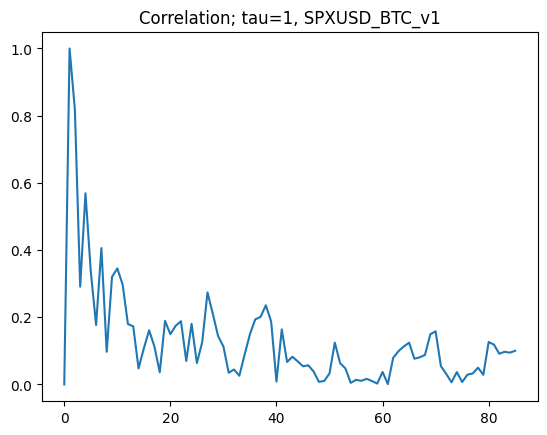

SPXUSD_BTC_v1 - max corr - index: 0.27397649933172735 27


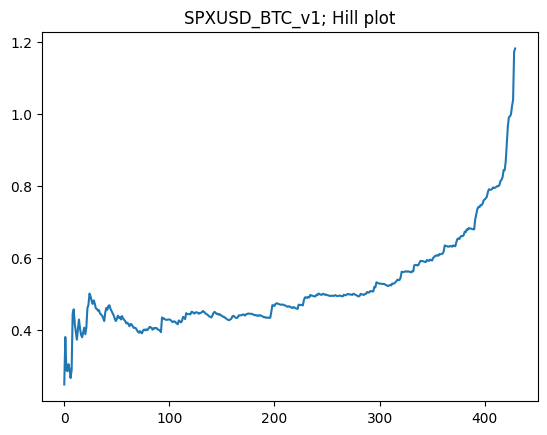

intermediate_seq k_n is 80


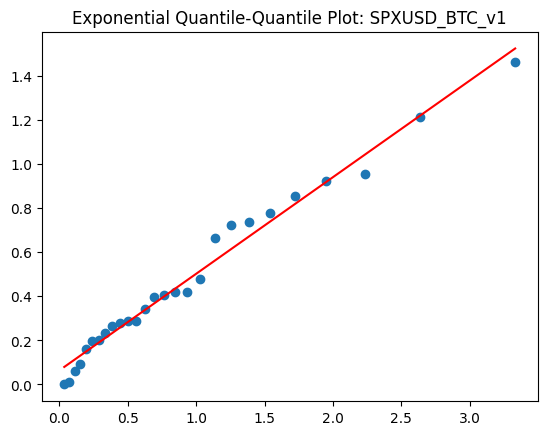

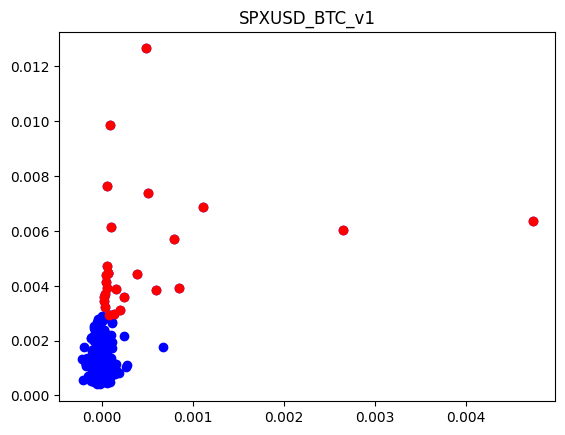

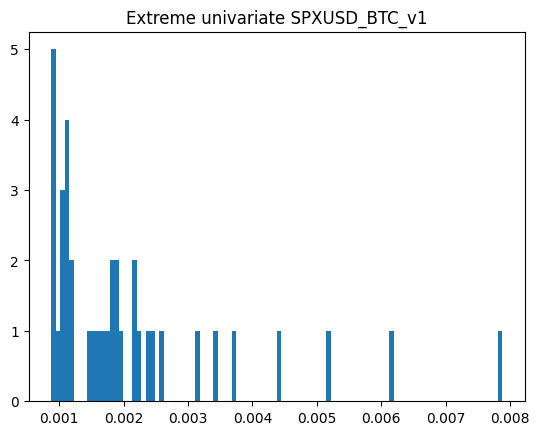

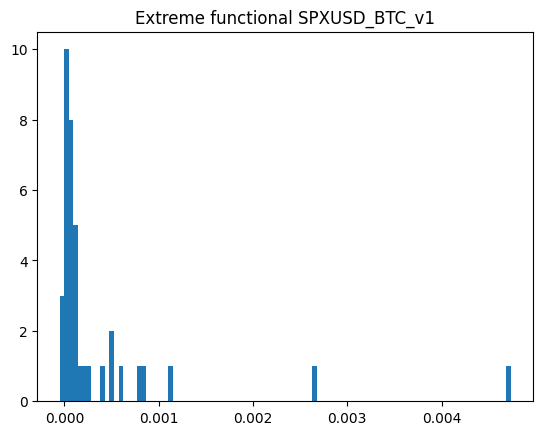

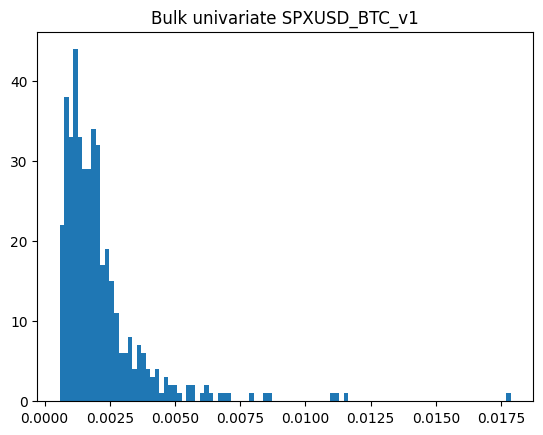

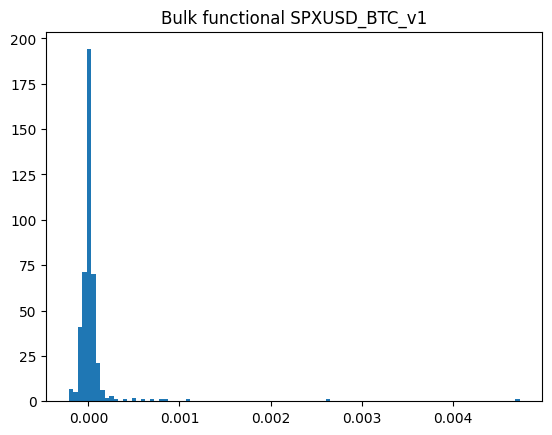

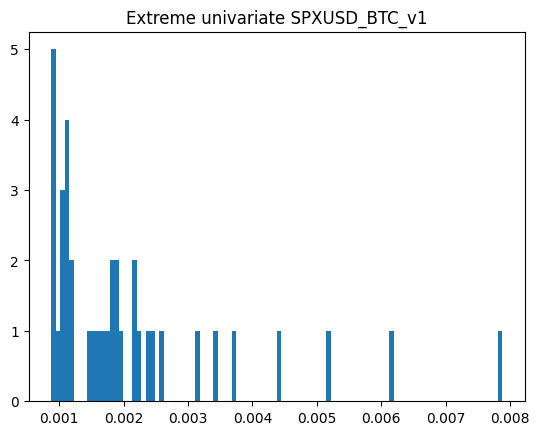

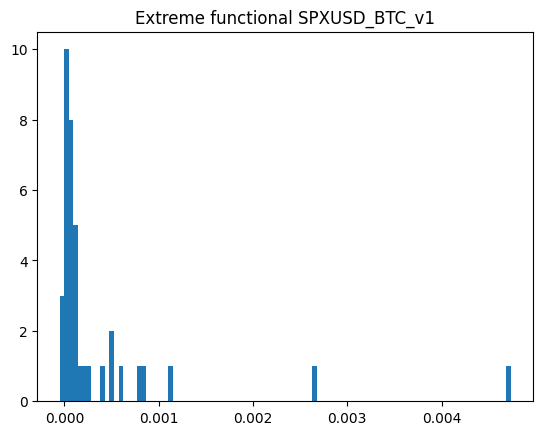

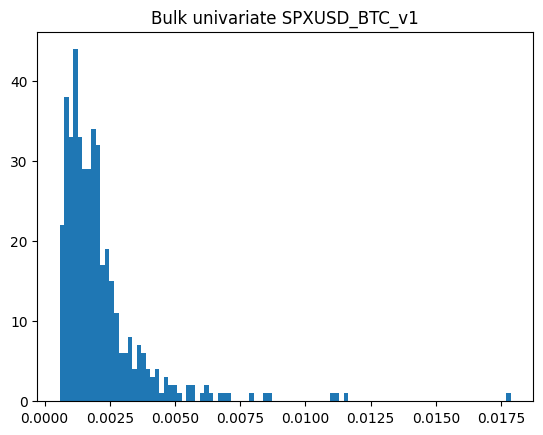

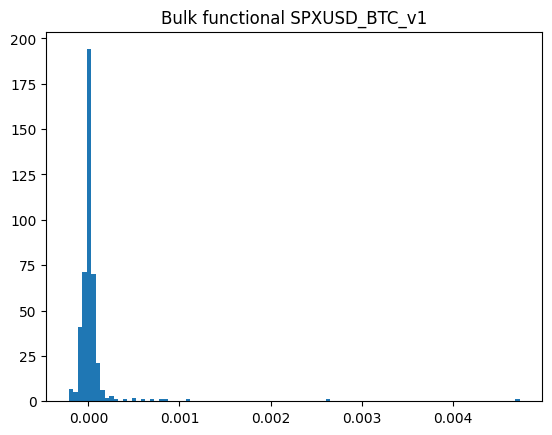

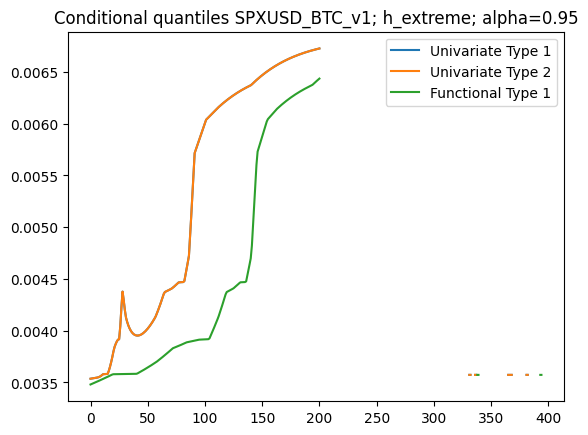

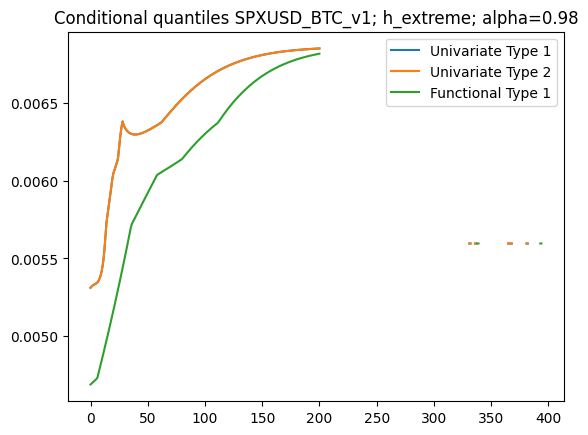

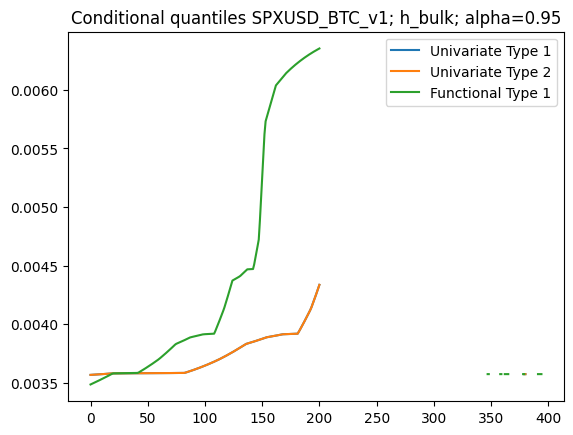

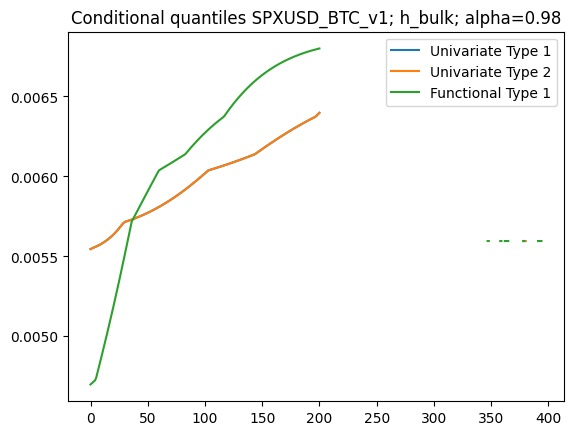

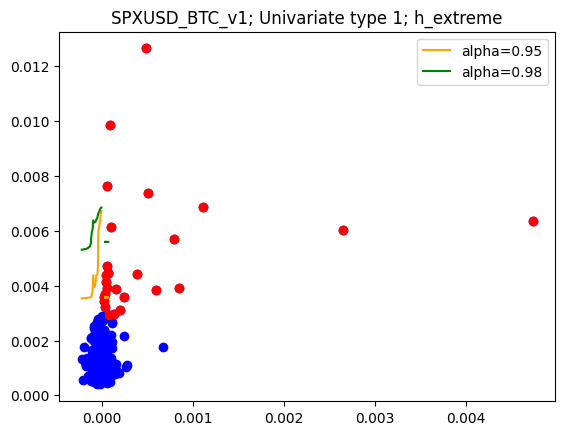

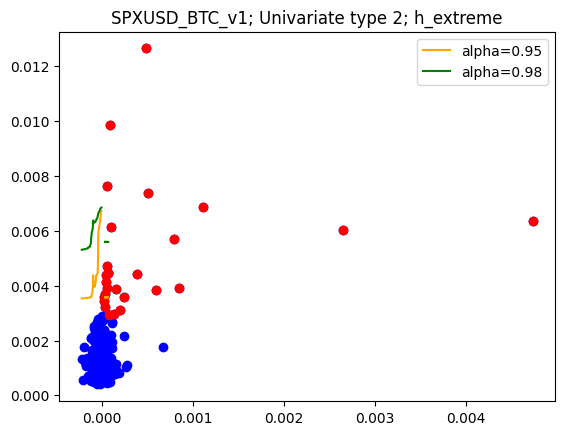

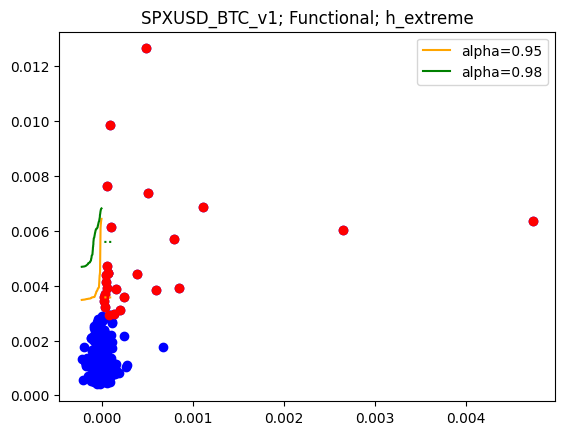

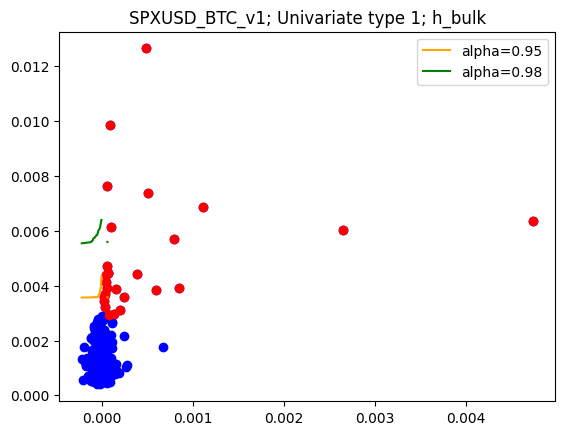

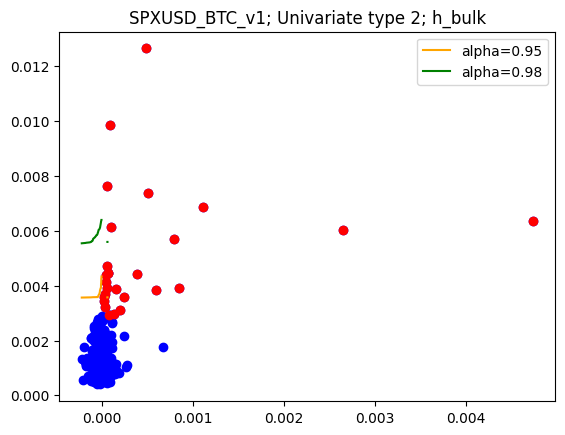

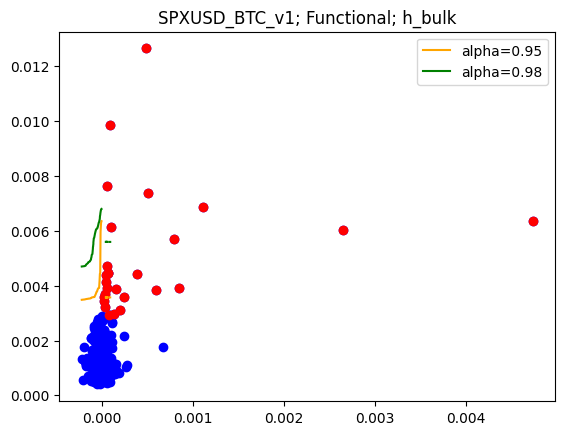

In [3]:

X1_2013_SPXUSD_BTC = pd.merge(X1_2013_SPXUSD, X1_2013_BTC, on='date', how='inner')
X1_2014_SPXUSD_BTC = pd.merge(X1_2014_SPXUSD, X1_2014_BTC, on='date', how='inner')
X1_2015_SPXUSD_BTC = pd.merge(X1_2015_SPXUSD, X1_2015_BTC, on='date', how='inner')
X1_2016_SPXUSD_BTC = pd.merge(X1_2016_SPXUSD, X1_2016_BTC, on='date', how='inner')
X1_2017_SPXUSD_BTC = pd.merge(X1_2017_SPXUSD, X1_2017_BTC, on='date', how='inner')

X_2013_SPXUSD_BTC = ((X1_2013_SPXUSD_BTC.values)[:,[4,9]]).astype(float)
X_2014_SPXUSD_BTC = ((X1_2014_SPXUSD_BTC.values)[:,[4,9]]).astype(float)
X_2015_SPXUSD_BTC = ((X1_2015_SPXUSD_BTC.values)[:,[4,9]]).astype(float)
X_2016_SPXUSD_BTC = ((X1_2016_SPXUSD_BTC.values)[:,[4,9]]).astype(float)
X_2017_SPXUSD_BTC = ((X1_2017_SPXUSD_BTC.values)[:,[4,9]]).astype(float)

X_conc_SPXUSD_BTC =np.append(X_2013_SPXUSD_BTC,X_2014_SPXUSD_BTC,axis=0)
X_conc_SPXUSD_BTC =np.append(X_conc_SPXUSD_BTC,X_2015_SPXUSD_BTC,axis=0)
X_conc_SPXUSD_BTC =np.append(X_conc_SPXUSD_BTC,X_2016_SPXUSD_BTC,axis=0)
X_conc_SPXUSD_BTC =np.append(X_conc_SPXUSD_BTC,X_2017_SPXUSD_BTC,axis=0)

X_conc_SPXUSD=X_conc_SPXUSD_BTC[:,0]
X_conc_BTC=X_conc_SPXUSD_BTC[:,1]

X_logreturn_conc2_SPXUSD=np.diff(np.log(X_conc_SPXUSD)) # shape -1
X_logreturn_conc_SPXUSD = np.append(X_logreturn_conc2_SPXUSD[0],X_logreturn_conc2_SPXUSD) # shape +1

X_logreturn_conc2_BTC=np.diff(np.log(X_conc_BTC)) # shape -1
X_logreturn_conc_BTC = np.append(X_logreturn_conc2_BTC[0],X_logreturn_conc2_BTC) # shape +1

SPXUSD_per_day=mesh_time(X_logreturn_conc_SPXUSD,'24h') # shape = (863, 1440) - 863 days with 1440 minutes recorded 
BTC_per_day=mesh_time(X_logreturn_conc_BTC,'24h') # shape = (863, 1440)

SPXUSD_per_day_even=SPXUSD_per_day[::2,:]
BTC_per_day_even=BTC_per_day[::2,:]
SPXUSD_per_day_odd=SPXUSD_per_day[1::2,:]
BTC_per_day_odd=BTC_per_day[1::2,:]

Y_SPXUSD_BTC = np.max(SPXUSD_per_day_odd,axis=1)
X_SPXUSD_BTC = BTC_per_day_even[:-1,:]

#Y_SPXUSD_BTC = np.max(BTC_per_day_odd,axis=1)
#X_SPXUSD_BTC = SPXUSD_per_day_even[:-1,:]

X_SPXUSD_BTC=np.expand_dims(X_SPXUSD_BTC,axis=0) # shape (N,n,d) with N=1;n=...;1440
Y_SPXUSD_BTC=np.expand_dims(Y_SPXUSD_BTC,axis=0) # shape (N,n,d) with N=1;n=431;1440

index_to_remove1_SPXUSD_BTC = np.argmax(Y_SPXUSD_BTC,axis=1)
Y_SPXUSD_BTC_new1 = np.expand_dims(np.delete(Y_SPXUSD_BTC[0,:],index_to_remove1_SPXUSD_BTC),axis=0)
X_SPXUSD_BTC_new1=np.delete(X_SPXUSD_BTC,index_to_remove1_SPXUSD_BTC,axis=1)
index_to_remove2_SPXUSD_BTC=np.argmax(Y_SPXUSD_BTC_new1,axis=1)
Y_SPXUSD_BTC_reduced=np.expand_dims(np.delete(Y_SPXUSD_BTC_new1,index_to_remove2_SPXUSD_BTC),axis=0)
X_SPXUSD_BTC_reduced=np.delete(X_SPXUSD_BTC_new1,index_to_remove2_SPXUSD_BTC,axis=1)


###################################################
N=X_SPXUSD_BTC.shape[0]
n=X_SPXUSD_BTC.shape[1]
d=X_SPXUSD_BTC.shape[2]

print('Data size', n)
max_threshold_SPXUSD_BTC = int(np.floor(n/5)) # top 20% if n/5, top10% if n/10
min_threshold = 15
tau=1

############################### Correlation and Scatterplot / Choice of threshold \hat k with y_n = Y_{n-\hat k +1,n}
C0_SPXUSD_BTC = bitcoin_concomittant_corr(X_SPXUSD_BTC,Y_SPXUSD_BTC,tau,max_threshold_SPXUSD_BTC)
plt.plot(C0_SPXUSD_BTC)
plt.title('Correlation; tau=1, SPXUSD_BTC_v1')
plt.show()

ind=np.argmax(C0_SPXUSD_BTC[min_threshold:max_threshold_SPXUSD_BTC])+min_threshold 
print('SPXUSD_BTC_v1 - max corr - index:', C0_SPXUSD_BTC[ind], ind)

############### Hill Plot
G_SPXUSD_BTC=get_hill_estimator(np.sort(Y_SPXUSD_BTC[0,:])[::-1])
index_min = 750
plt.plot(G_SPXUSD_BTC[:index_min])
plt.title('SPXUSD_BTC_v1; Hill plot')
plt.show()

####################### Exponential Quantile-Quantile Plot
QQ=Exponential_QQ_Plot_1D(Y_SPXUSD_BTC,ind)
x=QQ[:,0]
y=QQ[:,1]
res=linregress(QQ[:,0],QQ[:,1])
plt.plot(QQ[:,0], QQ[:,1], 'o')
plt.plot(QQ[:,0], res.intercept + res.slope*QQ[:,0], 'r')
plt.title('Exponential Quantile-Quantile Plot: SPXUSD_BTC_v1')
print('intermediate_seq k_n is',80)
plt.show()

################################################################## FEPLS and y_n=Y_{n-\hat k +1,n} with \hat k being "ind" or "ind_reduced"
Y_sort_SPXUSD_BTC=np.sort(Y_SPXUSD_BTC,axis=1)
y_matrix_SPXUSD_BTC = Y_sort_SPXUSD_BTC[0,n-ind-1]*np.ones((N,n))

E0_SPXUSD_BTC=fepls(X_SPXUSD_BTC,Y_SPXUSD_BTC,y_matrix_SPXUSD_BTC,tau)
F0_SPXUSD_BTC=hatbeta_dot_X(X_SPXUSD_BTC,E0_SPXUSD_BTC)

#########################
x=0
a=0
b=0.05
alpha1=0.95
alpha2=0.98
kernel=2 # Gaussian kernel
J=9
N=X_SPXUSD_BTC.shape[0]
n=X_SPXUSD_BTC.shape[1]
d=X_SPXUSD_BTC.shape[2]
max_threshold_SPXUSD_BTC = int(n/5)
min_threshold = 15
s1=1
s2=1

#####################################
X_2D = X_SPXUSD_BTC[0,:,:]
Y_sort_index = np.argsort(Y_SPXUSD_BTC,axis=1)
x_func = E0_SPXUSD_BTC[0,:]
#############################
H_extreme=hist_weight_extreme_2D(X_2D,Y_SPXUSD_BTC,Y_sort_index,x_func,x,tau,max_threshold_SPXUSD_BTC,min_threshold)
thresholdd = threshold(X_SPXUSD_BTC,Y_SPXUSD_BTC,Y_sort_index,tau,max_threshold_SPXUSD_BTC,min_threshold)
index_to_remove = np.where(Y_SPXUSD_BTC<=thresholdd)
X_extreme_2D=np.delete(X_2D,index_to_remove,axis=0)
H_total_extreme=hist_weight_extreme_2D_total(X_extreme_2D,x_func,a,b,1440)
#############################
plt.hist(H_extreme[:,0],bins=100)
plt.title('Extreme univariate SPXUSD_BTC_v1')
plt.show()
plt.hist(H_extreme[:,1],bins=100)
plt.title('Extreme functional SPXUSD_BTC_v1')
plt.show()
#############################
H_bulk=hist_weight_2D(X_2D,Y_SPXUSD_BTC,Y_sort_index,x_func,x,tau)
H_total_bulk=hist_weight_2D_total(X_2D,x_func,a,b,1440)
#############################
plt.hist(H_bulk[:,0],bins=100)
plt.title('Bulk univariate SPXUSD_BTC_v1')
plt.show()
plt.hist(H_bulk[:,1],bins=100)
plt.title('Bulk functional SPXUSD_BTC_v1')
plt.show()

#####################################
X_2D = X_SPXUSD_BTC[0,:,:]
Y_sort_index = np.argsort(Y_SPXUSD_BTC,axis=1)
x_func = E0_SPXUSD_BTC[0,:]

#############################
H_extreme=hist_weight_extreme_2D(X_2D,Y_SPXUSD_BTC,Y_sort_index,x_func,x,tau,max_threshold_SPXUSD_BTC,min_threshold)
thresholdd = threshold(X_SPXUSD_BTC,Y_SPXUSD_BTC,Y_sort_index,tau,max_threshold_SPXUSD_BTC,min_threshold)
index_to_remove = np.where(Y_SPXUSD_BTC<=thresholdd)
X_extreme_2D=np.delete(X_2D,index_to_remove,axis=0)
H_total_extreme=hist_weight_extreme_2D_total(X_extreme_2D,x_func,a,b,201)

#############################
plt.hist(H_extreme[:,0],bins=100)
plt.title('Extreme univariate SPXUSD_BTC_v1')
plt.show()
plt.hist(H_extreme[:,1],bins=100)
plt.title('Extreme functional SPXUSD_BTC_v1')
plt.show()

#############################
H_bulk=hist_weight_2D(X_2D,Y_SPXUSD_BTC,Y_sort_index,x_func,x,tau)
H_total_bulk=hist_weight_2D_total(X_2D,x_func,a,b,201)

#############################
plt.hist(H_bulk[:,0],bins=100)
plt.title('Bulk univariate SPXUSD_BTC_v1')
plt.show()
plt.hist(H_bulk[:,1],bins=100)
plt.title('Bulk functional SPXUSD_BTC_v1')
plt.show()

############################################# Window/Bandwidth choice
h_vector_extreme = (np.max(H_total_extreme[:,:,0],axis=0)-np.min(H_total_extreme[:,:,0],axis=0))/s1
h_func_vector_extreme = (np.max(H_total_extreme[:,:,1],axis=0)-np.min(H_total_extreme[:,:,1],axis=0))/s2
h_extreme=(np.max(H_extreme[:,0],axis=0)-np.min(H_extreme[:,0],axis=0))/s1
h_func_extreme=(np.max(H_extreme[:,1],axis=0)-np.min(H_extreme[:,1],axis=0))/s2
h_func_2D_extreme=np.transpose(np.outer(h_func_extreme*np.ones(n),np.ones(N))) # of shape (N,n) where A.shape = (n,); e.g., A=h_func*np.ones(n)

h_vector_bulk = (np.max(H_total_bulk[:,:,0],axis=0)-np.min(H_total_bulk[:,:,0],axis=0))/s1
h_func_vector_bulk = (np.max(H_total_bulk[:,:,1],axis=0)-np.min(H_total_bulk[:,:,1],axis=0))/s2
h_bulk=(np.max(H_bulk[:,0],axis=0)-np.min(H_bulk[:,0],axis=0))/s1
h_func_bulk=(np.max(H_bulk[:,1],axis=0)-np.min(H_bulk[:,1],axis=0))/s2
h_func_2D_bulk=np.transpose(np.outer(h_func_bulk*np.ones(n),np.ones(N))) # of shape (N,n) where A.shape = (n,); e.g., A=h_func*np.ones(n)

###############################################################################
# Y|(X,dimred1)=(x*x_func,dimred1) (type 1) vs Y|(X,dimred2) = x (type 2) vs Y|X = x*x_func (type functional)
PP11_extreme=plot_quantile_conditional(X_SPXUSD_BTC,Y_SPXUSD_BTC,E0_SPXUSD_BTC[0,:],E0_SPXUSD_BTC[0,:],E0_SPXUSD_BTC[0,:],alpha1,a,b,n,h_vector_extreme,h_func_vector_extreme,kernel) 
PP12_extreme=plot_quantile_conditional(X_SPXUSD_BTC,Y_SPXUSD_BTC,E0_SPXUSD_BTC[0,:],E0_SPXUSD_BTC[0,:],E0_SPXUSD_BTC[0,:],alpha2,a,b,n,h_vector_extreme,h_func_vector_extreme,kernel) 
PP11_bulk=plot_quantile_conditional(X_SPXUSD_BTC,Y_SPXUSD_BTC,E0_SPXUSD_BTC[0,:],E0_SPXUSD_BTC[0,:],E0_SPXUSD_BTC[0,:],alpha1,a,b,n,h_vector_bulk,h_func_vector_bulk,kernel) 
PP12_bulk=plot_quantile_conditional(X_SPXUSD_BTC,Y_SPXUSD_BTC,E0_SPXUSD_BTC[0,:],E0_SPXUSD_BTC[0,:],E0_SPXUSD_BTC[0,:],alpha2,a,b,n,h_vector_bulk,h_func_vector_bulk,kernel) 

plt.plot(PP11_extreme[:,0],label='Univariate Type 1')
plt.plot(PP11_extreme[:,1],label='Univariate Type 2')
plt.plot(PP11_extreme[:,2],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_BTC_v1; h_extreme; alpha=0.95')
plt.show()
plt.plot(PP12_extreme[:,0],label='Univariate Type 1')
plt.plot(PP12_extreme[:,1],label='Univariate Type 2')
plt.plot(PP12_extreme[:,2],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_BTC_v1; h_extreme; alpha=0.98')
plt.show()
plt.plot(PP11_bulk[:,0],label='Univariate Type 1')
plt.plot(PP11_bulk[:,1],label='Univariate Type 2')
plt.plot(PP11_bulk[:,2],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_BTC_v1; h_bulk; alpha=0.95')
plt.show()
plt.plot(PP12_bulk[:,0],label='Univariate Type 1')
plt.plot(PP12_bulk[:,1],label='Univariate Type 2')
plt.plot(PP12_bulk[:,2],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_BTC_v1; h_bulk; alpha=0.98')
plt.show()

###############################################################################
offset1=0
offset2=0

plt.scatter(F0_SPXUSD_BTC[0,:], Y_SPXUSD_BTC[0,:], color='blue', marker='o')
highest_indices_SPXUSD_BTC = np.argsort(Y_SPXUSD_BTC)[0,-bti:]
plt.scatter(F0_SPXUSD_BTC[0,highest_indices_SPXUSD_BTC], Y_SPXUSD_BTC[0,highest_indices_SPXUSD_BTC], color='red')
plt.plot(np.sort(F0_SPXUSD_BTC[0,:])+offset1,  PP11_extreme[:,0], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_BTC[0,:])+offset2,  PP12_extreme[:,0], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_BTC_v1; Univariate type 1; h_extreme')
plt.legend()
#plt.savefig('SPXUSD_BTC_Univariate_type1_h_extreme.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_BTC[0,:], Y_SPXUSD_BTC[0,:], color='blue', marker='o')
highest_indices_SPXUSD_BTC = np.argsort(Y_SPXUSD_BTC)[0,-bti:]
plt.scatter(F0_SPXUSD_BTC[0,highest_indices_SPXUSD_BTC], Y_SPXUSD_BTC[0,highest_indices_SPXUSD_BTC], color='red')
plt.plot(np.sort(F0_SPXUSD_BTC[0,:])+offset1,  PP11_extreme[:,1], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_BTC[0,:])+offset2,  PP12_extreme[:,1], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_BTC_v1; Univariate type 2; h_extreme')
plt.legend()
#plt.savefig('SPXUSD_BTC_Univariate_type2_h_extreme.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_BTC[0,:], Y_SPXUSD_BTC[0,:], color='blue', marker='o')
highest_indices_SPXUSD_BTC = np.argsort(Y_SPXUSD_BTC)[0,-bti:]
plt.scatter(F0_SPXUSD_BTC[0,highest_indices_SPXUSD_BTC], Y_SPXUSD_BTC[0,highest_indices_SPXUSD_BTC], color='red')
plt.plot(np.sort(F0_SPXUSD_BTC[0,:])+offset1,  PP11_extreme[:,2], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_BTC[0,:])+offset2,  PP12_extreme[:,2], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_BTC_v1; Functional; h_extreme')
plt.legend()
#plt.savefig('SPXUSD_BTC_Functional_h_extreme.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_BTC[0,:], Y_SPXUSD_BTC[0,:], color='blue', marker='o')
highest_indices_SPXUSD_BTC = np.argsort(Y_SPXUSD_BTC)[0,-bti:]
plt.scatter(F0_SPXUSD_BTC[0,highest_indices_SPXUSD_BTC], Y_SPXUSD_BTC[0,highest_indices_SPXUSD_BTC], color='red')
plt.plot(np.sort(F0_SPXUSD_BTC[0,:])+offset1,  PP11_bulk[:,0], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_BTC[0,:])+offset2,  PP12_bulk[:,0], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_BTC_v1; Univariate type 1; h_bulk')
plt.legend()
#plt.savefig('SPXUSD_BTC_Univariate_type1_h_bulk.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_BTC[0,:], Y_SPXUSD_BTC[0,:], color='blue', marker='o')
highest_indices_SPXUSD_BTC = np.argsort(Y_SPXUSD_BTC)[0,-bti:]
plt.scatter(F0_SPXUSD_BTC[0,highest_indices_SPXUSD_BTC], Y_SPXUSD_BTC[0,highest_indices_SPXUSD_BTC], color='red')
plt.plot(np.sort(F0_SPXUSD_BTC[0,:])+offset1,  PP11_bulk[:,1], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_BTC[0,:])+offset2,  PP12_bulk[:,1], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_BTC_v1; Univariate type 2; h_bulk')
plt.legend()
#plt.savefig('SPXUSD_BTC_Univariate_type2_h_bulk.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_BTC[0,:], Y_SPXUSD_BTC[0,:], color='blue', marker='o')
highest_indices_SPXUSD_BTC = np.argsort(Y_SPXUSD_BTC)[0,-bti:]
plt.scatter(F0_SPXUSD_BTC[0,highest_indices_SPXUSD_BTC], Y_SPXUSD_BTC[0,highest_indices_SPXUSD_BTC], color='red')
plt.plot(np.sort(F0_SPXUSD_BTC[0,:])+offset1,  PP11_bulk[:,2], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_BTC[0,:])+offset2,  PP12_bulk[:,2], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_BTC_v1; Functional; h_bulk')
plt.legend()
#plt.savefig('SPXUSD_BTC_Functional_h_bulk.pdf')  
plt.show()


The bandwidth h for the following plots is 0.004


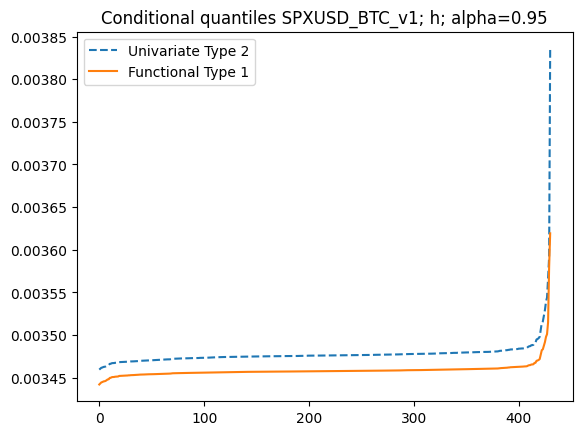

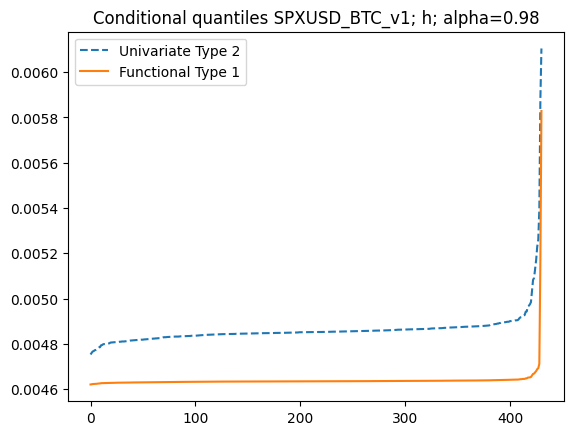

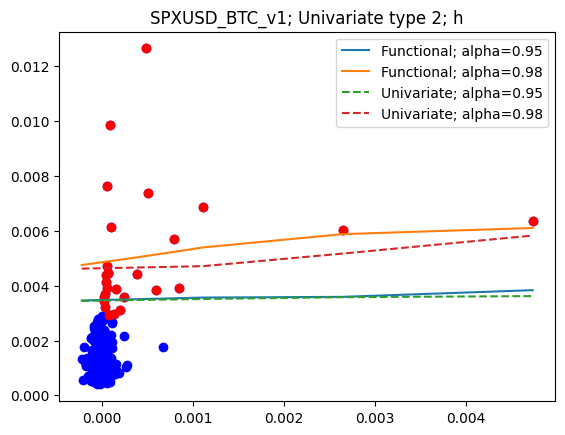

In [5]:
@numba.njit(parallel=True, fastmath=False) 
def plot_quantile_conditional_on_sample2(X,Y,dimred,covalues,x_func,alpha,h_vector,h_func_vector,kernel): 
    # X of shape (N,n,d) and Y of shape (N,n) with N=1;n=...;d=1440
    # covalues=np.dot(X_SPXUSD_BTC,E0_SPXUSD_BTC[0,:])/d   # shape = (N,n) = (1,431) family of (<X_i,dimred>)_{1\le i \le n} avec dimred \in H de taille (d,)=(1440)
    # dimred of shape (d,), e.g., dimred = E0[0,:] with E0 = fepls(X,Y,y_matrix,tau)
    # h_vector.shape = h_func_vector.shape = (n,)
    # Functional: X = x_func \in H; Univariate (type 2): <X,dimred>=covalues\in \R with covalues=<X_i,x_func> for 1 \le i \le n.   
    # x_func is a generical function/vector of shape (d,) and dimred is the FEPLS, i.e., E0[0,:] also of shape (d,)
    n=Y.shape[1]
    out = np.zeros((n,2))
    for p in numba.prange(n):
        weight2=univariate_Nadaraya_weight_2D(X[0,:,:],dimred,dimred,covalues[0,p],h_vector[p],2,kernel)
        weight_func=functional_Nadaraya_weight_2D(X[0,:,:],covalues[0,p]*dimred,h_func_vector[p],kernel)
        out[p,0]=weighted_quantile(Y[0,:],weight2,alpha)
        out[p,1]=weighted_quantile(Y[0,:],weight_func,alpha)
    return out

#########################

alpha1=0.95
alpha2=0.98
kernel=2 # Gaussian kernel
J=9

N=X_SPXUSD_BTC.shape[0]
n=X_SPXUSD_BTC.shape[1]
d=X_SPXUSD_BTC.shape[2]

##############################################################################
# Y|(X,dimred) = covalues (type univariate) vs Y|X = x_func (type functional)

dimred = E0_SPXUSD_BTC[0,:] # of shape (d,)
x_func = E0_SPXUSD_BTC[0,:] # of shape (d,)
covalues = np.sort(np.dot(X_SPXUSD_BTC,x_func)/d,axis=1)

##############################################################

H_grid=[0.004] #np.linspace(0.0002,0.004,51)

for h in H_grid:
    h_vector = h*np.ones((n,))
    h_func_vector = h*np.ones((n,))
    
    PP11_sample=plot_quantile_conditional_on_sample2(X_SPXUSD_BTC,Y_SPXUSD_BTC,dimred,covalues,x_func,alpha1,h_vector,h_func_vector,kernel) 
    PP12_sample=plot_quantile_conditional_on_sample2(X_SPXUSD_BTC,Y_SPXUSD_BTC,dimred,covalues,x_func,alpha2,h_vector,h_func_vector,kernel)
    print('The bandwidth h for the following plots is',h) 
    plt.plot(PP11_sample[:,0], linestyle='dashed', label='Univariate Type 2')
    plt.plot(PP11_sample[:,1], label='Functional Type 1')
    plt.legend()
    plt.title('Conditional quantiles SPXUSD_BTC_v1; h; alpha=0.95')
    plt.show()
    plt.plot(PP12_sample[:,0], linestyle='dashed', label='Univariate Type 2')
    plt.plot(PP12_sample[:,1],label='Functional Type 1')
    plt.legend()
    plt.title('Conditional quantiles SPXUSD_BTC_v1; h; alpha=0.98')
    plt.show()
    ###########################################################
    offset1=0
    offset2=0
    plt.scatter(F0_SPXUSD_BTC[0,:], Y_SPXUSD_BTC[0,:], color='blue', marker='o')
    highest_indices_SPXUSD_BTC = np.argsort(Y_SPXUSD_BTC)[0,-bti:]
    plt.scatter(F0_SPXUSD_BTC[0,highest_indices_SPXUSD_BTC], Y_SPXUSD_BTC[0,highest_indices_SPXUSD_BTC], color='red')
    plt.plot(np.sort(F0_SPXUSD_BTC[0,:])+offset1,  PP11_sample[:,1],  label='Functional; alpha=0.95')
    plt.plot(np.sort(F0_SPXUSD_BTC[0,:])+offset2,  PP12_sample[:,1],  label='Functional; alpha=0.98')
    plt.plot(np.sort(F0_SPXUSD_BTC[0,:])+offset1,  PP11_sample[:,0],  linestyle='dashed',label='Univariate; alpha=0.95')
    plt.plot(np.sort(F0_SPXUSD_BTC[0,:])+offset2,  PP12_sample[:,0],  linestyle='dashed',label='Univariate; alpha=0.98')
    #plt.xlim(-0.02, 0.03) 
    #plt.ylim(-0.01, 0.22) 
    plt.title('SPXUSD_BTC_v1')
    plt.legend()
    #plt.savefig('SPXUSD_BTC_Univariate_type2_h.pdf')  
    plt.show()



Data size 241


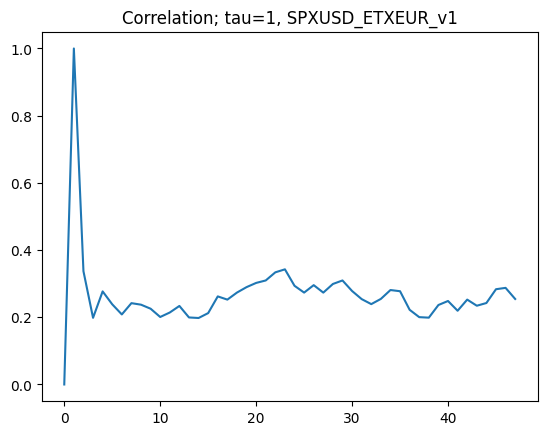

SPXUSD_ETXEUR_v1 - max corr - index: 0.34269865138117306 23


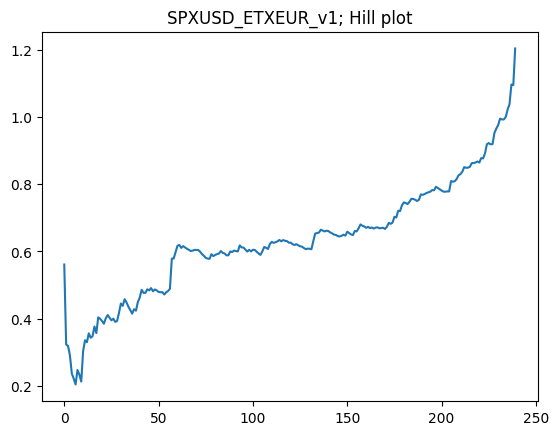

intermediate_seq k_n is 80


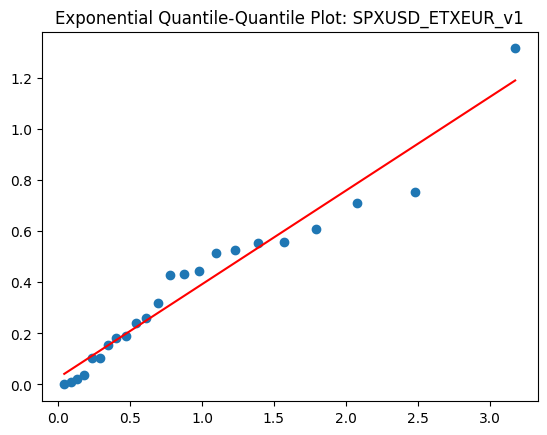

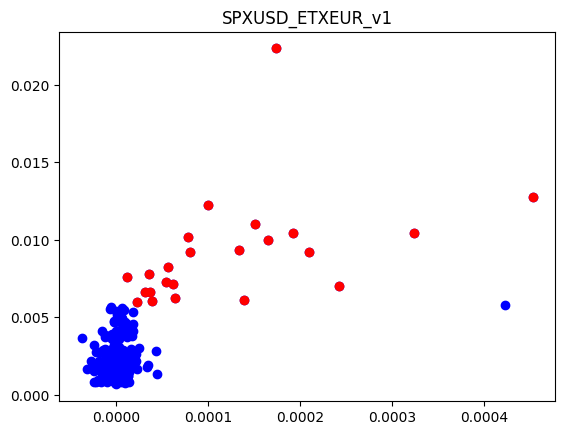

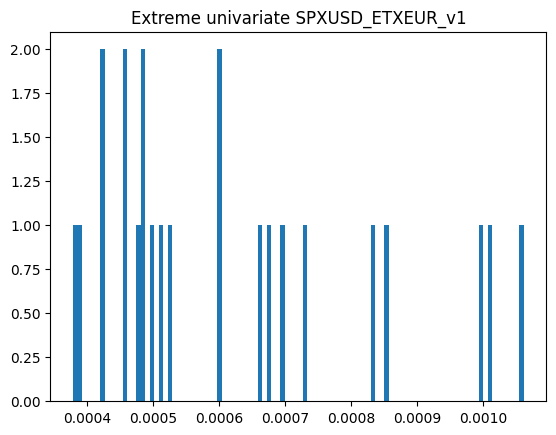

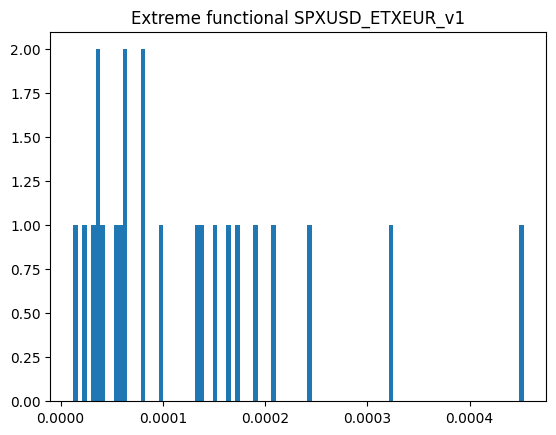

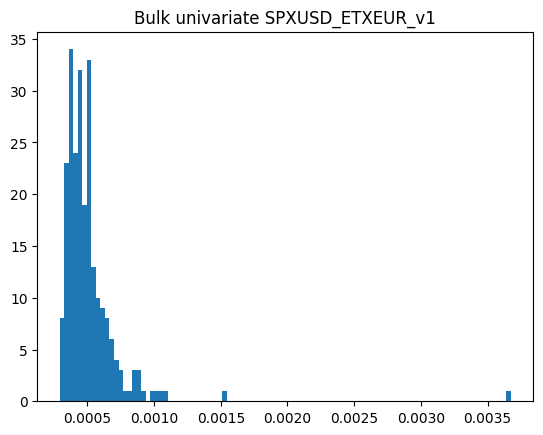

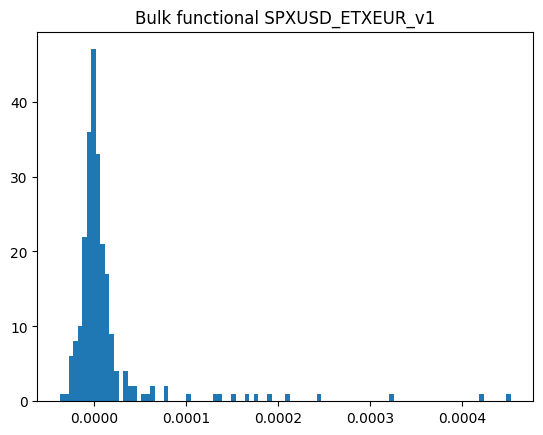

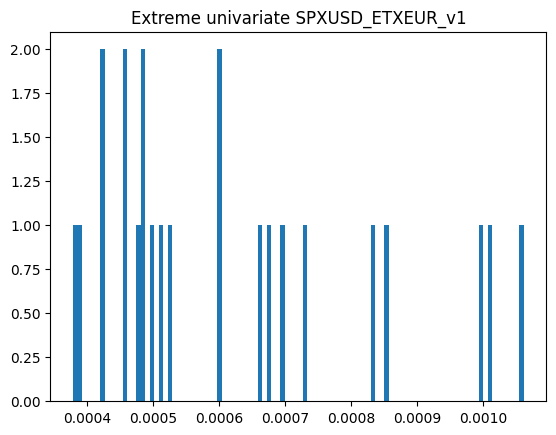

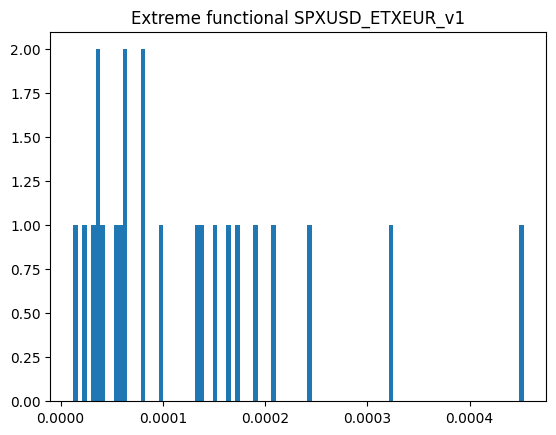

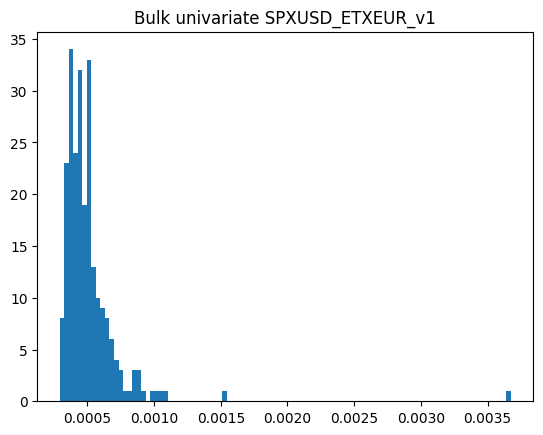

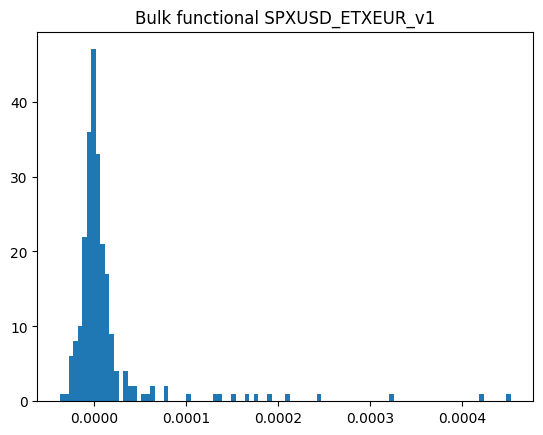

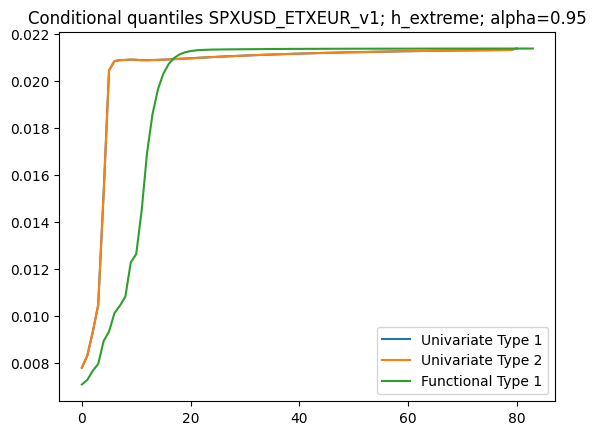

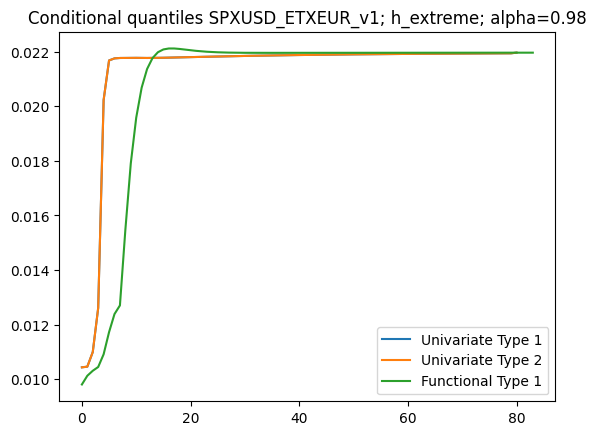

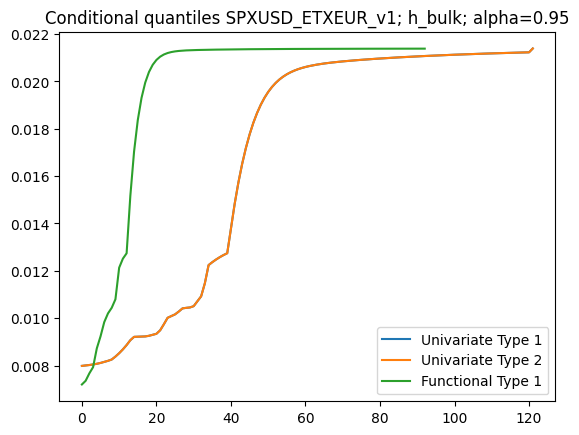

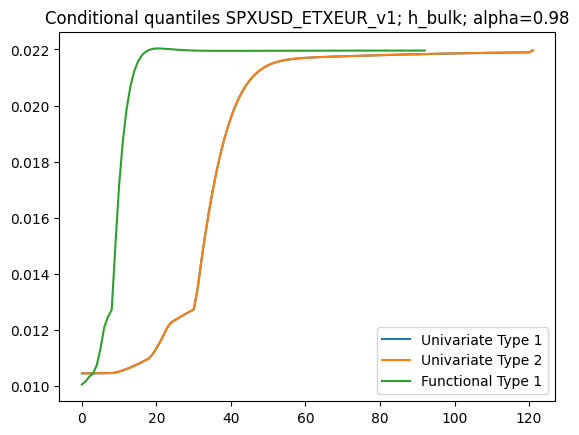

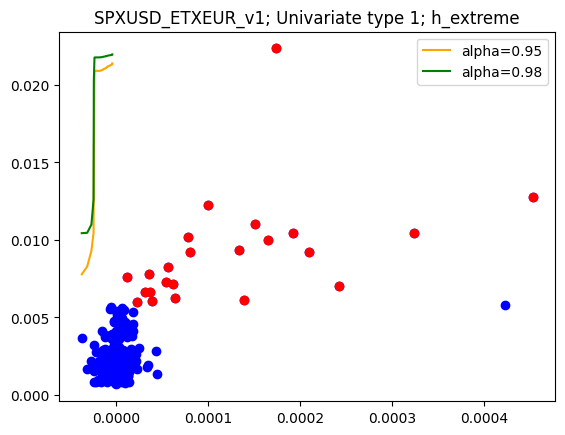

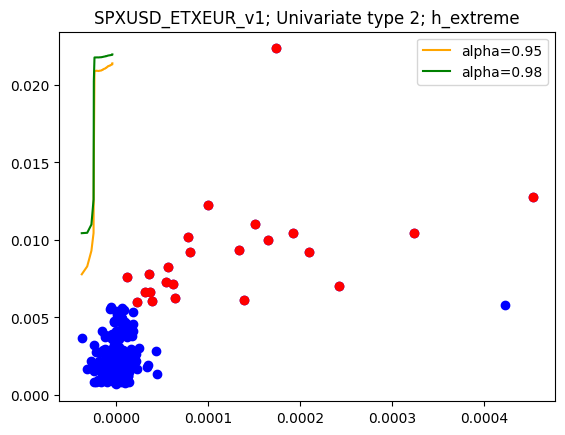

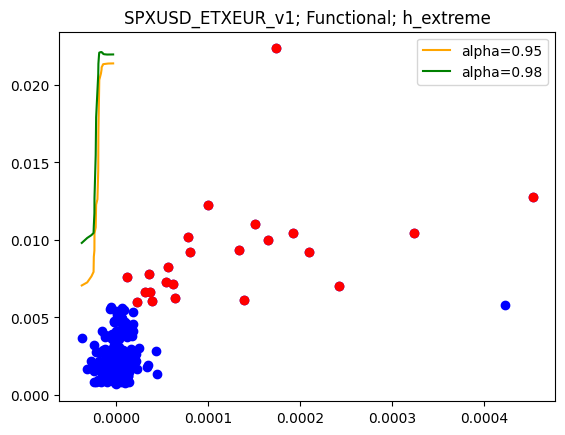

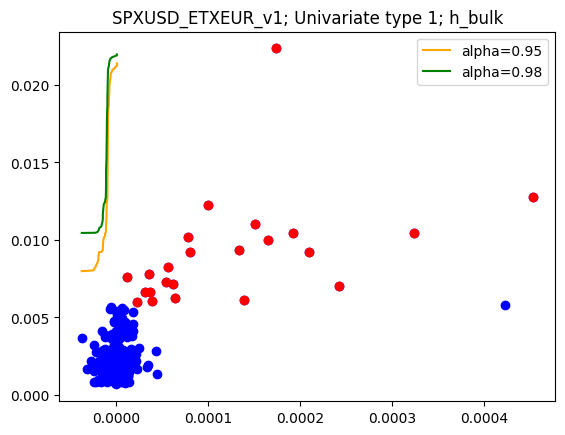

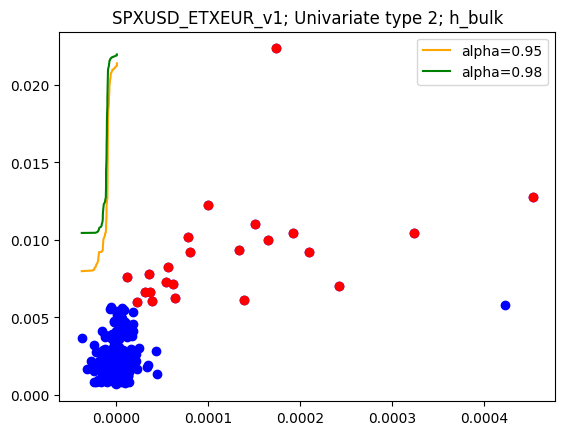

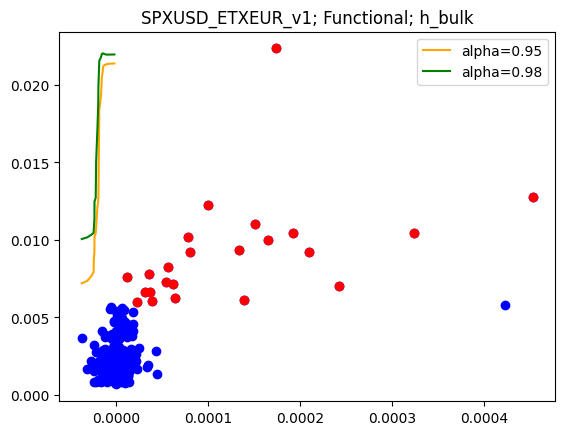

In [6]:

####################### Change time format to match ETXEUR datasets with SPXUSD/GRXEUR/JP datasets (names of columns and timeformat)


X1_2013_SPXUSD_ETXEUR = pd.merge(X1_2013_SPXUSD, X1_2013_ETXEUR, on='date', how='inner')
X1_2014_SPXUSD_ETXEUR = pd.merge(X1_2014_SPXUSD, X1_2014_ETXEUR, on='date', how='inner')
X1_2015_SPXUSD_ETXEUR = pd.merge(X1_2015_SPXUSD, X1_2015_ETXEUR, on='date', how='inner')
X1_2016_SPXUSD_ETXEUR = pd.merge(X1_2016_SPXUSD, X1_2016_ETXEUR, on='date', how='inner')
X1_2017_SPXUSD_ETXEUR = pd.merge(X1_2017_SPXUSD, X1_2017_ETXEUR, on='date', how='inner')

X_2013_SPXUSD_ETXEUR = ((X1_2013_SPXUSD_ETXEUR.values)[:,[4,9]]).astype(float)
X_2014_SPXUSD_ETXEUR = ((X1_2014_SPXUSD_ETXEUR.values)[:,[4,9]]).astype(float)
X_2015_SPXUSD_ETXEUR = ((X1_2015_SPXUSD_ETXEUR.values)[:,[4,9]]).astype(float)
X_2016_SPXUSD_ETXEUR = ((X1_2016_SPXUSD_ETXEUR.values)[:,[4,9]]).astype(float)
X_2017_SPXUSD_ETXEUR = ((X1_2017_SPXUSD_ETXEUR.values)[:,[4,9]]).astype(float)

X_conc_SPXUSD_ETXEUR =np.append(X_2013_SPXUSD_ETXEUR,X_2014_SPXUSD_ETXEUR,axis=0)
X_conc_SPXUSD_ETXEUR =np.append(X_conc_SPXUSD_ETXEUR,X_2015_SPXUSD_ETXEUR,axis=0)
X_conc_SPXUSD_ETXEUR =np.append(X_conc_SPXUSD_ETXEUR,X_2016_SPXUSD_ETXEUR,axis=0)
X_conc_SPXUSD_ETXEUR =np.append(X_conc_SPXUSD_ETXEUR,X_2017_SPXUSD_ETXEUR,axis=0)

X_conc_SPXUSD=X_conc_SPXUSD_ETXEUR[:,0]
X_conc_ETXEUR=X_conc_SPXUSD_ETXEUR[:,1]

X_logreturn_conc2_SPXUSD=np.diff(np.log(X_conc_SPXUSD)) # shape -1
X_logreturn_conc_SPXUSD = np.append(X_logreturn_conc2_SPXUSD[0],X_logreturn_conc2_SPXUSD) # shape +1

X_logreturn_conc2_ETXEUR=np.diff(np.log(X_conc_ETXEUR)) # shape -1
X_logreturn_conc_ETXEUR = np.append(X_logreturn_conc2_ETXEUR[0],X_logreturn_conc2_ETXEUR) # shape +1

SPXUSD_per_day=mesh_time(X_logreturn_conc_SPXUSD,'24h') # shape = (863, 1440) - 863 days with 1440 minutes recorded 
ETXEUR_per_day=mesh_time(X_logreturn_conc_ETXEUR,'24h') # shape = (863, 1440)

SPXUSD_per_day_even=SPXUSD_per_day[::2,:]
ETXEUR_per_day_even=ETXEUR_per_day[::2,:]
SPXUSD_per_day_odd=SPXUSD_per_day[1::2,:]
ETXEUR_per_day_odd=ETXEUR_per_day[1::2,:]

Y_SPXUSD_ETXEUR = np.max(SPXUSD_per_day_odd,axis=1)[1:]
X_SPXUSD_ETXEUR = ETXEUR_per_day_even[:-1,:]

#Y_SPXUSD_ETXEUR = np.max(ETXEUR_per_day_odd,axis=1)[1:]
#X_SPXUSD_ETXEUR = SPXUSD_per_day_even[:-1,:]

X_SPXUSD_ETXEUR=np.expand_dims(X_SPXUSD_ETXEUR,axis=0) # shape (N,n,d) with N=1;n=431;1440
Y_SPXUSD_ETXEUR=np.expand_dims(Y_SPXUSD_ETXEUR,axis=0) # shape (N,n,d) with N=1;n=431;1440

index_to_remove1_SPXUSD_ETXEUR = np.argmax(Y_SPXUSD_ETXEUR,axis=1)
Y_SPXUSD_ETXEUR_new1 = np.expand_dims(np.delete(Y_SPXUSD_ETXEUR[0,:],index_to_remove1_SPXUSD_ETXEUR),axis=0)
X_SPXUSD_ETXEUR_new1=np.delete(X_SPXUSD_ETXEUR,index_to_remove1_SPXUSD_ETXEUR,axis=1)
index_to_remove2_SPXUSD_ETXEUR=np.argmax(Y_SPXUSD_ETXEUR_new1,axis=1)
Y_SPXUSD_ETXEUR_reduced=np.expand_dims(np.delete(Y_SPXUSD_ETXEUR_new1,index_to_remove2_SPXUSD_ETXEUR),axis=0)
X_SPXUSD_ETXEUR_reduced=np.delete(X_SPXUSD_ETXEUR_new1,index_to_remove2_SPXUSD_ETXEUR,axis=1)
###################################################
N=X_SPXUSD_ETXEUR.shape[0]
n=X_SPXUSD_ETXEUR.shape[1]
d=X_SPXUSD_ETXEUR.shape[2]

print('Data size', n)
max_threshold_SPXUSD_ETXEUR = int(np.floor(n/5)) # top 20% if n/5, top10% if n/10
min_threshold = 15
tau=1

############################### Correlation and Scatterplot
C0_SPXUSD_ETXEUR = bitcoin_concomittant_corr(X_SPXUSD_ETXEUR,Y_SPXUSD_ETXEUR,tau,max_threshold_SPXUSD_ETXEUR)
plt.plot(C0_SPXUSD_ETXEUR)
plt.title('Correlation; tau=1, SPXUSD_ETXEUR_v1')
plt.show()

ind=np.argmax(C0_SPXUSD_ETXEUR[min_threshold:max_threshold_SPXUSD_ETXEUR])+min_threshold 
print('SPXUSD_ETXEUR_v1 - max corr - index:', C0_SPXUSD_ETXEUR[ind], ind)

############### Hill Plot
G_SPXUSD_ETXEUR=get_hill_estimator(np.sort(Y_SPXUSD_ETXEUR[0,:])[::-1])
index_min = 750
plt.plot(G_SPXUSD_ETXEUR[:index_min])
plt.title('SPXUSD_ETXEUR_v1; Hill plot')
plt.show()

####################### Exponential Quantile-Quantile Plot
QQ=Exponential_QQ_Plot_1D(Y_SPXUSD_ETXEUR,ind)
x=QQ[:,0]
y=QQ[:,1]
res=linregress(QQ[:,0],QQ[:,1])
plt.plot(QQ[:,0], QQ[:,1], 'o')
plt.plot(QQ[:,0], res.intercept + res.slope*QQ[:,0], 'r')
plt.title('Exponential Quantile-Quantile Plot: SPXUSD_ETXEUR_v1')
print('intermediate_seq k_n is',80)
plt.show()

################################################################## FEPLS
y_matrix_SPXUSD_ETXEUR = bitcoin_threshold(X_SPXUSD_ETXEUR,Y_SPXUSD_ETXEUR,tau,max_threshold_SPXUSD_ETXEUR,min_threshold)
E0_SPXUSD_ETXEUR=fepls(X_SPXUSD_ETXEUR,Y_SPXUSD_ETXEUR,y_matrix_SPXUSD_ETXEUR,tau)
F0_SPXUSD_ETXEUR=hatbeta_dot_X(X_SPXUSD_ETXEUR,E0_SPXUSD_ETXEUR)
bti = bitcoin_threshold_index(X_SPXUSD_ETXEUR,Y_SPXUSD_ETXEUR,tau,max_threshold_SPXUSD_ETXEUR,min_threshold)

################################################################# Scatter plot
plt.scatter(F0_SPXUSD_ETXEUR[0,:], Y_SPXUSD_ETXEUR[0,:], color='blue', marker='o')
highest_indices_SPXUSD_ETXEUR= np.argsort(Y_SPXUSD_ETXEUR)[0,-bti:]
plt.scatter(F0_SPXUSD_ETXEUR[0,highest_indices_SPXUSD_ETXEUR], Y_SPXUSD_ETXEUR[0,highest_indices_SPXUSD_ETXEUR], color='red')
#plt.savefig('Scatter_SPXUSD500_5_tau_-2_v2.pdf') 
plt.title('SPXUSD_ETXEUR_v1')
plt.show()

#########################
x=0
a=0
b=0.05
alpha1=0.95
alpha2=0.98
kernel=2 # Gaussian kernel
J=9
N=X_SPXUSD_ETXEUR.shape[0]
n=X_SPXUSD_ETXEUR.shape[1]
d=X_SPXUSD_ETXEUR.shape[2]
max_threshold_SPXUSD_ETXEUR = int(n/5)
min_threshold = 15
s1=1
s2=1

#####################################
X_2D = X_SPXUSD_ETXEUR[0,:,:]
Y_sort_index = np.argsort(Y_SPXUSD_ETXEUR,axis=1)
x_func = E0_SPXUSD_ETXEUR[0,:]
#############################
H_extreme=hist_weight_extreme_2D(X_2D,Y_SPXUSD_ETXEUR,Y_sort_index,x_func,x,tau,max_threshold_SPXUSD_ETXEUR,min_threshold)
thresholdd = threshold(X_SPXUSD_ETXEUR,Y_SPXUSD_ETXEUR,Y_sort_index,tau,max_threshold_SPXUSD_ETXEUR,min_threshold)
index_to_remove = np.where(Y_SPXUSD_ETXEUR<=thresholdd)
X_extreme_2D=np.delete(X_2D,index_to_remove,axis=0)
H_total_extreme=hist_weight_extreme_2D_total(X_extreme_2D,x_func,a,b,1440)
#############################
plt.hist(H_extreme[:,0],bins=100)
plt.title('Extreme univariate SPXUSD_ETXEUR_v1')
plt.show()
plt.hist(H_extreme[:,1],bins=100)
plt.title('Extreme functional SPXUSD_ETXEUR_v1')
plt.show()
#############################
H_bulk=hist_weight_2D(X_2D,Y_SPXUSD_ETXEUR,Y_sort_index,x_func,x,tau)
H_total_bulk=hist_weight_2D_total(X_2D,x_func,a,b,1440)
#############################
plt.hist(H_bulk[:,0],bins=100)
plt.title('Bulk univariate SPXUSD_ETXEUR_v1')
plt.show()
plt.hist(H_bulk[:,1],bins=100)
plt.title('Bulk functional SPXUSD_ETXEUR_v1')
plt.show()

#####################################
X_2D = X_SPXUSD_ETXEUR[0,:,:]
Y_sort_index = np.argsort(Y_SPXUSD_ETXEUR,axis=1)
x_func = E0_SPXUSD_ETXEUR[0,:]

#############################
H_extreme=hist_weight_extreme_2D(X_2D,Y_SPXUSD_ETXEUR,Y_sort_index,x_func,x,tau,max_threshold_SPXUSD_ETXEUR,min_threshold)
thresholdd = threshold(X_SPXUSD_ETXEUR,Y_SPXUSD_ETXEUR,Y_sort_index,tau,max_threshold_SPXUSD_ETXEUR,min_threshold)
index_to_remove = np.where(Y_SPXUSD_ETXEUR<=thresholdd)
X_extreme_2D=np.delete(X_2D,index_to_remove,axis=0)
H_total_extreme=hist_weight_extreme_2D_total(X_extreme_2D,x_func,a,b,201)

#############################
plt.hist(H_extreme[:,0],bins=100)
plt.title('Extreme univariate SPXUSD_ETXEUR_v1')
plt.show()
plt.hist(H_extreme[:,1],bins=100)
plt.title('Extreme functional SPXUSD_ETXEUR_v1')
plt.show()

#############################
H_bulk=hist_weight_2D(X_2D,Y_SPXUSD_ETXEUR,Y_sort_index,x_func,x,tau)
H_total_bulk=hist_weight_2D_total(X_2D,x_func,a,b,201)

#############################
plt.hist(H_bulk[:,0],bins=100)
plt.title('Bulk univariate SPXUSD_ETXEUR_v1')
plt.show()
plt.hist(H_bulk[:,1],bins=100)
plt.title('Bulk functional SPXUSD_ETXEUR_v1')
plt.show()

############################################# Window/Bandwidth choice
h_vector_extreme = (np.max(H_total_extreme[:,:,0],axis=0)-np.min(H_total_extreme[:,:,0],axis=0))/s1
h_func_vector_extreme = (np.max(H_total_extreme[:,:,1],axis=0)-np.min(H_total_extreme[:,:,1],axis=0))/s2
h_extreme=(np.max(H_extreme[:,0],axis=0)-np.min(H_extreme[:,0],axis=0))/s1
h_func_extreme=(np.max(H_extreme[:,1],axis=0)-np.min(H_extreme[:,1],axis=0))/s2
h_func_2D_extreme=np.transpose(np.outer(h_func_extreme*np.ones(n),np.ones(N))) # of shape (N,n) where A.shape = (n,); e.g., A=h_func*np.ones(n)

h_vector_bulk = (np.max(H_total_bulk[:,:,0],axis=0)-np.min(H_total_bulk[:,:,0],axis=0))/s1
h_func_vector_bulk = (np.max(H_total_bulk[:,:,1],axis=0)-np.min(H_total_bulk[:,:,1],axis=0))/s2
h_bulk=(np.max(H_bulk[:,0],axis=0)-np.min(H_bulk[:,0],axis=0))/s1
h_func_bulk=(np.max(H_bulk[:,1],axis=0)-np.min(H_bulk[:,1],axis=0))/s2
h_func_2D_bulk=np.transpose(np.outer(h_func_bulk*np.ones(n),np.ones(N))) # of shape (N,n) where A.shape = (n,); e.g., A=h_func*np.ones(n)

###############################################################################
# Y|(X,dimred1)=(x*x_func,dimred1) (type 1) vs Y|(X,dimred2) = x (type 2) vs Y|X = x*x_func (type functional)
PP11_extreme=plot_quantile_conditional(X_SPXUSD_ETXEUR,Y_SPXUSD_ETXEUR,E0_SPXUSD_ETXEUR[0,:],E0_SPXUSD_ETXEUR[0,:],E0_SPXUSD_ETXEUR[0,:],alpha1,a,b,n,h_vector_extreme,h_func_vector_extreme,kernel) 
PP12_extreme=plot_quantile_conditional(X_SPXUSD_ETXEUR,Y_SPXUSD_ETXEUR,E0_SPXUSD_ETXEUR[0,:],E0_SPXUSD_ETXEUR[0,:],E0_SPXUSD_ETXEUR[0,:],alpha2,a,b,n,h_vector_extreme,h_func_vector_extreme,kernel) 
PP11_bulk=plot_quantile_conditional(X_SPXUSD_ETXEUR,Y_SPXUSD_ETXEUR,E0_SPXUSD_ETXEUR[0,:],E0_SPXUSD_ETXEUR[0,:],E0_SPXUSD_ETXEUR[0,:],alpha1,a,b,n,h_vector_bulk,h_func_vector_bulk,kernel) 
PP12_bulk=plot_quantile_conditional(X_SPXUSD_ETXEUR,Y_SPXUSD_ETXEUR,E0_SPXUSD_ETXEUR[0,:],E0_SPXUSD_ETXEUR[0,:],E0_SPXUSD_ETXEUR[0,:],alpha2,a,b,n,h_vector_bulk,h_func_vector_bulk,kernel) 

plt.plot(PP11_extreme[:,0],label='Univariate Type 1')
plt.plot(PP11_extreme[:,1],label='Univariate Type 2')
plt.plot(PP11_extreme[:,2],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_ETXEUR_v1; h_extreme; alpha=0.95')
plt.show()
plt.plot(PP12_extreme[:,0],label='Univariate Type 1')
plt.plot(PP12_extreme[:,1],label='Univariate Type 2')
plt.plot(PP12_extreme[:,2],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_ETXEUR_v1; h_extreme; alpha=0.98')
plt.show()
plt.plot(PP11_bulk[:,0],label='Univariate Type 1')
plt.plot(PP11_bulk[:,1],label='Univariate Type 2')
plt.plot(PP11_bulk[:,2],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_ETXEUR_v1; h_bulk; alpha=0.95')
plt.show()
plt.plot(PP12_bulk[:,0],label='Univariate Type 1')
plt.plot(PP12_bulk[:,1],label='Univariate Type 2')
plt.plot(PP12_bulk[:,2],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_ETXEUR_v1; h_bulk; alpha=0.98')
plt.show()

###############################################################################
offset1=0
offset2=0

plt.scatter(F0_SPXUSD_ETXEUR[0,:], Y_SPXUSD_ETXEUR[0,:], color='blue', marker='o')
highest_indices_SPXUSD_ETXEUR = np.argsort(Y_SPXUSD_ETXEUR)[0,-bti:]
plt.scatter(F0_SPXUSD_ETXEUR[0,highest_indices_SPXUSD_ETXEUR], Y_SPXUSD_ETXEUR[0,highest_indices_SPXUSD_ETXEUR], color='red')
plt.plot(np.sort(F0_SPXUSD_ETXEUR[0,:])+offset1,  PP11_extreme[:,0], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_ETXEUR[0,:])+offset2,  PP12_extreme[:,0], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_ETXEUR_v1; Univariate type 1; h_extreme')
plt.legend()
#plt.savefig('SPXUSD_ETXEUR_Univariate_type1_h_extreme.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_ETXEUR[0,:], Y_SPXUSD_ETXEUR[0,:], color='blue', marker='o')
highest_indices_SPXUSD_ETXEUR = np.argsort(Y_SPXUSD_ETXEUR)[0,-bti:]
plt.scatter(F0_SPXUSD_ETXEUR[0,highest_indices_SPXUSD_ETXEUR], Y_SPXUSD_ETXEUR[0,highest_indices_SPXUSD_ETXEUR], color='red')
plt.plot(np.sort(F0_SPXUSD_ETXEUR[0,:])+offset1,  PP11_extreme[:,1], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_ETXEUR[0,:])+offset2,  PP12_extreme[:,1], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_ETXEUR_v1; Univariate type 2; h_extreme')
plt.legend()
#plt.savefig('SPXUSD_ETXEUR_Univariate_type2_h_extreme.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_ETXEUR[0,:], Y_SPXUSD_ETXEUR[0,:], color='blue', marker='o')
highest_indices_SPXUSD_ETXEUR = np.argsort(Y_SPXUSD_ETXEUR)[0,-bti:]
plt.scatter(F0_SPXUSD_ETXEUR[0,highest_indices_SPXUSD_ETXEUR], Y_SPXUSD_ETXEUR[0,highest_indices_SPXUSD_ETXEUR], color='red')
plt.plot(np.sort(F0_SPXUSD_ETXEUR[0,:])+offset1,  PP11_extreme[:,2], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_ETXEUR[0,:])+offset2,  PP12_extreme[:,2], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_ETXEUR_v1; Functional; h_extreme')
plt.legend()
#plt.savefig('SPXUSD_ETXEUR_Functional_h_extreme.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_ETXEUR[0,:], Y_SPXUSD_ETXEUR[0,:], color='blue', marker='o')
highest_indices_SPXUSD_ETXEUR = np.argsort(Y_SPXUSD_ETXEUR)[0,-bti:]
plt.scatter(F0_SPXUSD_ETXEUR[0,highest_indices_SPXUSD_ETXEUR], Y_SPXUSD_ETXEUR[0,highest_indices_SPXUSD_ETXEUR], color='red')
plt.plot(np.sort(F0_SPXUSD_ETXEUR[0,:])+offset1,  PP11_bulk[:,0], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_ETXEUR[0,:])+offset2,  PP12_bulk[:,0], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_ETXEUR_v1; Univariate type 1; h_bulk')
plt.legend()
#plt.savefig('SPXUSD_ETXEUR_Univariate_type1_h_bulk.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_ETXEUR[0,:], Y_SPXUSD_ETXEUR[0,:], color='blue', marker='o')
highest_indices_SPXUSD_ETXEUR = np.argsort(Y_SPXUSD_ETXEUR)[0,-bti:]
plt.scatter(F0_SPXUSD_ETXEUR[0,highest_indices_SPXUSD_ETXEUR], Y_SPXUSD_ETXEUR[0,highest_indices_SPXUSD_ETXEUR], color='red')
plt.plot(np.sort(F0_SPXUSD_ETXEUR[0,:])+offset1,  PP11_bulk[:,1], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_ETXEUR[0,:])+offset2,  PP12_bulk[:,1], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_ETXEUR_v1; Univariate type 2; h_bulk')
plt.legend()
#plt.savefig('SPXUSD_ETXEUR_Univariate_type2_h_bulk.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_ETXEUR[0,:], Y_SPXUSD_ETXEUR[0,:], color='blue', marker='o')
highest_indices_SPXUSD_ETXEUR = np.argsort(Y_SPXUSD_ETXEUR)[0,-bti:]
plt.scatter(F0_SPXUSD_ETXEUR[0,highest_indices_SPXUSD_ETXEUR], Y_SPXUSD_ETXEUR[0,highest_indices_SPXUSD_ETXEUR], color='red')
plt.plot(np.sort(F0_SPXUSD_ETXEUR[0,:])+offset1,  PP11_bulk[:,2], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_ETXEUR[0,:])+offset2,  PP12_bulk[:,2], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_ETXEUR_v1; Functional; h_bulk')
plt.legend()
#plt.savefig('SPXUSD_ETXEUR_Functional_h_bulk.pdf')  
plt.show()

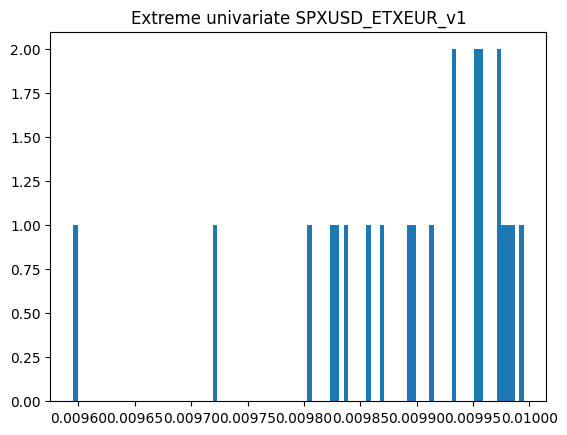

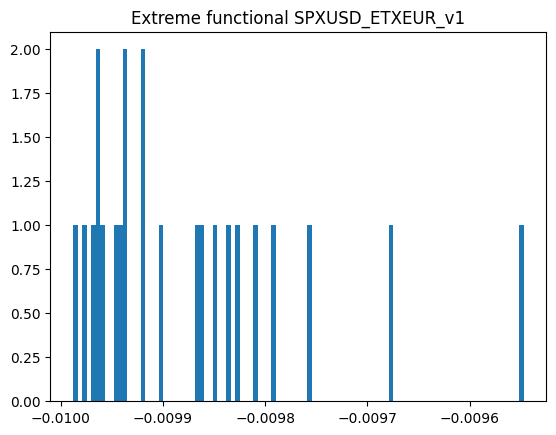

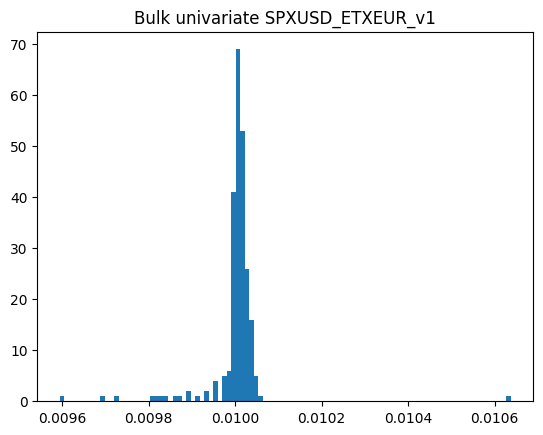

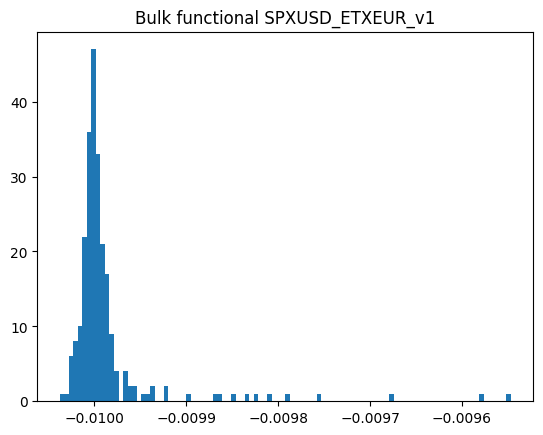

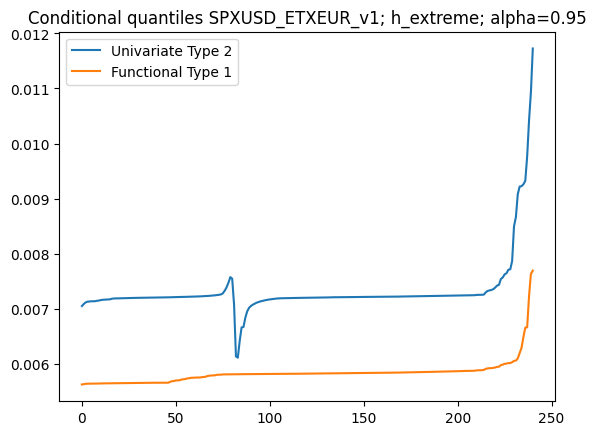

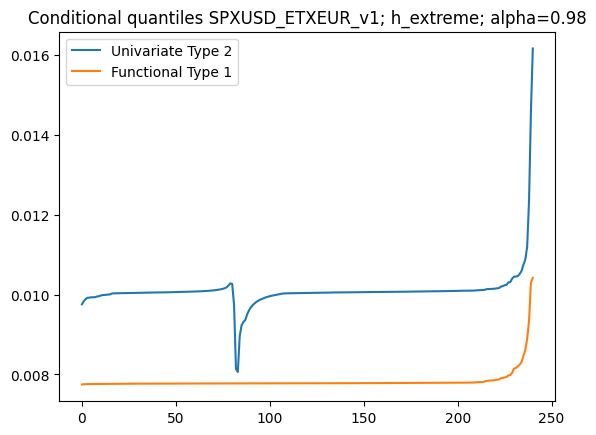

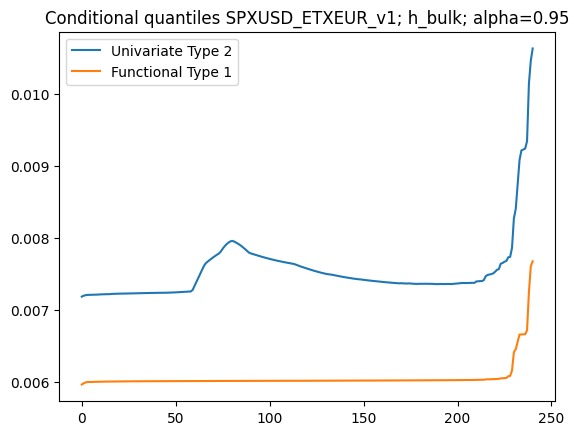

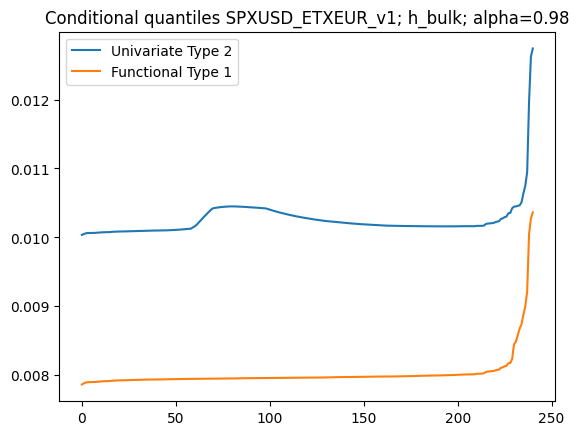

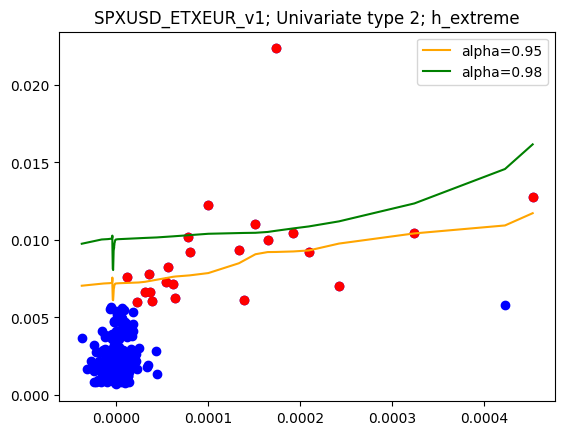

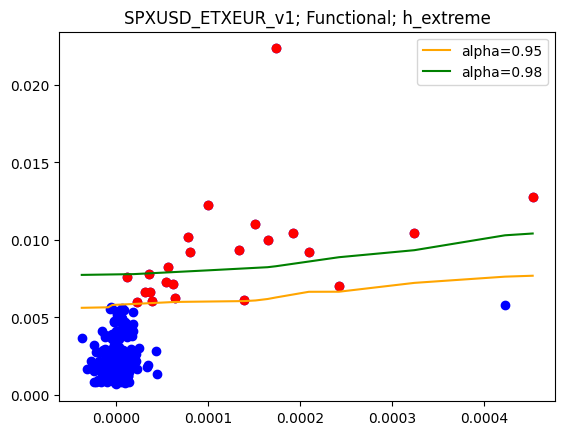

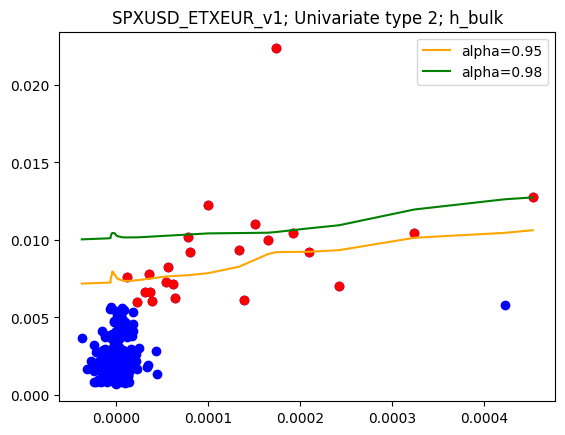

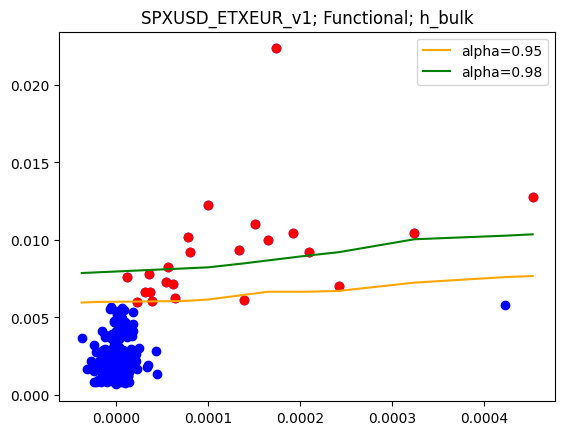

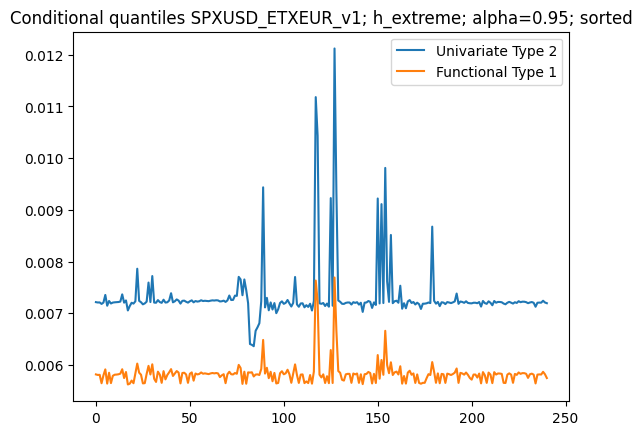

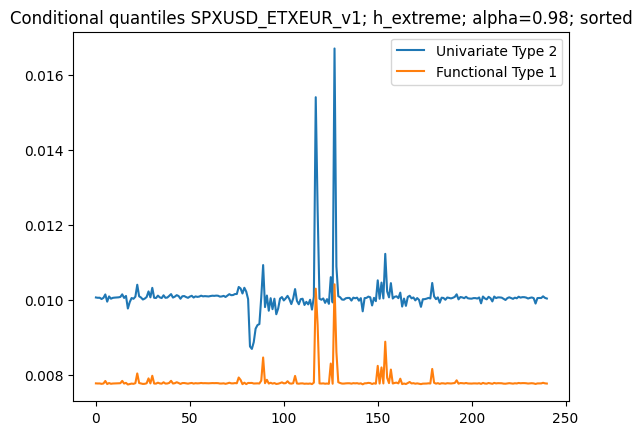

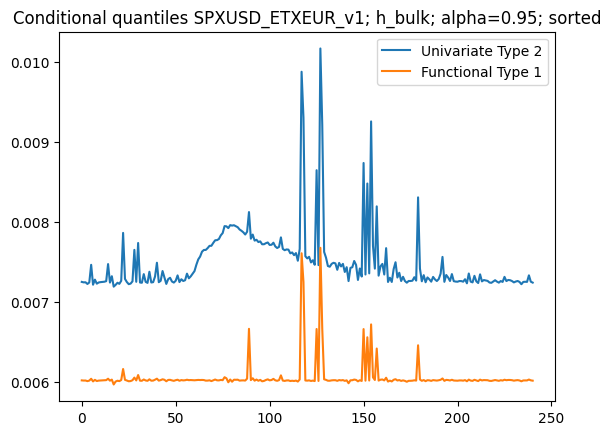

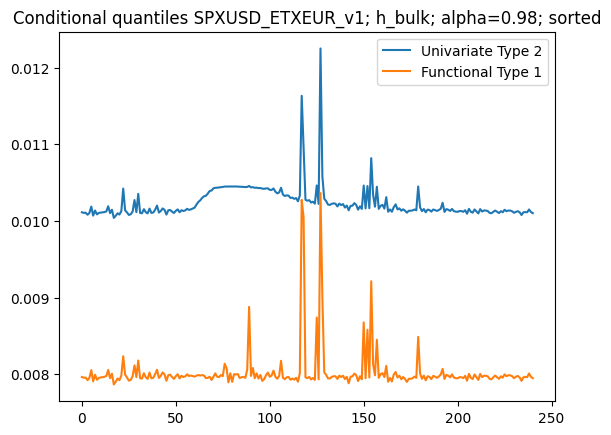

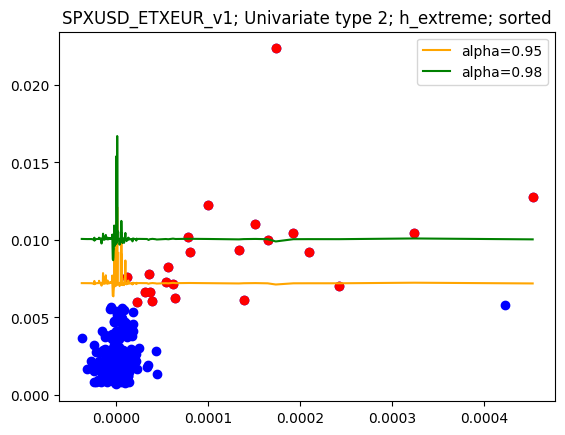

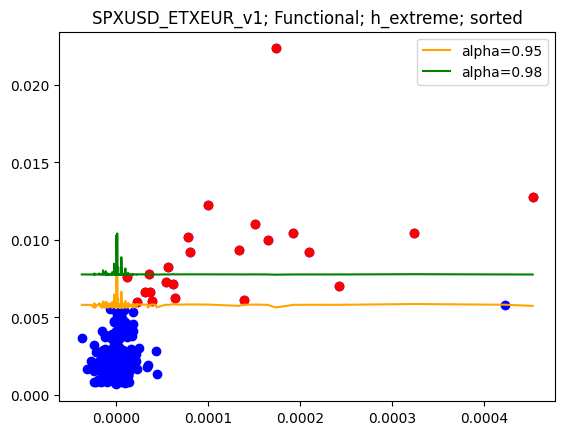

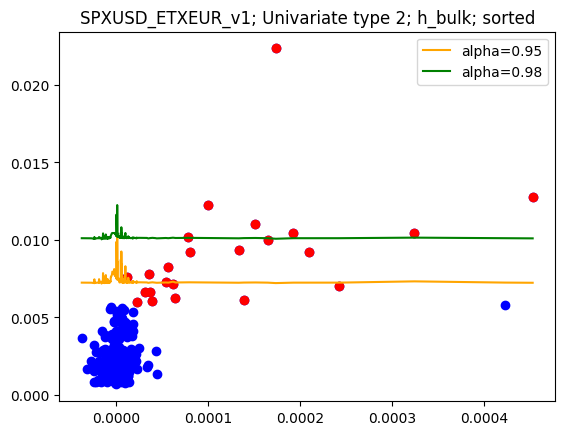

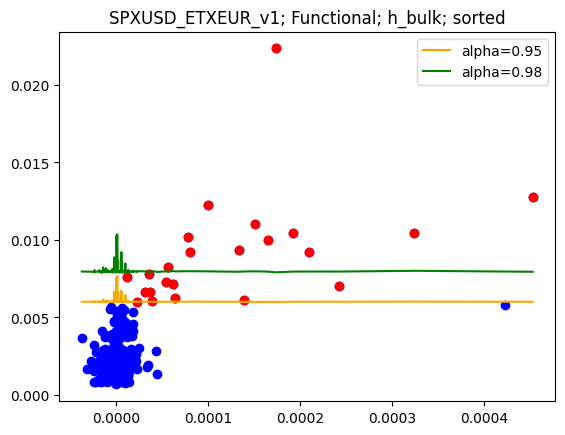

In [7]:

#########################
x=0.01
a=-0.05
b=0.1
alpha1=0.95
alpha2=0.98
kernel=2 # Gaussian kernel
J=9
N=X_SPXUSD_ETXEUR.shape[0]
n=X_SPXUSD_ETXEUR.shape[1]
d=X_SPXUSD_ETXEUR.shape[2]
max_threshold_SPXUSD_ETXEUR = int(n/5)
min_threshold = 15
s1=2
s2=2

#####################################
X_2D = X_SPXUSD_ETXEUR[0,:,:]
Y_sort_index = np.argsort(Y_SPXUSD_ETXEUR,axis=1)
x_func = E0_SPXUSD_ETXEUR[0,:]

#############################
H_extreme=hist_weight_extreme_2D(X_2D,Y_SPXUSD_ETXEUR,Y_sort_index,x_func,x,tau,max_threshold_SPXUSD_ETXEUR,min_threshold)
thresholdd = threshold(X_SPXUSD_ETXEUR,Y_SPXUSD_ETXEUR,Y_sort_index,tau,max_threshold_SPXUSD_ETXEUR,min_threshold)
index_to_remove = np.where(Y_SPXUSD_ETXEUR<=thresholdd)
X_extreme_2D=np.delete(X_2D,index_to_remove,axis=0)
H_total_extreme=hist_weight_extreme_2D_total(X_extreme_2D,x_func,a,b,n)

#############################
plt.hist(H_extreme[:,0],bins=100)
plt.title('Extreme univariate SPXUSD_ETXEUR_v1')
plt.show()
plt.hist(H_extreme[:,1],bins=100)
plt.title('Extreme functional SPXUSD_ETXEUR_v1')
plt.show()

#############################
H_bulk=hist_weight_2D(X_2D,Y_SPXUSD_ETXEUR,Y_sort_index,x_func,x,tau)
H_total_bulk=hist_weight_2D_total(X_2D,x_func,a,b,n)

#############################
plt.hist(H_bulk[:,0],bins=100)
plt.title('Bulk univariate SPXUSD_ETXEUR_v1')
plt.show()
plt.hist(H_bulk[:,1],bins=100)
plt.title('Bulk functional SPXUSD_ETXEUR_v1')
plt.show()

############################################# Window/Bandwidth choice
h_vector_extreme = (np.max(H_total_extreme[:,:,0],axis=0)-np.min(H_total_extreme[:,:,0],axis=0))/s1
h_func_vector_extreme = (np.max(H_total_extreme[:,:,1],axis=0)-np.min(H_total_extreme[:,:,1],axis=0))/s2
h_extreme=(np.max(H_extreme[:,0],axis=0)-np.min(H_extreme[:,0],axis=0))/s1
h_func_extreme=(np.max(H_extreme[:,1],axis=0)-np.min(H_extreme[:,1],axis=0))/s2
h_func_2D_extreme=np.transpose(np.outer(h_func_extreme*np.ones(n),np.ones(N))) # of shape (N,n) where A.shape = (n,); e.g., A=h_func*np.ones(n)

h_vector_bulk = (np.max(H_total_bulk[:,:,0],axis=0)-np.min(H_total_bulk[:,:,0],axis=0))/s1
h_func_vector_bulk = (np.max(H_total_bulk[:,:,1],axis=0)-np.min(H_total_bulk[:,:,1],axis=0))/s2
h_bulk=(np.max(H_bulk[:,0],axis=0)-np.min(H_bulk[:,0],axis=0))/s1
h_func_bulk=(np.max(H_bulk[:,1],axis=0)-np.min(H_bulk[:,1],axis=0))/s2
h_func_2D_bulk=np.transpose(np.outer(h_func_bulk*np.ones(n),np.ones(N))) # of shape (N,n) where A.shape = (n,); e.g., A=h_func*np.ones(n)

###############################################################################
# Y|(X,dimred1)=(x*x_func,dimred1) (type 1) vs Y|(X,dimred2) = x (type 2) vs Y|X = x*x_func (type functional)
covalues = np.sort(np.dot(X_SPXUSD_ETXEUR,E0_SPXUSD_ETXEUR[0,:])/d,axis=1)
covalues_sorted = np.dot(X_SPXUSD_ETXEUR,E0_SPXUSD_ETXEUR[0,:])/d

PP11_extreme_sample=plot_quantile_conditional_on_sample(X_SPXUSD_ETXEUR,Y_SPXUSD_ETXEUR,E0_SPXUSD_ETXEUR[0,:],alpha1,covalues,h_vector_extreme,h_func_vector_extreme,kernel) 
PP12_extreme_sample=plot_quantile_conditional_on_sample(X_SPXUSD_ETXEUR,Y_SPXUSD_ETXEUR,E0_SPXUSD_ETXEUR[0,:],alpha2,covalues,h_vector_extreme,h_func_vector_extreme,kernel)
PP11_bulk_sample=plot_quantile_conditional_on_sample(X_SPXUSD_ETXEUR,Y_SPXUSD_ETXEUR,E0_SPXUSD_ETXEUR[0,:],alpha1,covalues,h_vector_bulk,h_func_vector_bulk,kernel)
PP12_bulk_sample=plot_quantile_conditional_on_sample(X_SPXUSD_ETXEUR,Y_SPXUSD_ETXEUR,E0_SPXUSD_ETXEUR[0,:],alpha2,covalues,h_vector_bulk,h_func_vector_bulk,kernel)

plt.plot(PP11_extreme_sample[:,0],label='Univariate Type 2')
plt.plot(PP11_extreme_sample[:,1],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_ETXEUR_v1; h_extreme; alpha=0.95')
plt.show()
plt.plot(PP12_extreme_sample[:,0],label='Univariate Type 2')
plt.plot(PP12_extreme_sample[:,1],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_ETXEUR_v1; h_extreme; alpha=0.98')
plt.show()
plt.plot(PP11_bulk_sample[:,0],label='Univariate Type 2')
plt.plot(PP11_bulk_sample[:,1],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_ETXEUR_v1; h_bulk; alpha=0.95')
plt.show()
plt.plot(PP12_bulk_sample[:,0],label='Univariate Type 2')
plt.plot(PP12_bulk_sample[:,1],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_ETXEUR_v1; h_bulk; alpha=0.98')
plt.show()

###############################################################################
offset1=0
offset2=0

plt.scatter(F0_SPXUSD_ETXEUR[0,:], Y_SPXUSD_ETXEUR[0,:], color='blue', marker='o')
highest_indices_SPXUSD_ETXEUR = np.argsort(Y_SPXUSD_ETXEUR)[0,-bti:]
plt.scatter(F0_SPXUSD_ETXEUR[0,highest_indices_SPXUSD_ETXEUR], Y_SPXUSD_ETXEUR[0,highest_indices_SPXUSD_ETXEUR], color='red')
plt.plot(np.sort(F0_SPXUSD_ETXEUR[0,:])+offset1,  PP11_extreme_sample[:,0], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_ETXEUR[0,:])+offset2,  PP12_extreme_sample[:,0], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_ETXEUR_v1; Univariate type 2; h_extreme')
plt.legend()
#plt.savefig('SPXUSD_ETXEUR_Univariate_type2_h_extreme.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_ETXEUR[0,:], Y_SPXUSD_ETXEUR[0,:], color='blue', marker='o')
highest_indices_SPXUSD_ETXEUR = np.argsort(Y_SPXUSD_ETXEUR)[0,-bti:]
plt.scatter(F0_SPXUSD_ETXEUR[0,highest_indices_SPXUSD_ETXEUR], Y_SPXUSD_ETXEUR[0,highest_indices_SPXUSD_ETXEUR], color='red')
plt.plot(np.sort(F0_SPXUSD_ETXEUR[0,:])+offset1,  PP11_extreme_sample[:,1], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_ETXEUR[0,:])+offset2,  PP12_extreme_sample[:,1], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_ETXEUR_v1; Functional; h_extreme')
plt.legend()
#plt.savefig('SPXUSD_ETXEUR_Functional_h_extreme.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_ETXEUR[0,:], Y_SPXUSD_ETXEUR[0,:], color='blue', marker='o')
highest_indices_SPXUSD_ETXEUR = np.argsort(Y_SPXUSD_ETXEUR)[0,-bti:]
plt.scatter(F0_SPXUSD_ETXEUR[0,highest_indices_SPXUSD_ETXEUR], Y_SPXUSD_ETXEUR[0,highest_indices_SPXUSD_ETXEUR], color='red')
plt.plot(np.sort(F0_SPXUSD_ETXEUR[0,:])+offset1,  PP11_bulk_sample[:,0], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_ETXEUR[0,:])+offset2,  PP12_bulk_sample[:,0], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_ETXEUR_v1; Univariate type 2; h_bulk')
plt.legend()
#plt.savefig('SPXUSD_ETXEUR_Univariate_type2_h_bulk.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_ETXEUR[0,:], Y_SPXUSD_ETXEUR[0,:], color='blue', marker='o')
highest_indices_SPXUSD_ETXEUR = np.argsort(Y_SPXUSD_ETXEUR)[0,-bti:]
plt.scatter(F0_SPXUSD_ETXEUR[0,highest_indices_SPXUSD_ETXEUR], Y_SPXUSD_ETXEUR[0,highest_indices_SPXUSD_ETXEUR], color='red')
plt.plot(np.sort(F0_SPXUSD_ETXEUR[0,:])+offset1,  PP11_bulk_sample[:,1], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_ETXEUR[0,:])+offset2,  PP12_bulk_sample[:,1], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_ETXEUR_v1; Functional; h_bulk')
plt.legend()
#plt.savefig('SPXUSD_ETXEUR_Functional_h_bulk.pdf')  
plt.show()

PP11_extreme_sample_sorted=plot_quantile_conditional_on_sample(X_SPXUSD_ETXEUR,Y_SPXUSD_ETXEUR,E0_SPXUSD_ETXEUR[0,:],alpha1,covalues_sorted,h_vector_extreme,h_func_vector_extreme,kernel) 
PP12_extreme_sample_sorted=plot_quantile_conditional_on_sample(X_SPXUSD_ETXEUR,Y_SPXUSD_ETXEUR,E0_SPXUSD_ETXEUR[0,:],alpha2,covalues_sorted,h_vector_extreme,h_func_vector_extreme,kernel)
PP11_bulk_sample_sorted=plot_quantile_conditional_on_sample(X_SPXUSD_ETXEUR,Y_SPXUSD_ETXEUR,E0_SPXUSD_ETXEUR[0,:],alpha1,covalues_sorted,h_vector_bulk,h_func_vector_bulk,kernel)
PP12_bulk_sample_sorted=plot_quantile_conditional_on_sample(X_SPXUSD_ETXEUR,Y_SPXUSD_ETXEUR,E0_SPXUSD_ETXEUR[0,:],alpha2,covalues_sorted,h_vector_bulk,h_func_vector_bulk,kernel)

plt.plot(PP11_extreme_sample_sorted[:,0],label='Univariate Type 2')
plt.plot(PP11_extreme_sample_sorted[:,1],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_ETXEUR_v1; h_extreme; alpha=0.95; sorted')
plt.show()
plt.plot(PP12_extreme_sample_sorted[:,0],label='Univariate Type 2')
plt.plot(PP12_extreme_sample_sorted[:,1],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_ETXEUR_v1; h_extreme; alpha=0.98; sorted')
plt.show()
plt.plot(PP11_bulk_sample_sorted[:,0],label='Univariate Type 2')
plt.plot(PP11_bulk_sample_sorted[:,1],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_ETXEUR_v1; h_bulk; alpha=0.95; sorted')
plt.show()
plt.plot(PP12_bulk_sample_sorted[:,0],label='Univariate Type 2')
plt.plot(PP12_bulk_sample_sorted[:,1],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_ETXEUR_v1; h_bulk; alpha=0.98; sorted')
plt.show()

###############################################################################
plt.scatter(F0_SPXUSD_ETXEUR[0,:], Y_SPXUSD_ETXEUR[0,:], color='blue', marker='o')
highest_indices_SPXUSD_ETXEUR = np.argsort(Y_SPXUSD_ETXEUR)[0,-bti:]
plt.scatter(F0_SPXUSD_ETXEUR[0,highest_indices_SPXUSD_ETXEUR], Y_SPXUSD_ETXEUR[0,highest_indices_SPXUSD_ETXEUR], color='red')
plt.plot(np.sort(F0_SPXUSD_ETXEUR[0,:])+offset1,  PP11_extreme_sample_sorted[:,0], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_ETXEUR[0,:])+offset2,  PP12_extreme_sample_sorted[:,0], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_ETXEUR_v1; Univariate type 2; h_extreme; sorted')
plt.legend()
#plt.savefig('SPXUSD_ETXEUR_Univariate_type2_h_extreme_sorted.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_ETXEUR[0,:], Y_SPXUSD_ETXEUR[0,:], color='blue', marker='o')
highest_indices_SPXUSD_ETXEUR = np.argsort(Y_SPXUSD_ETXEUR)[0,-bti:]
plt.scatter(F0_SPXUSD_ETXEUR[0,highest_indices_SPXUSD_ETXEUR], Y_SPXUSD_ETXEUR[0,highest_indices_SPXUSD_ETXEUR], color='red')
plt.plot(np.sort(F0_SPXUSD_ETXEUR[0,:])+offset1,  PP11_extreme_sample_sorted[:,1], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_ETXEUR[0,:])+offset2,  PP12_extreme_sample_sorted[:,1], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_ETXEUR_v1; Functional; h_extreme; sorted')
plt.legend()
#plt.savefig('SPXUSD_ETXEUR_Functional_h_extreme_sorted.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_ETXEUR[0,:], Y_SPXUSD_ETXEUR[0,:], color='blue', marker='o')
highest_indices_SPXUSD_ETXEUR = np.argsort(Y_SPXUSD_ETXEUR)[0,-bti:]
plt.scatter(F0_SPXUSD_ETXEUR[0,highest_indices_SPXUSD_ETXEUR], Y_SPXUSD_ETXEUR[0,highest_indices_SPXUSD_ETXEUR], color='red')
plt.plot(np.sort(F0_SPXUSD_ETXEUR[0,:])+offset1,  PP11_bulk_sample_sorted[:,0], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_ETXEUR[0,:])+offset2,  PP12_bulk_sample_sorted[:,0], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_ETXEUR_v1; Univariate type 2; h_bulk; sorted')
plt.legend()
#plt.savefig('SPXUSD_ETXEUR_Univariate_type2_h_bulk_sorted.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_ETXEUR[0,:], Y_SPXUSD_ETXEUR[0,:], color='blue', marker='o')
highest_indices_SPXUSD_ETXEUR = np.argsort(Y_SPXUSD_ETXEUR)[0,-bti:]
plt.scatter(F0_SPXUSD_ETXEUR[0,highest_indices_SPXUSD_ETXEUR], Y_SPXUSD_ETXEUR[0,highest_indices_SPXUSD_ETXEUR], color='red')
plt.plot(np.sort(F0_SPXUSD_ETXEUR[0,:])+offset1,  PP11_bulk_sample_sorted[:,1], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_ETXEUR[0,:])+offset2,  PP12_bulk_sample_sorted[:,1], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_ETXEUR_v1; Functional; h_bulk; sorted')
plt.legend()
#plt.savefig('SPXUSD_ETXEUR_Functional_h_bulk_sorted.pdf')  
plt.show()

The bandwidth h for the following plots is 0.004


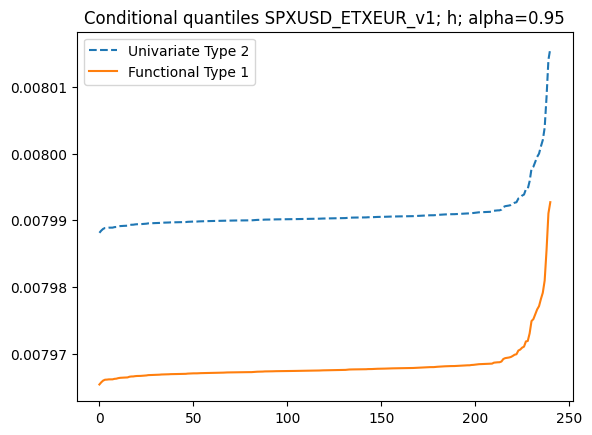

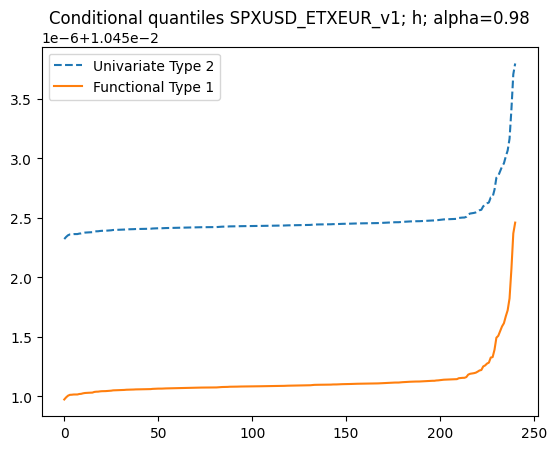

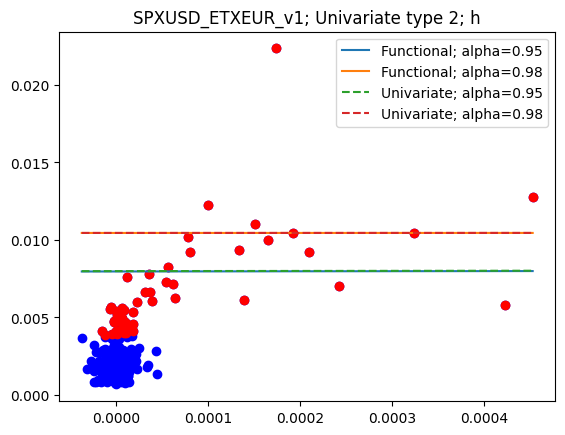

In [18]:
@numba.njit(parallel=True, fastmath=False) 
def plot_quantile_conditional_on_sample2(X,Y,dimred,covalues,x_func,alpha,h_vector,h_func_vector,kernel): 
    # X of shape (N,n,d) and Y of shape (N,n) with N=1;n=...;d=1440
    # covalues=np.dot(X_SPXUSD_ETXEUR,E0_SPXUSD_ETXEUR[0,:])/d   # shape = (N,n) = (1,431) family of (<X_i,dimred>)_{1\le i \le n} avec dimred \in H de taille (d,)=(1440)
    # dimred of shape (d,), e.g., dimred = E0[0,:] with E0 = fepls(X,Y,y_matrix,tau)
    # h_vector.shape = h_func_vector.shape = (n,)
    # Functional: X = x_func \in H; Univariate (type 2): <X,dimred>=covalues\in \R with covalues=<X_i,x_func> for 1 \le i \le n.   
    # x_func is a generical function/vector of shape (d,) and dimred is the FEPLS, i.e., E0[0,:] also of shape (d,)
    n=Y.shape[1]
    out = np.zeros((n,2))
    for p in numba.prange(n):
        weight2=univariate_Nadaraya_weight_2D(X[0,:,:],dimred,dimred,covalues[0,p],h_vector[p],2,kernel)
        weight_func=functional_Nadaraya_weight_2D(X[0,:,:],covalues[0,p]*dimred,h_func_vector[p],kernel)
        out[p,0]=weighted_quantile(Y[0,:],weight2,alpha)
        out[p,1]=weighted_quantile(Y[0,:],weight_func,alpha)
    return out

#########################

alpha1=0.95
alpha2=0.98
kernel=2 # Gaussian kernel
J=9

N=X_SPXUSD_ETXEUR.shape[0]
n=X_SPXUSD_ETXEUR.shape[1]
d=X_SPXUSD_ETXEUR.shape[2]

##############################################################################
# Y|(X,dimred) = covalues (type univariate) vs Y|X = x_func (type functional)

dimred = E0_SPXUSD_ETXEUR[0,:] # of shape (d,)
x_func = E0_SPXUSD_ETXEUR[0,:] # of shape (d,)
covalues = np.sort(np.dot(X_SPXUSD_ETXEUR,x_func)/d,axis=1)

##############################################################

H_grid=[0.004] #np.linspace(0.0002,0.004,51)

for h in H_grid:
    h_vector = h*np.ones((n,))
    h_func_vector = h*np.ones((n,))
    
    PP11_sample=plot_quantile_conditional_on_sample2(X_SPXUSD_ETXEUR,Y_SPXUSD_ETXEUR,dimred,covalues,x_func,alpha1,h_vector,h_func_vector,kernel) 
    PP12_sample=plot_quantile_conditional_on_sample2(X_SPXUSD_ETXEUR,Y_SPXUSD_ETXEUR,dimred,covalues,x_func,alpha2,h_vector,h_func_vector,kernel)
    print('The bandwidth h for the following plots is',h) 
    plt.plot(PP11_sample[:,0], linestyle='dashed', label='Univariate Type 2')
    plt.plot(PP11_sample[:,1], label='Functional Type 1')
    plt.legend()
    plt.title('Conditional quantiles SPXUSD_ETXEUR_v1; h; alpha=0.95')
    plt.show()
    plt.plot(PP12_sample[:,0], linestyle='dashed', label='Univariate Type 2')
    plt.plot(PP12_sample[:,1],label='Functional Type 1')
    plt.legend()
    plt.title('Conditional quantiles SPXUSD_ETXEUR_v1; h; alpha=0.98')
    plt.show()
    ###########################################################
    offset1=0
    offset2=0
    plt.scatter(F0_SPXUSD_ETXEUR[0,:], Y_SPXUSD_ETXEUR[0,:], color='blue', marker='o')
    highest_indices_SPXUSD_ETXEUR = np.argsort(Y_SPXUSD_ETXEUR)[0,-bti:]
    plt.scatter(F0_SPXUSD_ETXEUR[0,highest_indices_SPXUSD_ETXEUR], Y_SPXUSD_ETXEUR[0,highest_indices_SPXUSD_ETXEUR], color='red')
    plt.plot(np.sort(F0_SPXUSD_ETXEUR[0,:])+offset1,  PP11_sample[:,1],  label='Functional; alpha=0.95')
    plt.plot(np.sort(F0_SPXUSD_ETXEUR[0,:])+offset2,  PP12_sample[:,1],  label='Functional; alpha=0.98')
    plt.plot(np.sort(F0_SPXUSD_ETXEUR[0,:])+offset1,  PP11_sample[:,0],  linestyle='dashed',label='Univariate; alpha=0.95')
    plt.plot(np.sort(F0_SPXUSD_ETXEUR[0,:])+offset2,  PP12_sample[:,0],  linestyle='dashed',label='Univariate; alpha=0.98')
    #plt.xlim(-0.02, 0.03) 
    #plt.ylim(-0.01, 0.22) 
    plt.title('SPXUSD_ETXEUR_v1; Univariate type 2; h')
    plt.legend()
    #plt.savefig('SPXUSD_ETXEUR_Univariate_type2_h.pdf')  
    plt.show()



Data size 338


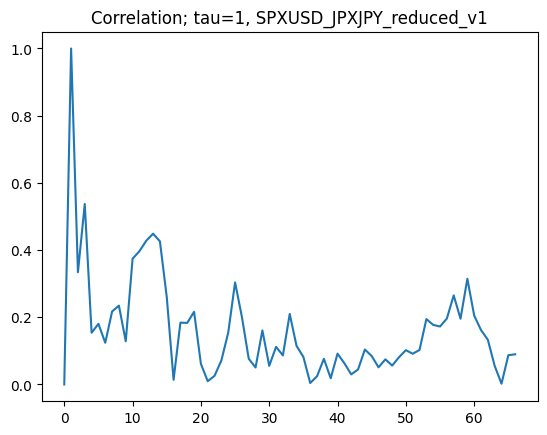

SPXUSD_JPXJPY_reduced_v1 - max corr - index: 0.3145955450444951 59


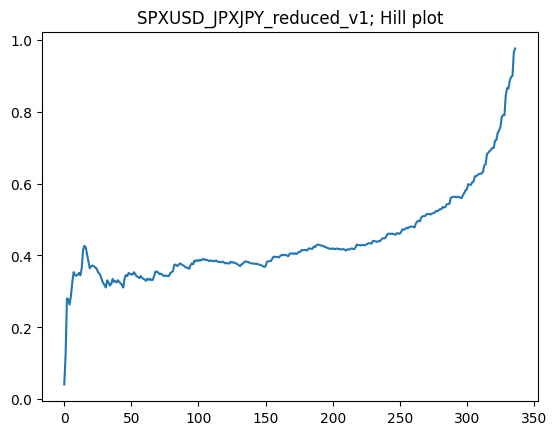

intermediate_seq k_n is 195


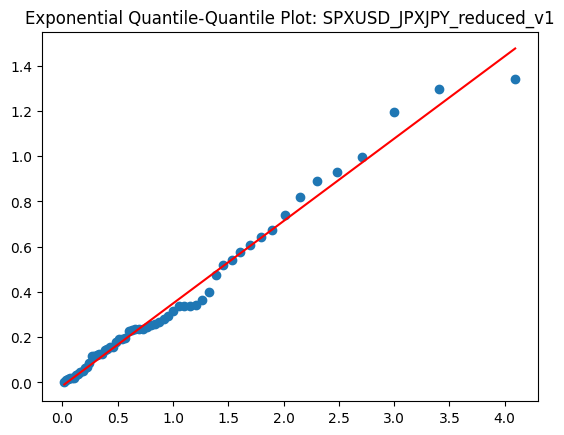

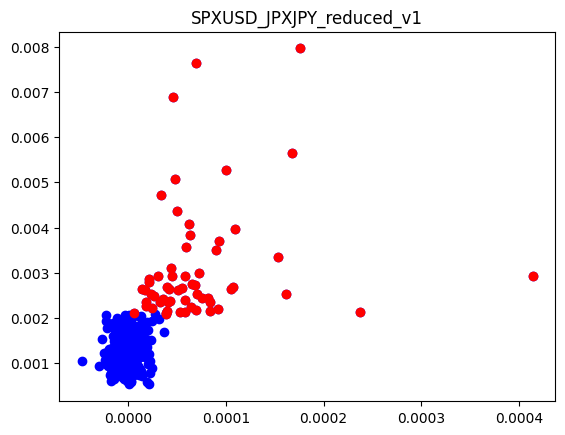

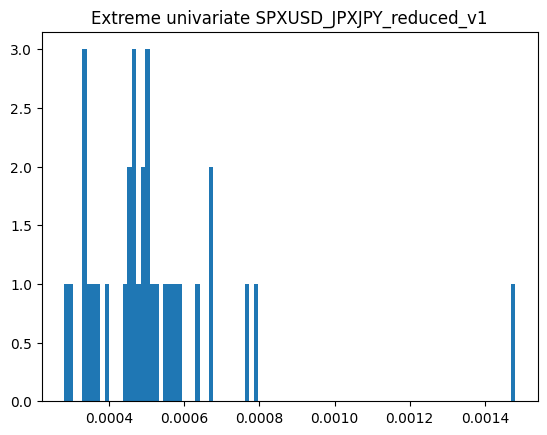

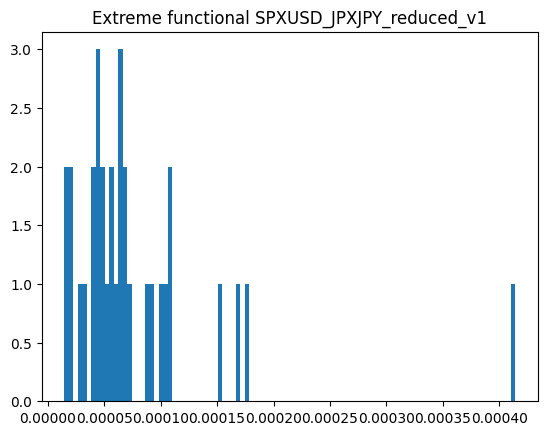

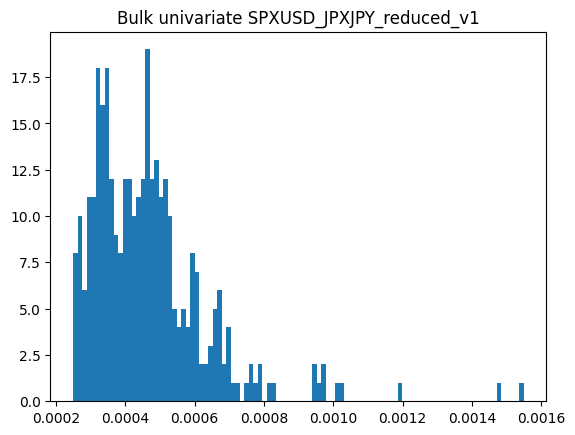

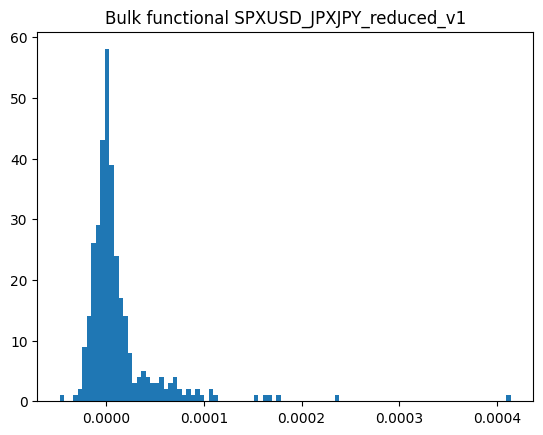

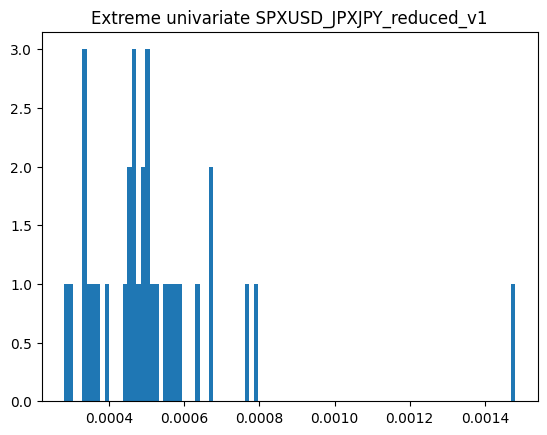

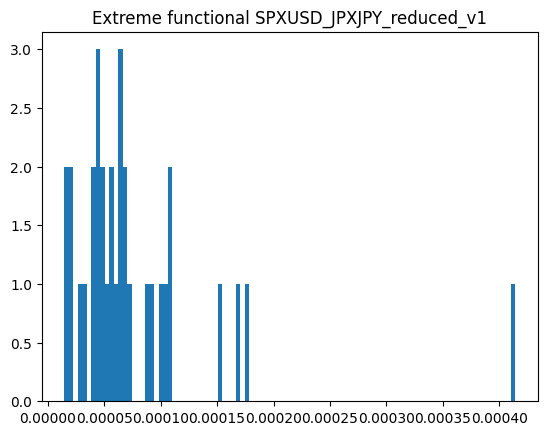

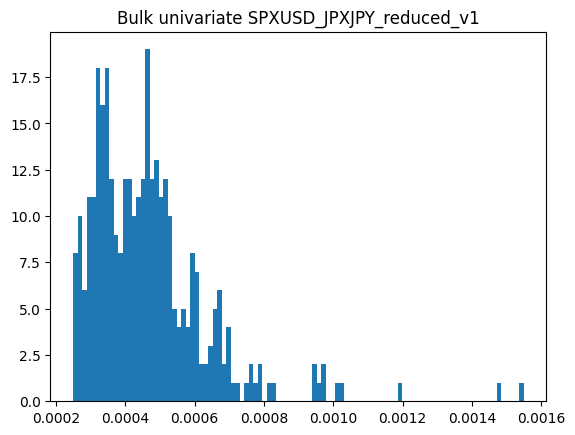

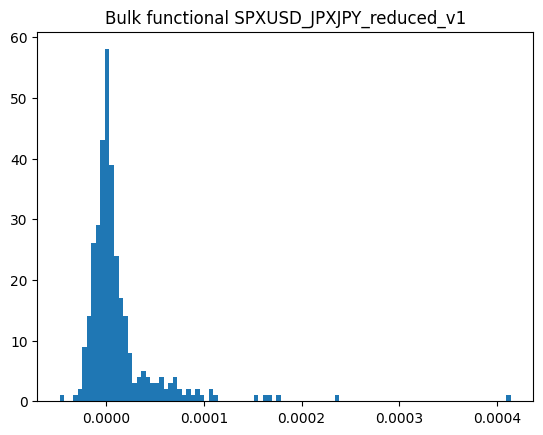

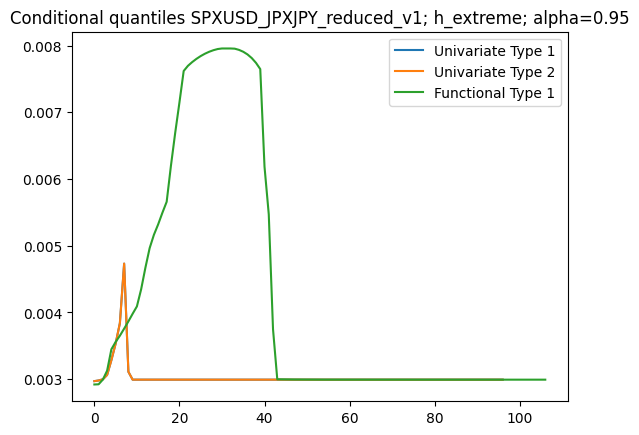

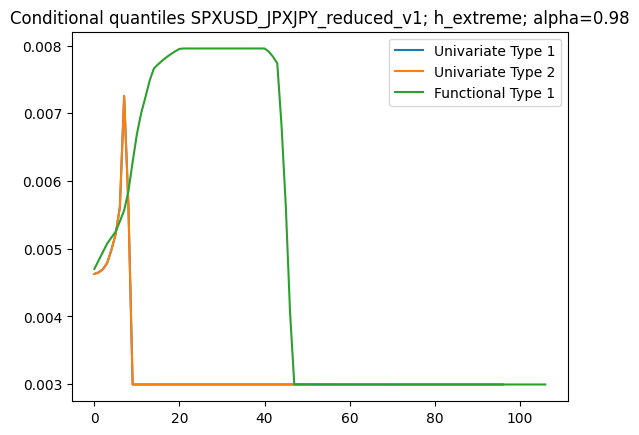

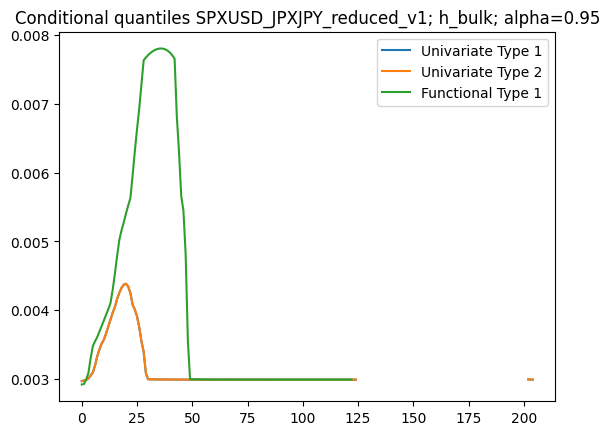

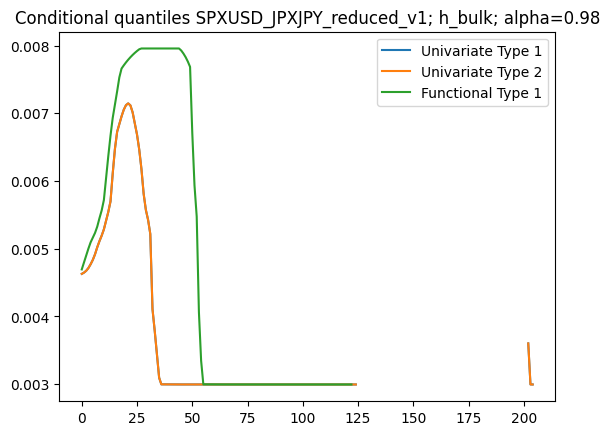

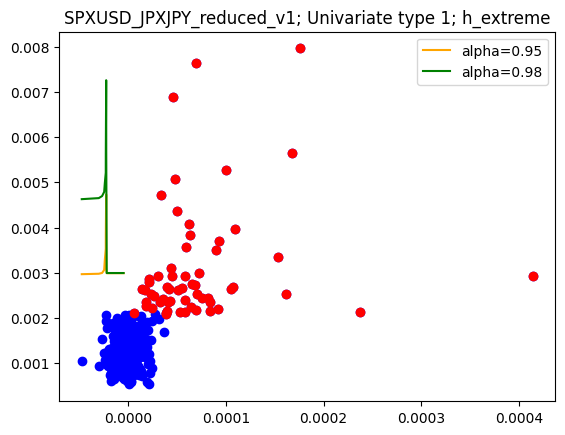

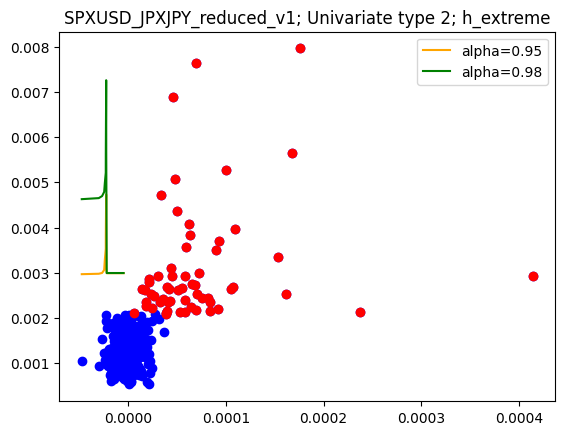

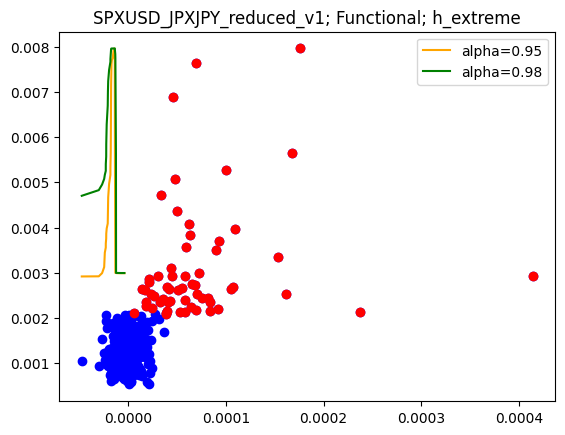

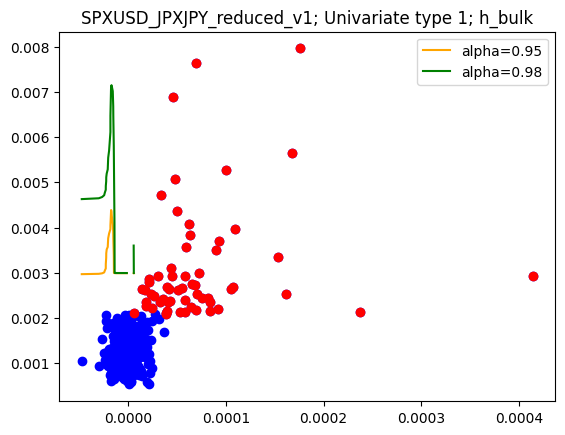

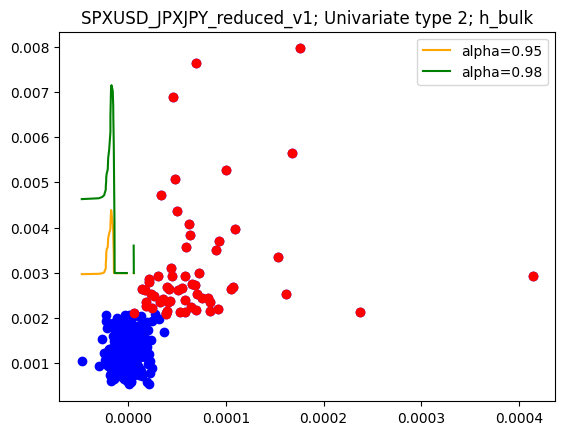

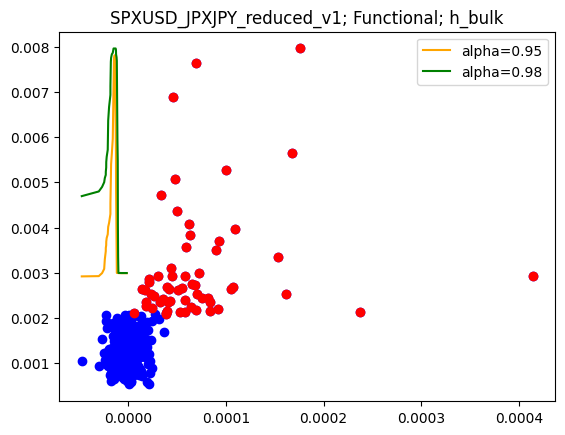

In [9]:
####################### Change time format to match JPXJPY datasets with SPXUSD/JPXJPY/JP datasets (names of columns and timeformat)

X1_2013_SPXUSD_JPXJPY = pd.merge(X1_2013_SPXUSD, X1_2013_JPXJPY, on='date', how='inner')
X1_2014_SPXUSD_JPXJPY = pd.merge(X1_2014_SPXUSD, X1_2014_JPXJPY, on='date', how='inner')
X1_2015_SPXUSD_JPXJPY = pd.merge(X1_2015_SPXUSD, X1_2015_JPXJPY, on='date', how='inner')
X1_2016_SPXUSD_JPXJPY = pd.merge(X1_2016_SPXUSD, X1_2016_JPXJPY, on='date', how='inner')
X1_2017_SPXUSD_JPXJPY = pd.merge(X1_2017_SPXUSD, X1_2017_JPXJPY, on='date', how='inner')

X_2013_SPXUSD_JPXJPY = ((X1_2013_SPXUSD_JPXJPY.values)[:,[4,9]]).astype(float)
X_2014_SPXUSD_JPXJPY = ((X1_2014_SPXUSD_JPXJPY.values)[:,[4,9]]).astype(float)
X_2015_SPXUSD_JPXJPY = ((X1_2015_SPXUSD_JPXJPY.values)[:,[4,9]]).astype(float)
X_2016_SPXUSD_JPXJPY = ((X1_2016_SPXUSD_JPXJPY.values)[:,[4,9]]).astype(float)
X_2017_SPXUSD_JPXJPY = ((X1_2017_SPXUSD_JPXJPY.values)[:,[4,9]]).astype(float)

X_conc_SPXUSD_JPXJPY =np.append(X_2013_SPXUSD_JPXJPY,X_2014_SPXUSD_JPXJPY,axis=0)
X_conc_SPXUSD_JPXJPY =np.append(X_conc_SPXUSD_JPXJPY,X_2015_SPXUSD_JPXJPY,axis=0)
X_conc_SPXUSD_JPXJPY =np.append(X_conc_SPXUSD_JPXJPY,X_2016_SPXUSD_JPXJPY,axis=0)
X_conc_SPXUSD_JPXJPY =np.append(X_conc_SPXUSD_JPXJPY,X_2017_SPXUSD_JPXJPY,axis=0)

X_conc_SPXUSD=X_conc_SPXUSD_JPXJPY[:,0]
X_conc_JPXJPY=X_conc_SPXUSD_JPXJPY[:,1]

X_logreturn_conc2_SPXUSD=np.diff(np.log(X_conc_SPXUSD)) # shape -1
X_logreturn_conc_SPXUSD = np.append(X_logreturn_conc2_SPXUSD[0],X_logreturn_conc2_SPXUSD) # shape +1

X_logreturn_conc2_JPXJPY=np.diff(np.log(X_conc_JPXJPY)) # shape -1
X_logreturn_conc_JPXJPY = np.append(X_logreturn_conc2_JPXJPY[0],X_logreturn_conc2_JPXJPY) # shape +1

SPXUSD_per_day=mesh_time(X_logreturn_conc_SPXUSD,'24h') # shape = (863, 1440) - 863 days with 1440 minutes recorded 
JPXJPY_per_day=mesh_time(X_logreturn_conc_JPXJPY,'24h') # shape = (863, 1440)

SPXUSD_per_day_even=SPXUSD_per_day[::2,:]
JPXJPY_per_day_even=JPXJPY_per_day[::2,:]
SPXUSD_per_day_odd=SPXUSD_per_day[1::2,:]
JPXJPY_per_day_odd=JPXJPY_per_day[1::2,:]

Y_SPXUSD_JPXJPY = np.max(SPXUSD_per_day_odd,axis=1)[1:]
X_SPXUSD_JPXJPY = JPXJPY_per_day_even[:-1,:]

#Y_SPXUSD_JPXJPY = np.max(JPXJPY_per_day_odd,axis=1)[1:]
#X_SPXUSD_JPXJPY = SPXUSD_per_day_even[:-1,:]

X_SPXUSD_JPXJPY=np.expand_dims(X_SPXUSD_JPXJPY,axis=0) # shape (N,n,d) with N=1;n=431;1440
Y_SPXUSD_JPXJPY=np.expand_dims(Y_SPXUSD_JPXJPY,axis=0) # shape (N,n,d) with N=1;n=431;1440

index_to_remove1_SPXUSD_JPXJPY = np.argmax(Y_SPXUSD_JPXJPY,axis=1)
Y_SPXUSD_JPXJPY_new1 = np.expand_dims(np.delete(Y_SPXUSD_JPXJPY[0,:],index_to_remove1_SPXUSD_JPXJPY),axis=0)
X_SPXUSD_JPXJPY_new1=np.delete(X_SPXUSD_JPXJPY,index_to_remove1_SPXUSD_JPXJPY,axis=1)
index_to_remove2_SPXUSD_JPXJPY=np.argmax(Y_SPXUSD_JPXJPY_new1,axis=1)
Y_SPXUSD_JPXJPY_reduced=np.expand_dims(np.delete(Y_SPXUSD_JPXJPY_new1,index_to_remove2_SPXUSD_JPXJPY),axis=0)
X_SPXUSD_JPXJPY_reduced=np.delete(X_SPXUSD_JPXJPY_new1,index_to_remove2_SPXUSD_JPXJPY,axis=1)

N=X_SPXUSD_JPXJPY_reduced.shape[0]
n=X_SPXUSD_JPXJPY_reduced.shape[1]
d=X_SPXUSD_JPXJPY_reduced.shape[2]

print('Data size', n)
max_threshold_SPXUSD_JPXJPY_reduced = int(np.floor(n/5)) # top 20% if n/5, top10% if n/10
min_threshold = 15
tau=1


############################### Correlation and Scatterplot
C0_SPXUSD_JPXJPY_reduced = bitcoin_concomittant_corr(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,tau,max_threshold_SPXUSD_JPXJPY_reduced)
plt.plot(C0_SPXUSD_JPXJPY_reduced)
plt.title('Correlation; tau=1, SPXUSD_JPXJPY_reduced_v1')
plt.show()

ind_reduced=np.argmax(C0_SPXUSD_JPXJPY_reduced[min_threshold:max_threshold_SPXUSD_JPXJPY_reduced])+min_threshold
print('SPXUSD_JPXJPY_reduced_v1 - max corr - index:', C0_SPXUSD_JPXJPY_reduced[ind_reduced], ind_reduced)

############### Hill Plot
G_SPXUSD_JPXJPY_reduced=get_hill_estimator(np.sort(Y_SPXUSD_JPXJPY_reduced[0,:])[::-1])
plt.plot(G_SPXUSD_JPXJPY_reduced)
plt.title('SPXUSD_JPXJPY_reduced_v1; Hill plot')
plt.show()

####################### Exponential Quantile-Quantile Plot
QQ_reduced=Exponential_QQ_Plot_1D(Y_SPXUSD_JPXJPY_reduced,ind_reduced)
x=QQ_reduced[:,0]
y=QQ_reduced[:,1]
res_reduced=linregress(QQ_reduced[:,0],QQ_reduced[:,1])
plt.plot(QQ_reduced[:,0], QQ_reduced[:,1], 'o')
plt.plot(QQ_reduced[:,0], res_reduced.intercept + res_reduced.slope*QQ_reduced[:,0], 'r')
plt.title('Exponential Quantile-Quantile Plot: SPXUSD_JPXJPY_reduced_v1')
print('intermediate_seq k_n is',195)
plt.show()

################################################################# FEPLS
y_matrix_SPXUSD_JPXJPY_reduced = bitcoin_threshold(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,tau,max_threshold_SPXUSD_JPXJPY_reduced,min_threshold)
E0_SPXUSD_JPXJPY_reduced=fepls(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,y_matrix_SPXUSD_JPXJPY_reduced,tau)
F0_SPXUSD_JPXJPY_reduced=hatbeta_dot_X(X_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced)
bti = bitcoin_threshold_index(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,tau,max_threshold_SPXUSD_JPXJPY_reduced,min_threshold)

################################################################# Scatter plot
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
highest_indices_SPXUSD_JPXJPY_reduced= np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-bti:]
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
#plt.savefig('Scatter_SPXUSD500_5_tau_-2_v2.pdf') 
plt.title('SPXUSD_JPXJPY_reduced_v1')
plt.show()

#########################
x=0
a=-1/2
b=1/2
alpha1=0.95
alpha2=0.98
kernel=2 # Gaussian kernel
J=9

#####################################
X_2D = X_SPXUSD_JPXJPY_reduced[0,:,:]
Y_sort_index = np.argsort(Y_SPXUSD_JPXJPY_reduced,axis=1)
x_func = E0_SPXUSD_JPXJPY_reduced[0,:]
#############################
H_extreme=hist_weight_extreme_2D(X_2D,Y_SPXUSD_JPXJPY_reduced,Y_sort_index,x_func,x,tau,max_threshold_SPXUSD_JPXJPY_reduced,min_threshold)
thresholdd = threshold(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,Y_sort_index,tau,max_threshold_SPXUSD_JPXJPY_reduced,min_threshold)
index_to_remove = np.where(Y_SPXUSD_JPXJPY_reduced<=thresholdd)
X_extreme_2D=np.delete(X_2D,index_to_remove,axis=0)
H_total_extreme=hist_weight_extreme_2D_total(X_extreme_2D,x_func,a,b,1440)
#############################
plt.hist(H_extreme[:,0],bins=100)
plt.title('Extreme univariate SPXUSD_JPXJPY_reduced_v1')
plt.show()
plt.hist(H_extreme[:,1],bins=100)
plt.title('Extreme functional SPXUSD_JPXJPY_reduced_v1')
plt.show()
#############################
H_bulk=hist_weight_2D(X_2D,Y_SPXUSD_JPXJPY_reduced,Y_sort_index,x_func,x,tau)
H_total_bulk=hist_weight_2D_total(X_2D,x_func,a,b,1440)
#############################
plt.hist(H_bulk[:,0],bins=100)
plt.title('Bulk univariate SPXUSD_JPXJPY_reduced_v1')
plt.show()
plt.hist(H_bulk[:,1],bins=100)
plt.title('Bulk functional SPXUSD_JPXJPY_reduced_v1')
plt.show()

#########################
x=0
a=0
b=0.05
alpha1=0.95
alpha2=0.98
kernel=2 # Gaussian kernel
J=9
N=X_SPXUSD_JPXJPY_reduced.shape[0]
n=X_SPXUSD_JPXJPY_reduced.shape[1]
d=X_SPXUSD_JPXJPY_reduced.shape[2]
max_threshold_SPXUSD_JPXJPY_reduced = int(n/5)
min_threshold = 15
s1=1
s2=1

#####################################
X_2D = X_SPXUSD_JPXJPY_reduced[0,:,:]
Y_sort_index = np.argsort(Y_SPXUSD_JPXJPY_reduced,axis=1)
x_func = E0_SPXUSD_JPXJPY_reduced[0,:]

#############################
H_extreme=hist_weight_extreme_2D(X_2D,Y_SPXUSD_JPXJPY_reduced,Y_sort_index,x_func,x,tau,max_threshold_SPXUSD_JPXJPY_reduced,min_threshold)
thresholdd = threshold(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,Y_sort_index,tau,max_threshold_SPXUSD_JPXJPY_reduced,min_threshold)
index_to_remove = np.where(Y_SPXUSD_JPXJPY_reduced<=thresholdd)
X_extreme_2D=np.delete(X_2D,index_to_remove,axis=0)
H_total_extreme=hist_weight_extreme_2D_total(X_extreme_2D,x_func,a,b,201)

#############################
plt.hist(H_extreme[:,0],bins=100)
plt.title('Extreme univariate SPXUSD_JPXJPY_reduced_v1')
plt.show()
plt.hist(H_extreme[:,1],bins=100)
plt.title('Extreme functional SPXUSD_JPXJPY_reduced_v1')
plt.show()

#############################
H_bulk=hist_weight_2D(X_2D,Y_SPXUSD_JPXJPY_reduced,Y_sort_index,x_func,x,tau)
H_total_bulk=hist_weight_2D_total(X_2D,x_func,a,b,201)

#############################
plt.hist(H_bulk[:,0],bins=100)
plt.title('Bulk univariate SPXUSD_JPXJPY_reduced_v1')
plt.show()
plt.hist(H_bulk[:,1],bins=100)
plt.title('Bulk functional SPXUSD_JPXJPY_reduced_v1')
plt.show()

############################################# Window/Bandwidth choice
h_vector_extreme = (np.max(H_total_extreme[:,:,0],axis=0)-np.min(H_total_extreme[:,:,0],axis=0))/s1
h_func_vector_extreme = (np.max(H_total_extreme[:,:,1],axis=0)-np.min(H_total_extreme[:,:,1],axis=0))/s2
h_extreme=(np.max(H_extreme[:,0],axis=0)-np.min(H_extreme[:,0],axis=0))/s1
h_func_extreme=(np.max(H_extreme[:,1],axis=0)-np.min(H_extreme[:,1],axis=0))/s2
h_func_2D_extreme=np.transpose(np.outer(h_func_extreme*np.ones(n),np.ones(N))) # of shape (N,n) where A.shape = (n,); e.g., A=h_func*np.ones(n)

h_vector_bulk = (np.max(H_total_bulk[:,:,0],axis=0)-np.min(H_total_bulk[:,:,0],axis=0))/s1
h_func_vector_bulk = (np.max(H_total_bulk[:,:,1],axis=0)-np.min(H_total_bulk[:,:,1],axis=0))/s2
h_bulk=(np.max(H_bulk[:,0],axis=0)-np.min(H_bulk[:,0],axis=0))/s1
h_func_bulk=(np.max(H_bulk[:,1],axis=0)-np.min(H_bulk[:,1],axis=0))/s2
h_func_2D_bulk=np.transpose(np.outer(h_func_bulk*np.ones(n),np.ones(N))) # of shape (N,n) where A.shape = (n,); e.g., A=h_func*np.ones(n)

###############################################################################
# Y|(X,dimred1)=(x*x_func,dimred1) (type 1) vs Y|(X,dimred2) = x (type 2) vs Y|X = x*x_func (type functional)
PP11_extreme=plot_quantile_conditional(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced[0,:],E0_SPXUSD_JPXJPY_reduced[0,:],E0_SPXUSD_JPXJPY_reduced[0,:],alpha1,a,b,n,h_vector_extreme,h_func_vector_extreme,kernel) 
PP12_extreme=plot_quantile_conditional(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced[0,:],E0_SPXUSD_JPXJPY_reduced[0,:],E0_SPXUSD_JPXJPY_reduced[0,:],alpha2,a,b,n,h_vector_extreme,h_func_vector_extreme,kernel) 
PP11_bulk=plot_quantile_conditional(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced[0,:],E0_SPXUSD_JPXJPY_reduced[0,:],E0_SPXUSD_JPXJPY_reduced[0,:],alpha1,a,b,n,h_vector_bulk,h_func_vector_bulk,kernel) 
PP12_bulk=plot_quantile_conditional(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced[0,:],E0_SPXUSD_JPXJPY_reduced[0,:],E0_SPXUSD_JPXJPY_reduced[0,:],alpha2,a,b,n,h_vector_bulk,h_func_vector_bulk,kernel) 

plt.plot(PP11_extreme[:,0],label='Univariate Type 1')
plt.plot(PP11_extreme[:,1],label='Univariate Type 2')
plt.plot(PP11_extreme[:,2],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_JPXJPY_reduced_v1; h_extreme; alpha=0.95')
plt.show()
plt.plot(PP12_extreme[:,0],label='Univariate Type 1')
plt.plot(PP12_extreme[:,1],label='Univariate Type 2')
plt.plot(PP12_extreme[:,2],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_JPXJPY_reduced_v1; h_extreme; alpha=0.98')
plt.show()
plt.plot(PP11_bulk[:,0],label='Univariate Type 1')
plt.plot(PP11_bulk[:,1],label='Univariate Type 2')
plt.plot(PP11_bulk[:,2],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_JPXJPY_reduced_v1; h_bulk; alpha=0.95')
plt.show()
plt.plot(PP12_bulk[:,0],label='Univariate Type 1')
plt.plot(PP12_bulk[:,1],label='Univariate Type 2')
plt.plot(PP12_bulk[:,2],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_JPXJPY_reduced_v1; h_bulk; alpha=0.98')
plt.show()

###############################################################################
offset1=0
offset2=0

plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
highest_indices_SPXUSD_JPXJPY_reduced = np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-bti:]
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset1,  PP11_extreme[:,0], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset2,  PP12_extreme[:,0], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_JPXJPY_reduced_v1; Univariate type 1; h_extreme')
plt.legend()
#plt.savefig('SPXUSD_JPXJPY_reduced_Univariate_type1_h_extreme.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
highest_indices_SPXUSD_JPXJPY_reduced = np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-bti:]
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset1,  PP11_extreme[:,1], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset2,  PP12_extreme[:,1], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_JPXJPY_reduced_v1; Univariate type 2; h_extreme')
plt.legend()
#plt.savefig('SPXUSD_JPXJPY_reduced_Univariate_type2_h_extreme.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
highest_indices_SPXUSD_JPXJPY_reduced = np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-bti:]
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset1,  PP11_extreme[:,2], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset2,  PP12_extreme[:,2], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_JPXJPY_reduced_v1; Functional; h_extreme')
plt.legend()
#plt.savefig('SPXUSD_JPXJPY_reduced_Functional_h_extreme.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
highest_indices_SPXUSD_JPXJPY_reduced = np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-bti:]
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset1,  PP11_bulk[:,0], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset2,  PP12_bulk[:,0], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_JPXJPY_reduced_v1; Univariate type 1; h_bulk')
plt.legend()
#plt.savefig('SPXUSD_JPXJPY_reduced_Univariate_type1_h_bulk.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
highest_indices_SPXUSD_JPXJPY_reduced = np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-bti:]
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset1,  PP11_bulk[:,1], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset2,  PP12_bulk[:,1], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_JPXJPY_reduced_v1; Univariate type 2; h_bulk')
plt.legend()
#plt.savefig('SPXUSD_JPXJPY_reduced_Univariate_type2_h_bulk.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
highest_indices_SPXUSD_JPXJPY_reduced = np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-bti:]
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset1,  PP11_bulk[:,2], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset2,  PP12_bulk[:,2], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_JPXJPY_reduced_v1; Functional; h_bulk')
plt.legend()
#plt.savefig('SPXUSD_JPXJPY_reduced_Functional_h_bulk.pdf')  
plt.show()

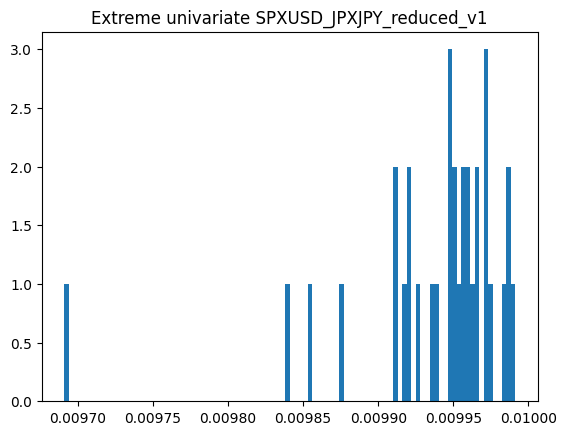

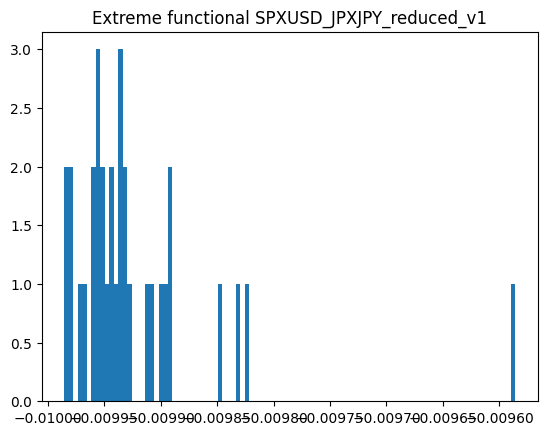

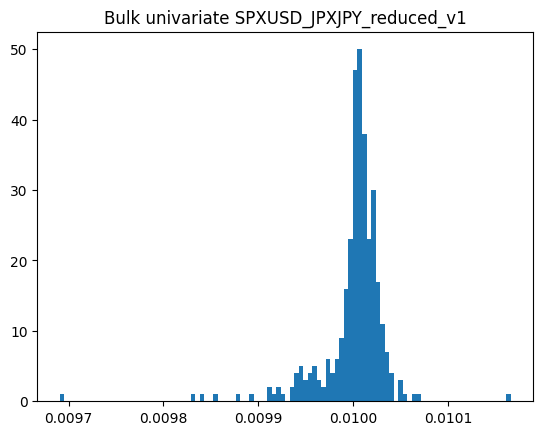

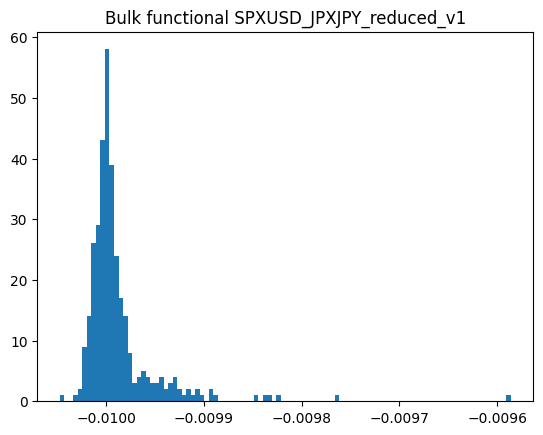

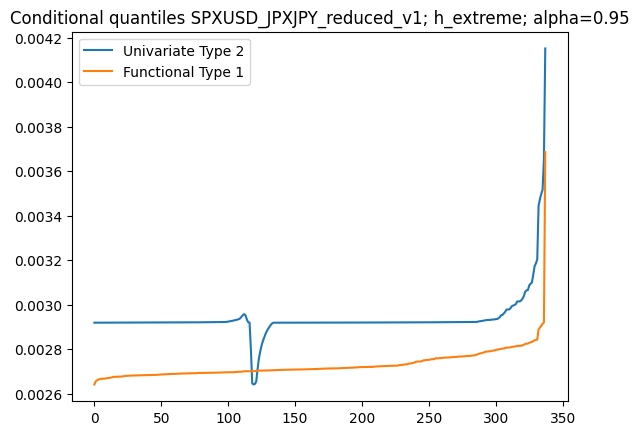

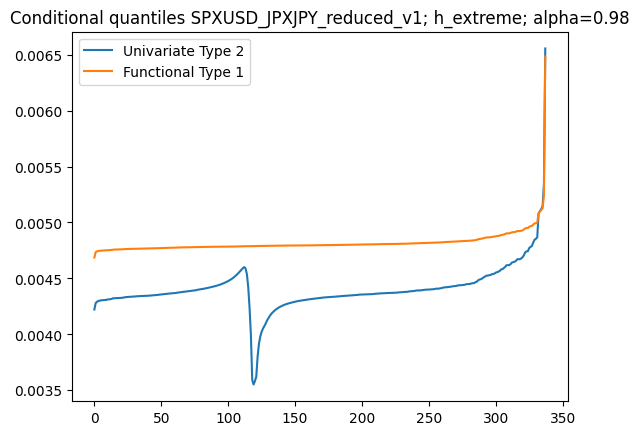

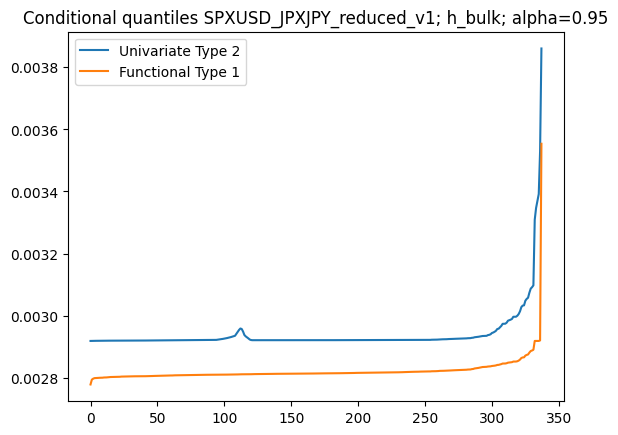

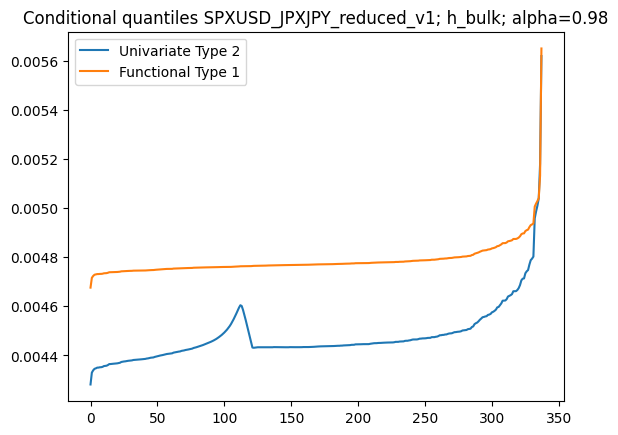

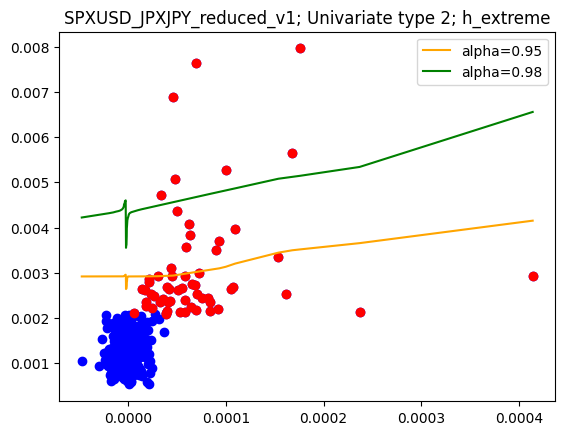

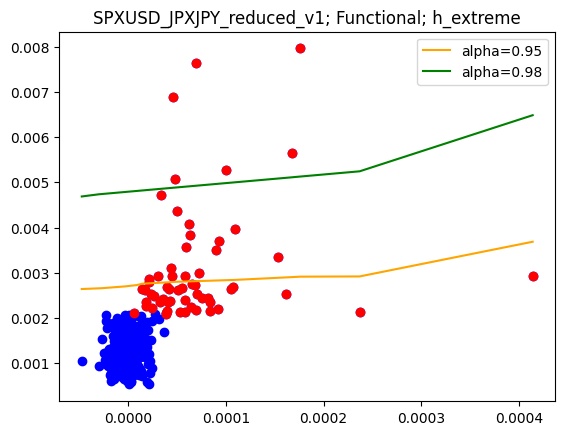

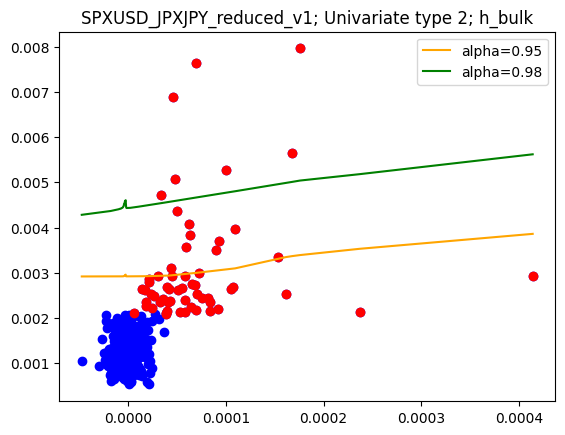

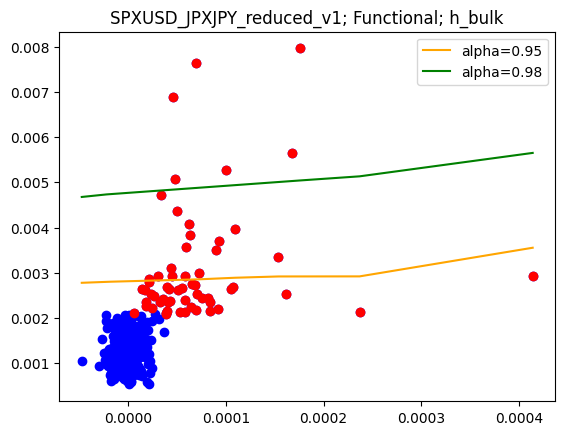

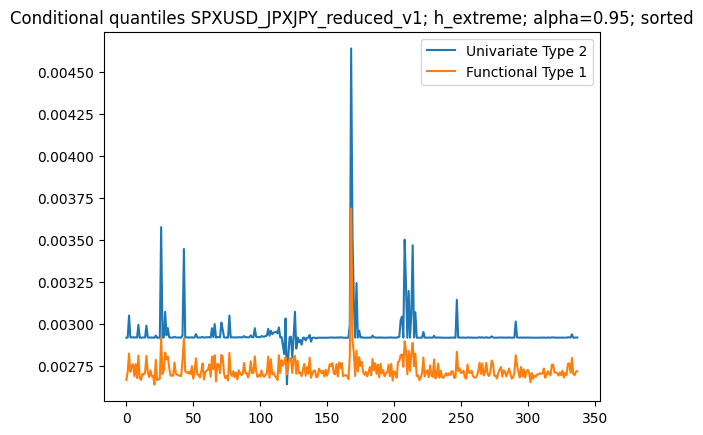

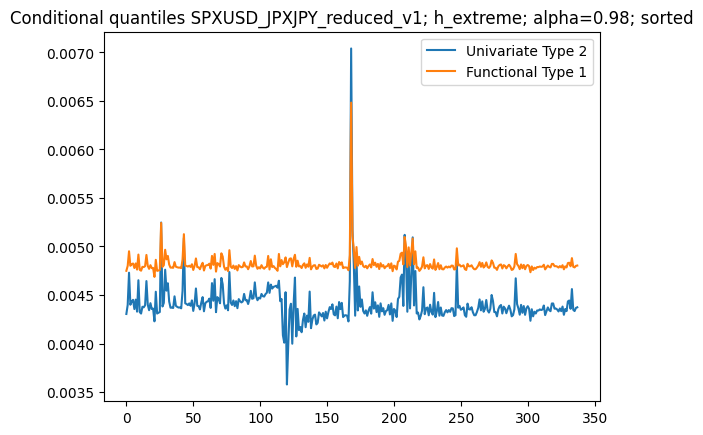

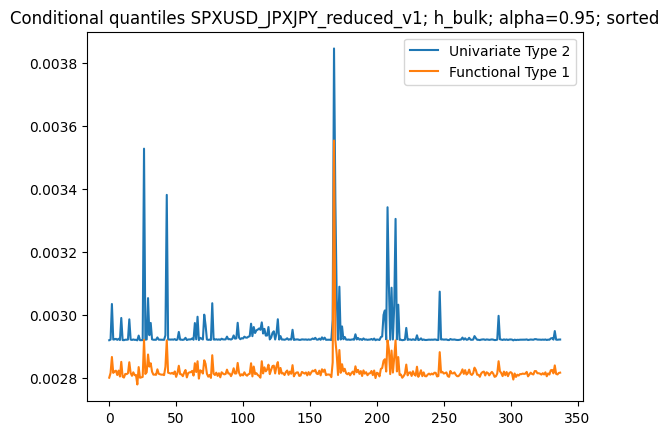

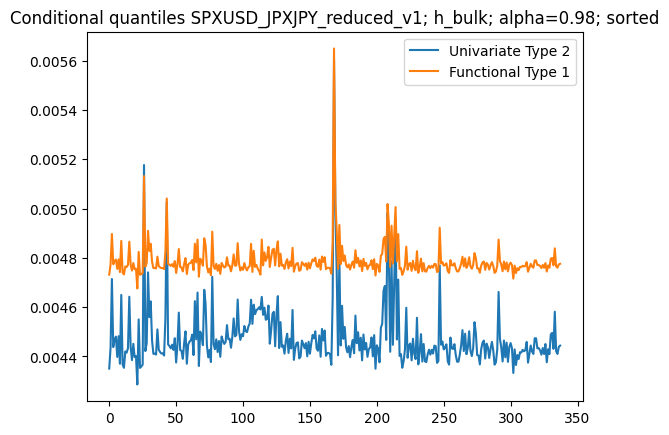

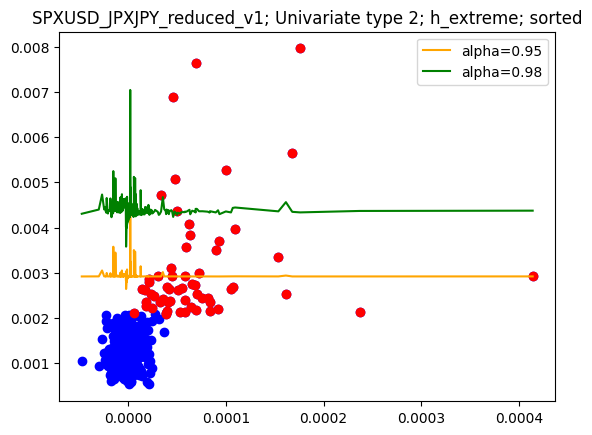

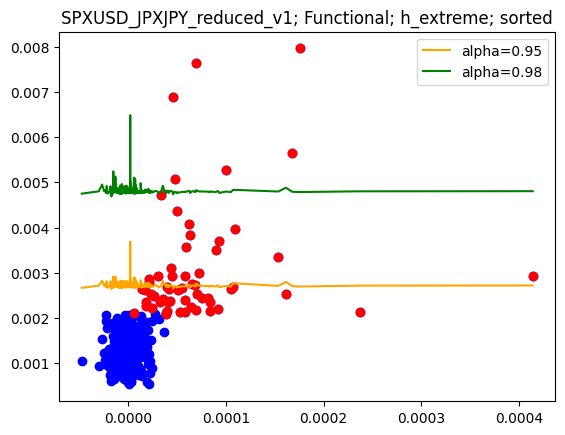

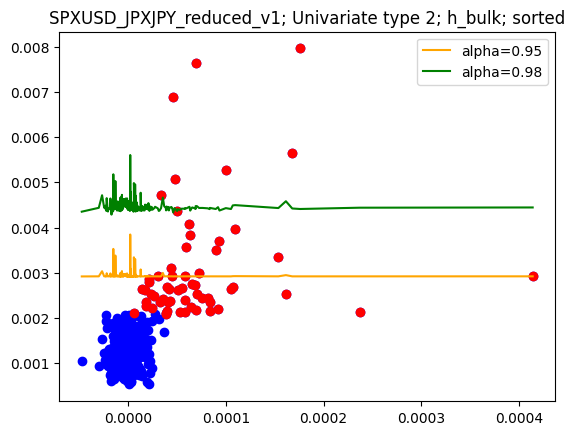

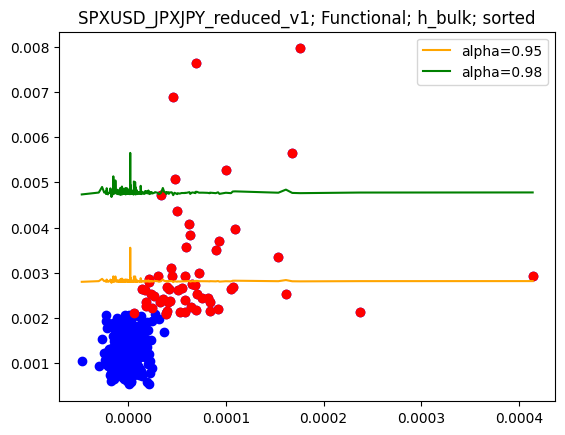

In [10]:

#########################
x=0.01
a=-0.05
b=0.1
alpha1=0.95
alpha2=0.98
kernel=2 # Gaussian kernel
J=9
N=X_SPXUSD_JPXJPY_reduced.shape[0]
n=X_SPXUSD_JPXJPY_reduced.shape[1]
d=X_SPXUSD_JPXJPY_reduced.shape[2]
max_threshold_SPXUSD_JPXJPY_reduced = int(n/5)
min_threshold = 15
s1=2
s2=2

#####################################
X_2D = X_SPXUSD_JPXJPY_reduced[0,:,:]
Y_sort_index = np.argsort(Y_SPXUSD_JPXJPY_reduced,axis=1)
x_func = E0_SPXUSD_JPXJPY_reduced[0,:]

#############################
H_extreme=hist_weight_extreme_2D(X_2D,Y_SPXUSD_JPXJPY_reduced,Y_sort_index,x_func,x,tau,max_threshold_SPXUSD_JPXJPY_reduced,min_threshold)
thresholdd = threshold(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,Y_sort_index,tau,max_threshold_SPXUSD_JPXJPY_reduced,min_threshold)
index_to_remove = np.where(Y_SPXUSD_JPXJPY_reduced<=thresholdd)
X_extreme_2D=np.delete(X_2D,index_to_remove,axis=0)
H_total_extreme=hist_weight_extreme_2D_total(X_extreme_2D,x_func,a,b,n)

#############################
plt.hist(H_extreme[:,0],bins=100)
plt.title('Extreme univariate SPXUSD_JPXJPY_reduced_v1')
plt.show()
plt.hist(H_extreme[:,1],bins=100)
plt.title('Extreme functional SPXUSD_JPXJPY_reduced_v1')
plt.show()

#############################
H_bulk=hist_weight_2D(X_2D,Y_SPXUSD_JPXJPY_reduced,Y_sort_index,x_func,x,tau)
H_total_bulk=hist_weight_2D_total(X_2D,x_func,a,b,n)

#############################
plt.hist(H_bulk[:,0],bins=100)
plt.title('Bulk univariate SPXUSD_JPXJPY_reduced_v1')
plt.show()
plt.hist(H_bulk[:,1],bins=100)
plt.title('Bulk functional SPXUSD_JPXJPY_reduced_v1')
plt.show()

############################################# Window/Bandwidth choice
h_vector_extreme = (np.max(H_total_extreme[:,:,0],axis=0)-np.min(H_total_extreme[:,:,0],axis=0))/s1
h_func_vector_extreme = (np.max(H_total_extreme[:,:,1],axis=0)-np.min(H_total_extreme[:,:,1],axis=0))/s2
h_extreme=(np.max(H_extreme[:,0],axis=0)-np.min(H_extreme[:,0],axis=0))/s1
h_func_extreme=(np.max(H_extreme[:,1],axis=0)-np.min(H_extreme[:,1],axis=0))/s2
h_func_2D_extreme=np.transpose(np.outer(h_func_extreme*np.ones(n),np.ones(N))) # of shape (N,n) where A.shape = (n,); e.g., A=h_func*np.ones(n)

h_vector_bulk = (np.max(H_total_bulk[:,:,0],axis=0)-np.min(H_total_bulk[:,:,0],axis=0))/s1
h_func_vector_bulk = (np.max(H_total_bulk[:,:,1],axis=0)-np.min(H_total_bulk[:,:,1],axis=0))/s2
h_bulk=(np.max(H_bulk[:,0],axis=0)-np.min(H_bulk[:,0],axis=0))/s1
h_func_bulk=(np.max(H_bulk[:,1],axis=0)-np.min(H_bulk[:,1],axis=0))/s2
h_func_2D_bulk=np.transpose(np.outer(h_func_bulk*np.ones(n),np.ones(N))) # of shape (N,n) where A.shape = (n,); e.g., A=h_func*np.ones(n)

###############################################################################
# Y|(X,dimred1)=(x*x_func,dimred1) (type 1) vs Y|(X,dimred2) = x (type 2) vs Y|X = x*x_func (type functional)
covalues = np.sort(np.dot(X_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced[0,:])/d,axis=1)
covalues_sorted = np.dot(X_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced[0,:])/d

PP11_extreme_sample=plot_quantile_conditional_on_sample(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced[0,:],alpha1,covalues,h_vector_extreme,h_func_vector_extreme,kernel) 
PP12_extreme_sample=plot_quantile_conditional_on_sample(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced[0,:],alpha2,covalues,h_vector_extreme,h_func_vector_extreme,kernel)
PP11_bulk_sample=plot_quantile_conditional_on_sample(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced[0,:],alpha1,covalues,h_vector_bulk,h_func_vector_bulk,kernel)
PP12_bulk_sample=plot_quantile_conditional_on_sample(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced[0,:],alpha2,covalues,h_vector_bulk,h_func_vector_bulk,kernel)

plt.plot(PP11_extreme_sample[:,0],label='Univariate Type 2')
plt.plot(PP11_extreme_sample[:,1],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_JPXJPY_reduced_v1; h_extreme; alpha=0.95')
plt.show()
plt.plot(PP12_extreme_sample[:,0],label='Univariate Type 2')
plt.plot(PP12_extreme_sample[:,1],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_JPXJPY_reduced_v1; h_extreme; alpha=0.98')
plt.show()
plt.plot(PP11_bulk_sample[:,0],label='Univariate Type 2')
plt.plot(PP11_bulk_sample[:,1],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_JPXJPY_reduced_v1; h_bulk; alpha=0.95')
plt.show()
plt.plot(PP12_bulk_sample[:,0],label='Univariate Type 2')
plt.plot(PP12_bulk_sample[:,1],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_JPXJPY_reduced_v1; h_bulk; alpha=0.98')
plt.show()

###############################################################################
offset1=0
offset2=0

plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
highest_indices_SPXUSD_JPXJPY_reduced = np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-bti:]
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset1,  PP11_extreme_sample[:,0], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset2,  PP12_extreme_sample[:,0], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_JPXJPY_reduced_v1; Univariate type 2; h_extreme')
plt.legend()
#plt.savefig('SPXUSD_JPXJPY_reduced_Univariate_type2_h_extreme.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
highest_indices_SPXUSD_JPXJPY_reduced = np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-bti:]
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset1,  PP11_extreme_sample[:,1], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset2,  PP12_extreme_sample[:,1], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_JPXJPY_reduced_v1; Functional; h_extreme')
plt.legend()
#plt.savefig('SPXUSD_JPXJPY_reduced_Functional_h_extreme.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
highest_indices_SPXUSD_JPXJPY_reduced = np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-bti:]
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset1,  PP11_bulk_sample[:,0], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset2,  PP12_bulk_sample[:,0], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_JPXJPY_reduced_v1; Univariate type 2; h_bulk')
plt.legend()
#plt.savefig('SPXUSD_JPXJPY_reduced_Univariate_type2_h_bulk.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
highest_indices_SPXUSD_JPXJPY_reduced = np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-bti:]
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset1,  PP11_bulk_sample[:,1], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset2,  PP12_bulk_sample[:,1], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_JPXJPY_reduced_v1; Functional; h_bulk')
plt.legend()
#plt.savefig('SPXUSD_JPXJPY_reduced_Functional_h_bulk.pdf')  
plt.show()

PP11_extreme_sample_sorted=plot_quantile_conditional_on_sample(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced[0,:],alpha1,covalues_sorted,h_vector_extreme,h_func_vector_extreme,kernel) 
PP12_extreme_sample_sorted=plot_quantile_conditional_on_sample(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced[0,:],alpha2,covalues_sorted,h_vector_extreme,h_func_vector_extreme,kernel)
PP11_bulk_sample_sorted=plot_quantile_conditional_on_sample(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced[0,:],alpha1,covalues_sorted,h_vector_bulk,h_func_vector_bulk,kernel)
PP12_bulk_sample_sorted=plot_quantile_conditional_on_sample(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced[0,:],alpha2,covalues_sorted,h_vector_bulk,h_func_vector_bulk,kernel)

plt.plot(PP11_extreme_sample_sorted[:,0],label='Univariate Type 2')
plt.plot(PP11_extreme_sample_sorted[:,1],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_JPXJPY_reduced_v1; h_extreme; alpha=0.95; sorted')
plt.show()
plt.plot(PP12_extreme_sample_sorted[:,0],label='Univariate Type 2')
plt.plot(PP12_extreme_sample_sorted[:,1],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_JPXJPY_reduced_v1; h_extreme; alpha=0.98; sorted')
plt.show()
plt.plot(PP11_bulk_sample_sorted[:,0],label='Univariate Type 2')
plt.plot(PP11_bulk_sample_sorted[:,1],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_JPXJPY_reduced_v1; h_bulk; alpha=0.95; sorted')
plt.show()
plt.plot(PP12_bulk_sample_sorted[:,0],label='Univariate Type 2')
plt.plot(PP12_bulk_sample_sorted[:,1],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_JPXJPY_reduced_v1; h_bulk; alpha=0.98; sorted')
plt.show()

###############################################################################
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
highest_indices_SPXUSD_JPXJPY_reduced = np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-bti:]
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset1,  PP11_extreme_sample_sorted[:,0], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset2,  PP12_extreme_sample_sorted[:,0], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_JPXJPY_reduced_v1; Univariate type 2; h_extreme; sorted')
plt.legend()
#plt.savefig('SPXUSD_JPXJPY_reduced_v1_Univariate_type2_h_extreme_sorted.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
highest_indices_SPXUSD_JPXJPY_reduced = np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-bti:]
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset1,  PP11_extreme_sample_sorted[:,1], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset2,  PP12_extreme_sample_sorted[:,1], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_JPXJPY_reduced_v1; Functional; h_extreme; sorted')
plt.legend()
#plt.savefig('SPXUSD_JPXJPY_reduced_v1_Functional_h_extreme_sorted.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
highest_indices_SPXUSD_JPXJPY_reduced = np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-bti:]
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset1,  PP11_bulk_sample_sorted[:,0], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset2,  PP12_bulk_sample_sorted[:,0], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_JPXJPY_reduced_v1; Univariate type 2; h_bulk; sorted')
plt.legend()
#plt.savefig('SPXUSD_JPXJPY_reduced_v1_Univariate_type2_h_bulk_sorted.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
highest_indices_SPXUSD_JPXJPY_reduced = np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-bti:]
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset1,  PP11_bulk_sample_sorted[:,1], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset2,  PP12_bulk_sample_sorted[:,1], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_JPXJPY_reduced_v1; Functional; h_bulk; sorted')
plt.legend()
#plt.savefig('SPXUSD_JPXJPY_reduced_v1_Functional_h_bulk_sorted.pdf')  
plt.show()

The bandwidth h for the following plots is 0.004


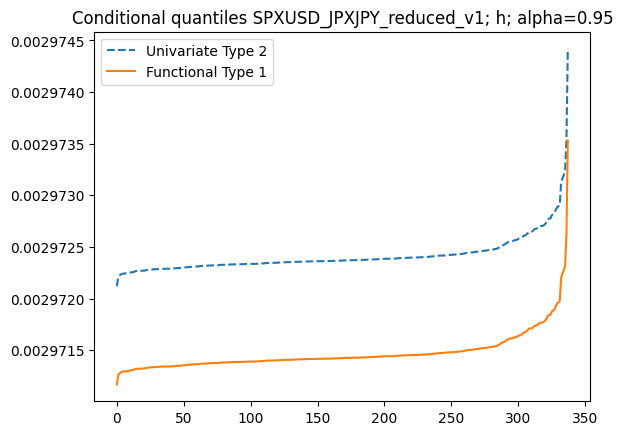

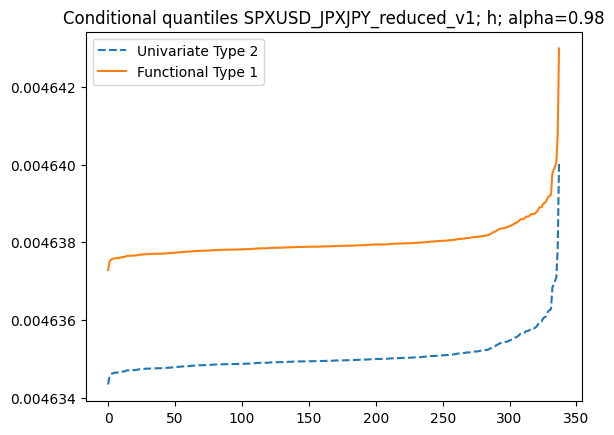

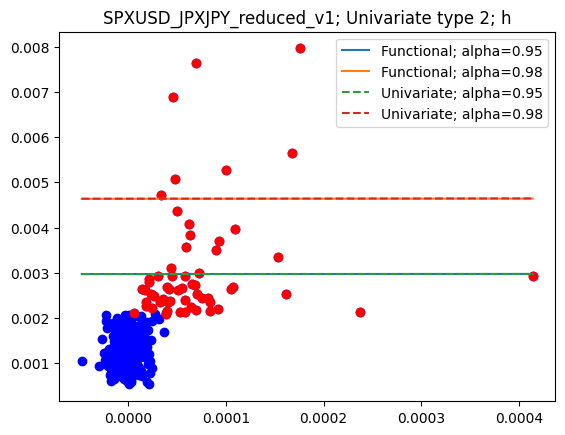

In [11]:
@numba.njit(parallel=True, fastmath=False) 
def plot_quantile_conditional_on_sample2(X,Y,dimred,covalues,x_func,alpha,h_vector,h_func_vector,kernel): 
    # X of shape (N,n,d) and Y of shape (N,n) with N=1;n=...;d=1440
    # covalues=np.dot(X_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced[0,:])/d   # shape = (N,n) = (1,431) family of (<X_i,dimred>)_{1\le i \le n} avec dimred \in H de taille (d,)=(1440)
    # dimred of shape (d,), e.g., dimred = E0[0,:] with E0 = fepls(X,Y,y_matrix,tau)
    # h_vector.shape = h_func_vector.shape = (n,)
    # Functional: X = x_func \in H; Univariate (type 2): <X,dimred>=covalues\in \R with covalues=<X_i,x_func> for 1 \le i \le n.   
    # x_func is a generical function/vector of shape (d,) and dimred is the FEPLS, i.e., E0[0,:] also of shape (d,)
    n=Y.shape[1]
    out = np.zeros((n,2))
    for p in numba.prange(n):
        weight2=univariate_Nadaraya_weight_2D(X[0,:,:],dimred,dimred,covalues[0,p],h_vector[p],2,kernel)
        weight_func=functional_Nadaraya_weight_2D(X[0,:,:],covalues[0,p]*dimred,h_func_vector[p],kernel)
        out[p,0]=weighted_quantile(Y[0,:],weight2,alpha)
        out[p,1]=weighted_quantile(Y[0,:],weight_func,alpha)
    return out

#########################

alpha1=0.95
alpha2=0.98
kernel=2 # Gaussian kernel
J=9

N=X_SPXUSD_JPXJPY_reduced.shape[0]
n=X_SPXUSD_JPXJPY_reduced.shape[1]
d=X_SPXUSD_JPXJPY_reduced.shape[2]

##############################################################################
# Y|(X,dimred) = covalues (type univariate) vs Y|X = x_func (type functional)

dimred = E0_SPXUSD_JPXJPY_reduced[0,:] # of shape (d,)
x_func = E0_SPXUSD_JPXJPY_reduced[0,:] # of shape (d,)
covalues = np.sort(np.dot(X_SPXUSD_JPXJPY_reduced,x_func)/d,axis=1)

##############################################################

H_grid=[0.004] #np.linspace(0.0002,0.004,51)

for h in H_grid:
    h_vector = h*np.ones((n,))
    h_func_vector = h*np.ones((n,))
    
    PP11_sample=plot_quantile_conditional_on_sample2(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,dimred,covalues,x_func,alpha1,h_vector,h_func_vector,kernel) 
    PP12_sample=plot_quantile_conditional_on_sample2(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,dimred,covalues,x_func,alpha2,h_vector,h_func_vector,kernel)
    print('The bandwidth h for the following plots is',h) 
    plt.plot(PP11_sample[:,0], linestyle='dashed', label='Univariate Type 2')
    plt.plot(PP11_sample[:,1], label='Functional Type 1')
    plt.legend()
    plt.title('Conditional quantiles SPXUSD_JPXJPY_reduced_v1; h; alpha=0.95')
    plt.show()
    plt.plot(PP12_sample[:,0], linestyle='dashed', label='Univariate Type 2')
    plt.plot(PP12_sample[:,1],label='Functional Type 1')
    plt.legend()
    plt.title('Conditional quantiles SPXUSD_JPXJPY_reduced_v1; h; alpha=0.98')
    plt.show()
    ###########################################################
    offset1=0
    offset2=0
    plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
    highest_indices_SPXUSD_JPXJPY_reduced = np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-bti:]
    plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
    plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset1,  PP11_sample[:,1],  label='Functional; alpha=0.95')
    plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset2,  PP12_sample[:,1],  label='Functional; alpha=0.98')
    plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset1,  PP11_sample[:,0],  linestyle='dashed',label='Univariate; alpha=0.95')
    plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset2,  PP12_sample[:,0],  linestyle='dashed',label='Univariate; alpha=0.98')
    #plt.xlim(-0.02, 0.03) 
    #plt.ylim(-0.01, 0.22) 
    plt.title('SPXUSD_JPXJPY_reduced_v1')
    plt.legend()
    #plt.savefig('SPXUSD_JPXJPY_reduced_Univariate_type2_h.pdf')  
    plt.show()



Data size 338


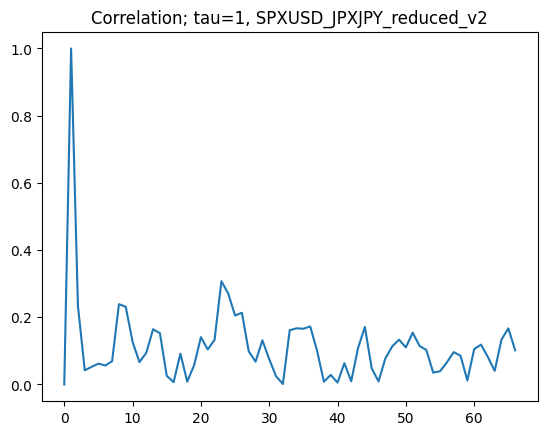

SPXUSD_JPXJPY_reduced_v2 - max corr - index: 0.30738320191383783 23


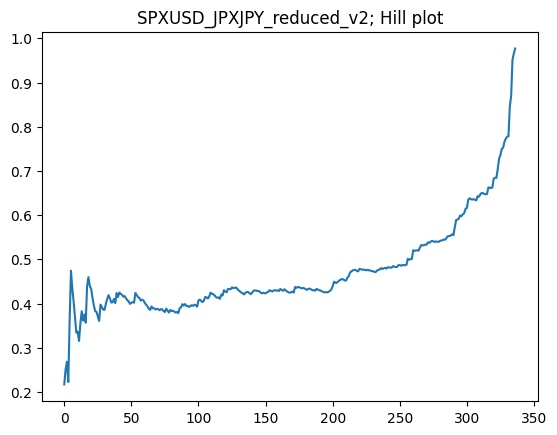

intermediate_seq k_n is 65


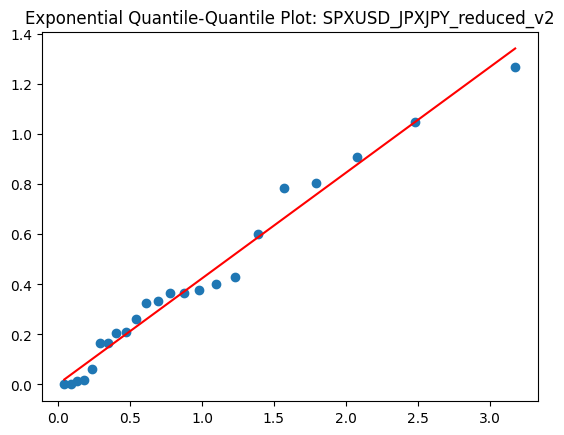

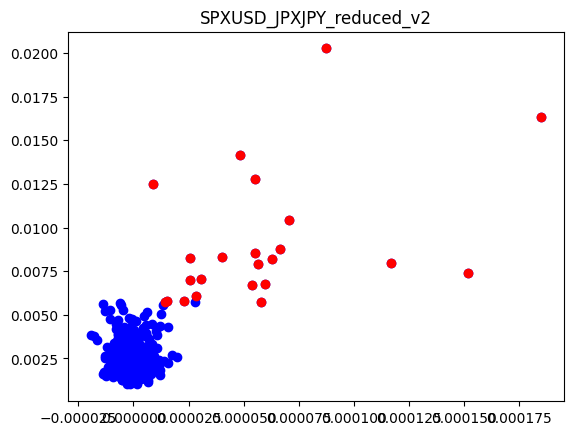

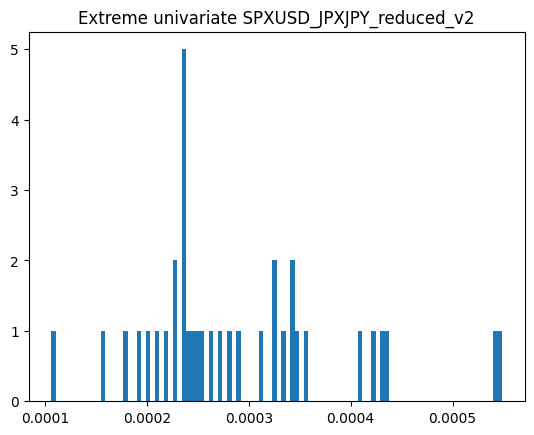

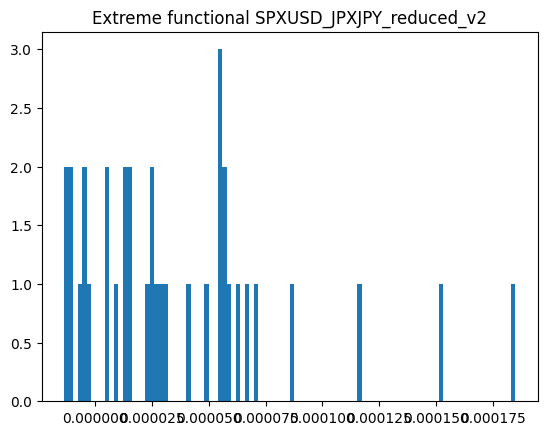

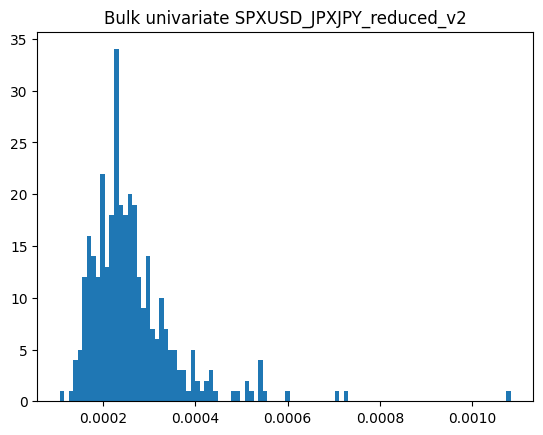

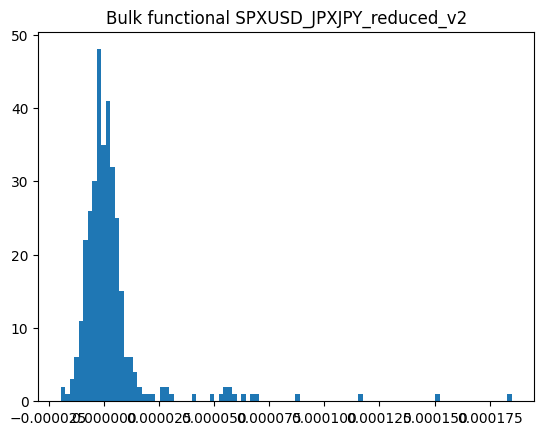

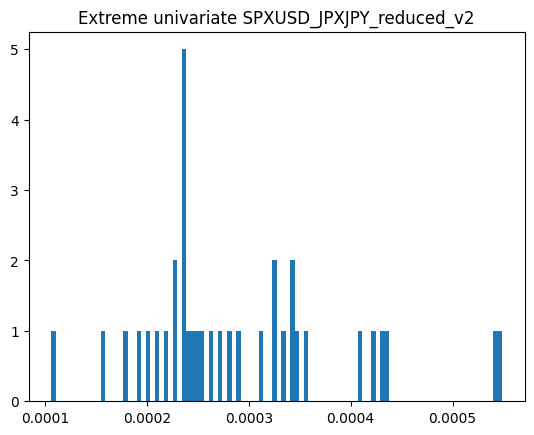

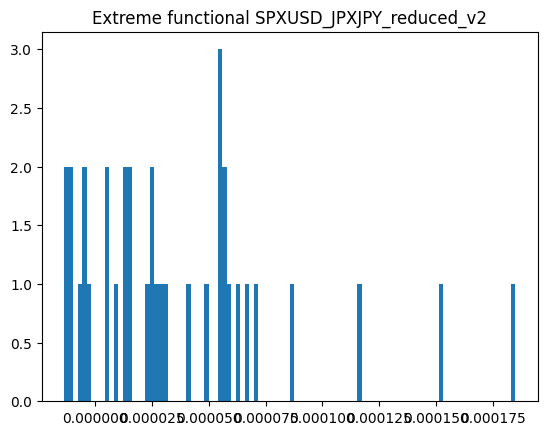

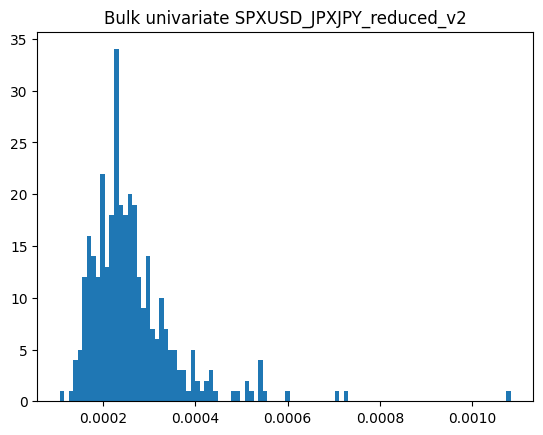

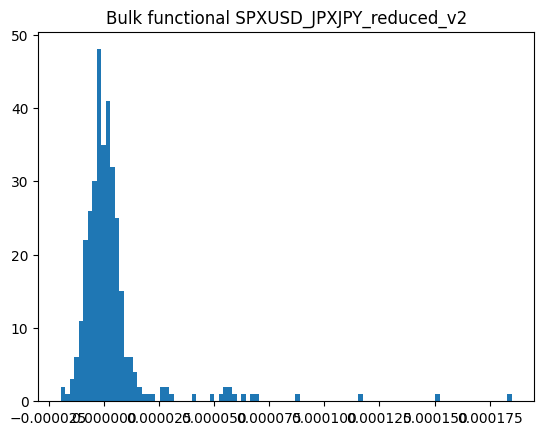

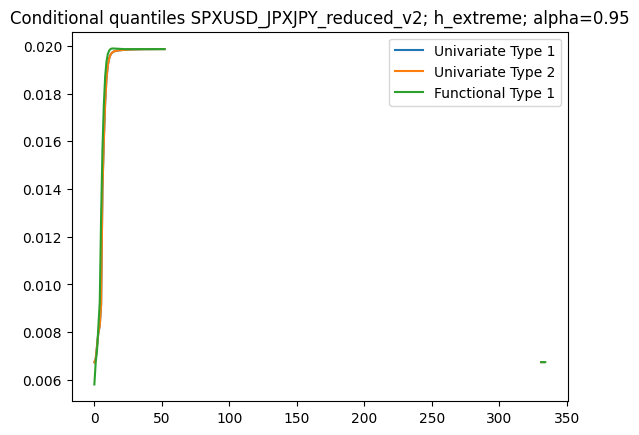

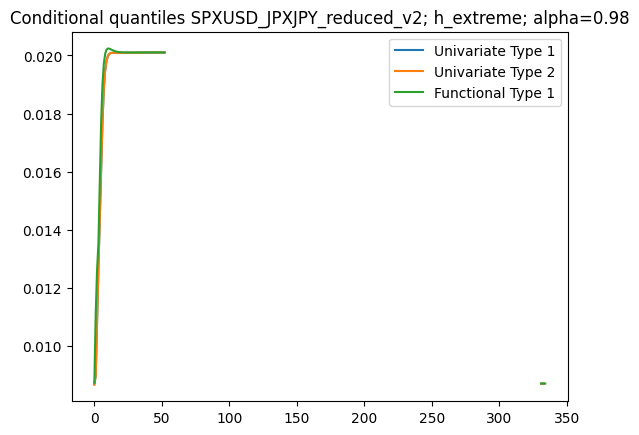

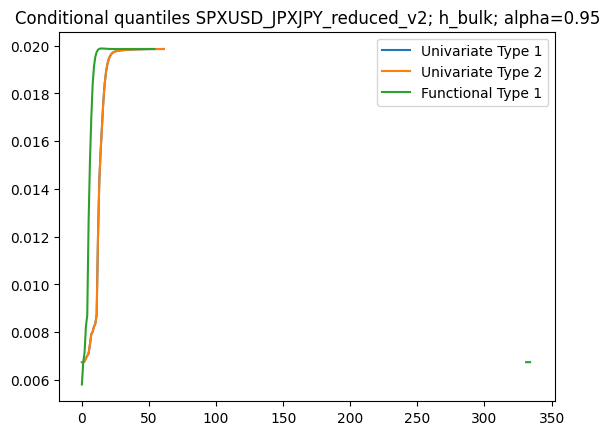

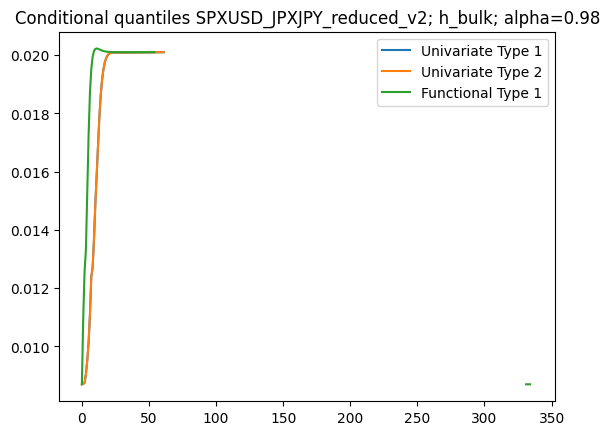

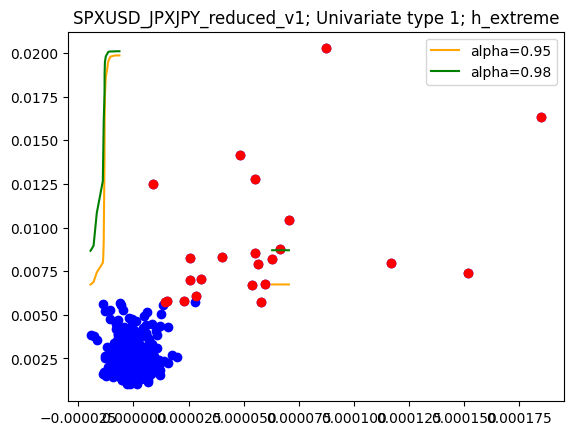

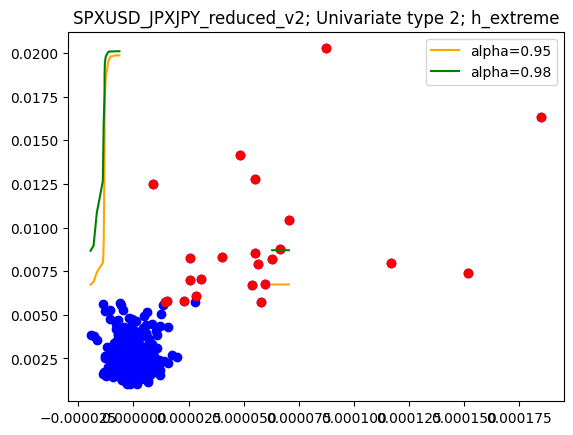

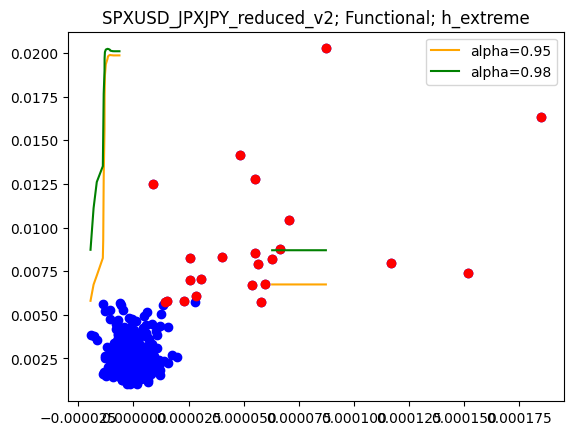

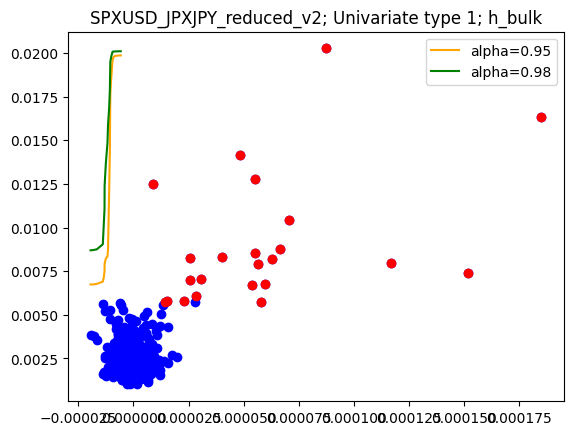

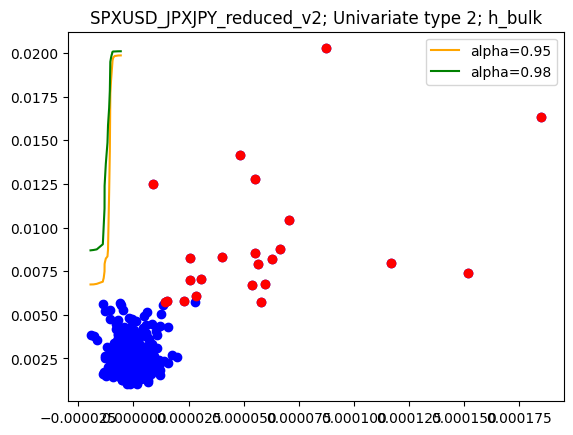

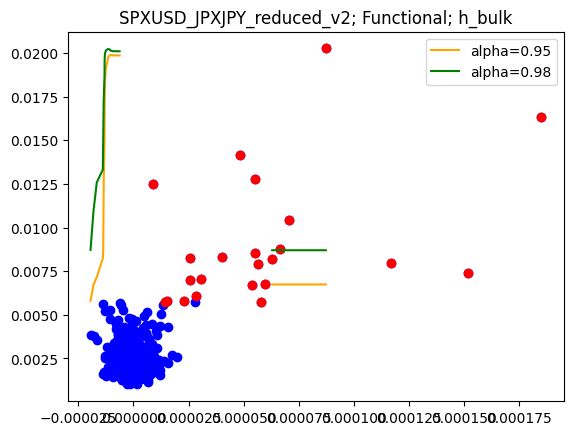

In [12]:
####################### Change time format to match JPXJPY datasets with SPXUSD/JPXJPY/JP datasets (names of columns and timeformat)

X1_2013_SPXUSD_JPXJPY = pd.merge(X1_2013_SPXUSD, X1_2013_JPXJPY, on='date', how='inner')
X1_2014_SPXUSD_JPXJPY = pd.merge(X1_2014_SPXUSD, X1_2014_JPXJPY, on='date', how='inner')
X1_2015_SPXUSD_JPXJPY = pd.merge(X1_2015_SPXUSD, X1_2015_JPXJPY, on='date', how='inner')
X1_2016_SPXUSD_JPXJPY = pd.merge(X1_2016_SPXUSD, X1_2016_JPXJPY, on='date', how='inner')
X1_2017_SPXUSD_JPXJPY = pd.merge(X1_2017_SPXUSD, X1_2017_JPXJPY, on='date', how='inner')

X_2013_SPXUSD_JPXJPY = ((X1_2013_SPXUSD_JPXJPY.values)[:,[4,9]]).astype(float)
X_2014_SPXUSD_JPXJPY = ((X1_2014_SPXUSD_JPXJPY.values)[:,[4,9]]).astype(float)
X_2015_SPXUSD_JPXJPY = ((X1_2015_SPXUSD_JPXJPY.values)[:,[4,9]]).astype(float)
X_2016_SPXUSD_JPXJPY = ((X1_2016_SPXUSD_JPXJPY.values)[:,[4,9]]).astype(float)
X_2017_SPXUSD_JPXJPY = ((X1_2017_SPXUSD_JPXJPY.values)[:,[4,9]]).astype(float)

X_conc_SPXUSD_JPXJPY =np.append(X_2013_SPXUSD_JPXJPY,X_2014_SPXUSD_JPXJPY,axis=0)
X_conc_SPXUSD_JPXJPY =np.append(X_conc_SPXUSD_JPXJPY,X_2015_SPXUSD_JPXJPY,axis=0)
X_conc_SPXUSD_JPXJPY =np.append(X_conc_SPXUSD_JPXJPY,X_2016_SPXUSD_JPXJPY,axis=0)
X_conc_SPXUSD_JPXJPY =np.append(X_conc_SPXUSD_JPXJPY,X_2017_SPXUSD_JPXJPY,axis=0)

X_conc_SPXUSD=X_conc_SPXUSD_JPXJPY[:,0]
X_conc_JPXJPY=X_conc_SPXUSD_JPXJPY[:,1]

X_logreturn_conc2_SPXUSD=np.diff(np.log(X_conc_SPXUSD)) # shape -1
X_logreturn_conc_SPXUSD = np.append(X_logreturn_conc2_SPXUSD[0],X_logreturn_conc2_SPXUSD) # shape +1

X_logreturn_conc2_JPXJPY=np.diff(np.log(X_conc_JPXJPY)) # shape -1
X_logreturn_conc_JPXJPY = np.append(X_logreturn_conc2_JPXJPY[0],X_logreturn_conc2_JPXJPY) # shape +1

SPXUSD_per_day=mesh_time(X_logreturn_conc_SPXUSD,'24h') # shape = (863, 1440) - 863 days with 1440 minutes recorded 
JPXJPY_per_day=mesh_time(X_logreturn_conc_JPXJPY,'24h') # shape = (863, 1440)

SPXUSD_per_day_even=SPXUSD_per_day[::2,:]
JPXJPY_per_day_even=JPXJPY_per_day[::2,:]
SPXUSD_per_day_odd=SPXUSD_per_day[1::2,:]
JPXJPY_per_day_odd=JPXJPY_per_day[1::2,:]

#Y_SPXUSD_JPXJPY = np.max(SPXUSD_per_day_odd,axis=1)[1:]
#X_SPXUSD_JPXJPY = JPXJPY_per_day_even[:-1,:]

Y_SPXUSD_JPXJPY = np.max(JPXJPY_per_day_odd,axis=1)[1:]
X_SPXUSD_JPXJPY = SPXUSD_per_day_even[:-1,:]

X_SPXUSD_JPXJPY=np.expand_dims(X_SPXUSD_JPXJPY,axis=0) # shape (N,n,d) with N=1;n=431;1440
Y_SPXUSD_JPXJPY=np.expand_dims(Y_SPXUSD_JPXJPY,axis=0) # shape (N,n,d) with N=1;n=431;1440

index_to_remove1_SPXUSD_JPXJPY = np.argmax(Y_SPXUSD_JPXJPY,axis=1)
Y_SPXUSD_JPXJPY_new1 = np.expand_dims(np.delete(Y_SPXUSD_JPXJPY[0,:],index_to_remove1_SPXUSD_JPXJPY),axis=0)
X_SPXUSD_JPXJPY_new1=np.delete(X_SPXUSD_JPXJPY,index_to_remove1_SPXUSD_JPXJPY,axis=1)
index_to_remove2_SPXUSD_JPXJPY=np.argmax(Y_SPXUSD_JPXJPY_new1,axis=1)
Y_SPXUSD_JPXJPY_reduced=np.expand_dims(np.delete(Y_SPXUSD_JPXJPY_new1,index_to_remove2_SPXUSD_JPXJPY),axis=0)
X_SPXUSD_JPXJPY_reduced=np.delete(X_SPXUSD_JPXJPY_new1,index_to_remove2_SPXUSD_JPXJPY,axis=1)

N=X_SPXUSD_JPXJPY_reduced.shape[0]
n=X_SPXUSD_JPXJPY_reduced.shape[1]
d=X_SPXUSD_JPXJPY_reduced.shape[2]

print('Data size', n)
max_threshold_SPXUSD_JPXJPY_reduced = int(np.floor(n/5)) # top 20% if n/5, top10% if n/10
min_threshold = 15
tau=1


############################### Correlation and Scatterplot
C0_SPXUSD_JPXJPY_reduced = bitcoin_concomittant_corr(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,tau,max_threshold_SPXUSD_JPXJPY_reduced)
plt.plot(C0_SPXUSD_JPXJPY_reduced)
plt.title('Correlation; tau=1, SPXUSD_JPXJPY_reduced_v2')
plt.show()

ind_reduced=np.argmax(C0_SPXUSD_JPXJPY_reduced[min_threshold:max_threshold_SPXUSD_JPXJPY_reduced])+min_threshold
print('SPXUSD_JPXJPY_reduced_v2 - max corr - index:', C0_SPXUSD_JPXJPY_reduced[ind_reduced], ind_reduced)

############### Hill Plot
G_SPXUSD_JPXJPY_reduced=get_hill_estimator(np.sort(Y_SPXUSD_JPXJPY_reduced[0,:])[::-1])
plt.plot(G_SPXUSD_JPXJPY_reduced[:index_min])
plt.title('SPXUSD_JPXJPY_reduced_v2; Hill plot')
plt.show()

####################### Exponential Quantile-Quantile Plot
QQ_reduced=Exponential_QQ_Plot_1D(Y_SPXUSD_JPXJPY_reduced,ind_reduced)
x=QQ_reduced[:,0]
y=QQ_reduced[:,1]
res_reduced=linregress(QQ_reduced[:,0],QQ_reduced[:,1])
plt.plot(QQ_reduced[:,0], QQ_reduced[:,1], 'o')
plt.plot(QQ_reduced[:,0], res_reduced.intercept + res_reduced.slope*QQ_reduced[:,0], 'r')
plt.title('Exponential Quantile-Quantile Plot: SPXUSD_JPXJPY_reduced_v2')
print('intermediate_seq k_n is',65)
plt.show()

################################################################# FEPLS
y_matrix_SPXUSD_JPXJPY_reduced = bitcoin_threshold(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,tau,max_threshold_SPXUSD_JPXJPY_reduced,min_threshold)
E0_SPXUSD_JPXJPY_reduced=fepls(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,y_matrix_SPXUSD_JPXJPY_reduced,tau)
F0_SPXUSD_JPXJPY_reduced=hatbeta_dot_X(X_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced)
bti = bitcoin_threshold_index(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,tau,max_threshold_SPXUSD_JPXJPY_reduced,min_threshold)

################################################################# Scatter plot
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
highest_indices_SPXUSD_JPXJPY_reduced= np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-bti:]
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
#plt.savefig('Scatter_SPXUSD500_5_tau_-2_v2.pdf') 
plt.title('SPXUSD_JPXJPY_reduced_v2')
plt.show()

#########################
x=0
a=-0.00005*2
b=0.00025*2
alpha1=0.95
alpha2=0.98
kernel=2 # Gaussian kernel
J=9


#####################################
X_2D = X_SPXUSD_JPXJPY_reduced[0,:,:]
Y_sort_index = np.argsort(Y_SPXUSD_JPXJPY_reduced,axis=1)
x_func = E0_SPXUSD_JPXJPY_reduced[0,:]
#############################
H_extreme=hist_weight_extreme_2D(X_2D,Y_SPXUSD_JPXJPY_reduced,Y_sort_index,x_func,x,tau,max_threshold_SPXUSD_JPXJPY_reduced,min_threshold)
thresholdd = threshold(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,Y_sort_index,tau,max_threshold_SPXUSD_JPXJPY_reduced,min_threshold)
index_to_remove = np.where(Y_SPXUSD_JPXJPY_reduced<=thresholdd)
X_extreme_2D=np.delete(X_2D,index_to_remove,axis=0)
H_total_extreme=hist_weight_extreme_2D_total(X_extreme_2D,x_func,a,b,1440)
#############################
plt.hist(H_extreme[:,0],bins=100)
plt.title('Extreme univariate SPXUSD_JPXJPY_reduced_v2')
plt.show()
plt.hist(H_extreme[:,1],bins=100)
plt.title('Extreme functional SPXUSD_JPXJPY_reduced_v2')
plt.show()
#############################
H_bulk=hist_weight_2D(X_2D,Y_SPXUSD_JPXJPY_reduced,Y_sort_index,x_func,x,tau)
H_total_bulk=hist_weight_2D_total(X_2D,x_func,a,b,1440)
#############################
plt.hist(H_bulk[:,0],bins=100)
plt.title('Bulk univariate SPXUSD_JPXJPY_reduced_v2')
plt.show()
plt.hist(H_bulk[:,1],bins=100)
plt.title('Bulk functional SPXUSD_JPXJPY_reduced_v2')
plt.show()

#########################
x=0
a=0
b=0.05
alpha1=0.95
alpha2=0.98
kernel=2 # Gaussian kernel
J=9
N=X_SPXUSD_JPXJPY_reduced.shape[0]
n=X_SPXUSD_JPXJPY_reduced.shape[1]
d=X_SPXUSD_JPXJPY_reduced.shape[2]
max_threshold_SPXUSD_JPXJPY_reduced = int(n/5)
min_threshold = 15
s1=1
s2=1

#####################################
X_2D = X_SPXUSD_JPXJPY_reduced[0,:,:]
Y_sort_index = np.argsort(Y_SPXUSD_JPXJPY_reduced,axis=1)
x_func = E0_SPXUSD_JPXJPY_reduced[0,:]

#############################
H_extreme=hist_weight_extreme_2D(X_2D,Y_SPXUSD_JPXJPY_reduced,Y_sort_index,x_func,x,tau,max_threshold_SPXUSD_JPXJPY_reduced,min_threshold)
thresholdd = threshold(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,Y_sort_index,tau,max_threshold_SPXUSD_JPXJPY_reduced,min_threshold)
index_to_remove = np.where(Y_SPXUSD_JPXJPY_reduced<=thresholdd)
X_extreme_2D=np.delete(X_2D,index_to_remove,axis=0)
H_total_extreme=hist_weight_extreme_2D_total(X_extreme_2D,x_func,a,b,201)

#############################
plt.hist(H_extreme[:,0],bins=100)
plt.title('Extreme univariate SPXUSD_JPXJPY_reduced_v2')
plt.show()
plt.hist(H_extreme[:,1],bins=100)
plt.title('Extreme functional SPXUSD_JPXJPY_reduced_v2')
plt.show()

#############################
H_bulk=hist_weight_2D(X_2D,Y_SPXUSD_JPXJPY_reduced,Y_sort_index,x_func,x,tau)
H_total_bulk=hist_weight_2D_total(X_2D,x_func,a,b,201)

#############################
plt.hist(H_bulk[:,0],bins=100)
plt.title('Bulk univariate SPXUSD_JPXJPY_reduced_v2')
plt.show()
plt.hist(H_bulk[:,1],bins=100)
plt.title('Bulk functional SPXUSD_JPXJPY_reduced_v2')
plt.show()

############################################# Window/Bandwidth choice
h_vector_extreme = (np.max(H_total_extreme[:,:,0],axis=0)-np.min(H_total_extreme[:,:,0],axis=0))/s1
h_func_vector_extreme = (np.max(H_total_extreme[:,:,1],axis=0)-np.min(H_total_extreme[:,:,1],axis=0))/s2
h_extreme=(np.max(H_extreme[:,0],axis=0)-np.min(H_extreme[:,0],axis=0))/s1
h_func_extreme=(np.max(H_extreme[:,1],axis=0)-np.min(H_extreme[:,1],axis=0))/s2
h_func_2D_extreme=np.transpose(np.outer(h_func_extreme*np.ones(n),np.ones(N))) # of shape (N,n) where A.shape = (n,); e.g., A=h_func*np.ones(n)

h_vector_bulk = (np.max(H_total_bulk[:,:,0],axis=0)-np.min(H_total_bulk[:,:,0],axis=0))/s1
h_func_vector_bulk = (np.max(H_total_bulk[:,:,1],axis=0)-np.min(H_total_bulk[:,:,1],axis=0))/s2
h_bulk=(np.max(H_bulk[:,0],axis=0)-np.min(H_bulk[:,0],axis=0))/s1
h_func_bulk=(np.max(H_bulk[:,1],axis=0)-np.min(H_bulk[:,1],axis=0))/s2
h_func_2D_bulk=np.transpose(np.outer(h_func_bulk*np.ones(n),np.ones(N))) # of shape (N,n) where A.shape = (n,); e.g., A=h_func*np.ones(n)

###############################################################################
# Y|(X,dimred1)=(x*x_func,dimred1) (type 1) vs Y|(X,dimred2) = x (type 2) vs Y|X = x*x_func (type functional)
PP11_extreme=plot_quantile_conditional(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced[0,:],E0_SPXUSD_JPXJPY_reduced[0,:],E0_SPXUSD_JPXJPY_reduced[0,:],alpha1,a,b,n,h_vector_extreme,h_func_vector_extreme,kernel) 
PP12_extreme=plot_quantile_conditional(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced[0,:],E0_SPXUSD_JPXJPY_reduced[0,:],E0_SPXUSD_JPXJPY_reduced[0,:],alpha2,a,b,n,h_vector_extreme,h_func_vector_extreme,kernel) 
PP11_bulk=plot_quantile_conditional(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced[0,:],E0_SPXUSD_JPXJPY_reduced[0,:],E0_SPXUSD_JPXJPY_reduced[0,:],alpha1,a,b,n,h_vector_bulk,h_func_vector_bulk,kernel) 
PP12_bulk=plot_quantile_conditional(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced[0,:],E0_SPXUSD_JPXJPY_reduced[0,:],E0_SPXUSD_JPXJPY_reduced[0,:],alpha2,a,b,n,h_vector_bulk,h_func_vector_bulk,kernel) 

plt.plot(PP11_extreme[:,0],label='Univariate Type 1')
plt.plot(PP11_extreme[:,1],label='Univariate Type 2')
plt.plot(PP11_extreme[:,2],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_JPXJPY_reduced_v2; h_extreme; alpha=0.95')
plt.show()
plt.plot(PP12_extreme[:,0],label='Univariate Type 1')
plt.plot(PP12_extreme[:,1],label='Univariate Type 2')
plt.plot(PP12_extreme[:,2],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_JPXJPY_reduced_v2; h_extreme; alpha=0.98')
plt.show()
plt.plot(PP11_bulk[:,0],label='Univariate Type 1')
plt.plot(PP11_bulk[:,1],label='Univariate Type 2')
plt.plot(PP11_bulk[:,2],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_JPXJPY_reduced_v2; h_bulk; alpha=0.95')
plt.show()
plt.plot(PP12_bulk[:,0],label='Univariate Type 1')
plt.plot(PP12_bulk[:,1],label='Univariate Type 2')
plt.plot(PP12_bulk[:,2],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_JPXJPY_reduced_v2; h_bulk; alpha=0.98')
plt.show()

###############################################################################
offset1=0
offset2=0

plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
highest_indices_SPXUSD_JPXJPY_reduced = np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-bti:]
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset1,  PP11_extreme[:,0], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset2,  PP12_extreme[:,0], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_JPXJPY_reduced_v1; Univariate type 1; h_extreme')
plt.legend()
#plt.savefig('SPXUSD_JPXJPY_reduced_Univariate_type1_h_extreme.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
highest_indices_SPXUSD_JPXJPY_reduced = np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-bti:]
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset1,  PP11_extreme[:,1], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset2,  PP12_extreme[:,1], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_JPXJPY_reduced_v2; Univariate type 2; h_extreme')
plt.legend()
#plt.savefig('SPXUSD_JPXJPY_reduced_v2_Univariate_type2_h_extreme.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
highest_indices_SPXUSD_JPXJPY_reduced = np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-bti:]
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset1,  PP11_extreme[:,2], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset2,  PP12_extreme[:,2], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_JPXJPY_reduced_v2; Functional; h_extreme')
plt.legend()
#plt.savefig('SPXUSD_JPXJPY_reduced_v2_Functional_h_extreme.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
highest_indices_SPXUSD_JPXJPY_reduced = np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-bti:]
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset1,  PP11_bulk[:,0], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset2,  PP12_bulk[:,0], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_JPXJPY_reduced_v2; Univariate type 1; h_bulk')
plt.legend()
#plt.savefig('SPXUSD_JPXJPY_reduced_v2_Univariate_type1_h_bulk.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
highest_indices_SPXUSD_JPXJPY_reduced = np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-bti:]
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset1,  PP11_bulk[:,1], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset2,  PP12_bulk[:,1], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_JPXJPY_reduced_v2; Univariate type 2; h_bulk')
plt.legend()
#plt.savefig('SPXUSD_JPXJPY_reduced_v2_Univariate_type2_h_bulk.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
highest_indices_SPXUSD_JPXJPY_reduced = np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-bti:]
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset1,  PP11_bulk[:,2], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset2,  PP12_bulk[:,2], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_JPXJPY_reduced_v2; Functional; h_bulk')
plt.legend()
#plt.savefig('SPXUSD_JPXJPY_reduced_v2_Functional_h_bulk.pdf')  
plt.show()

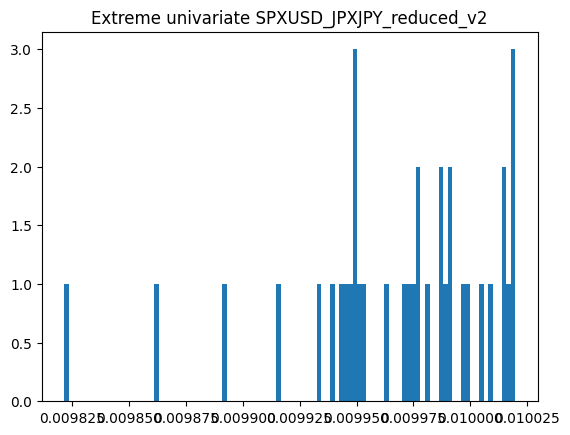

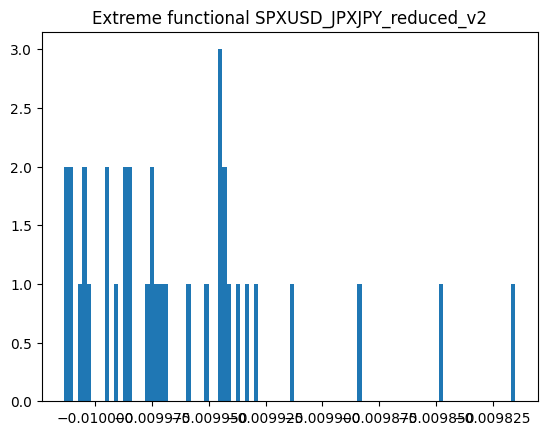

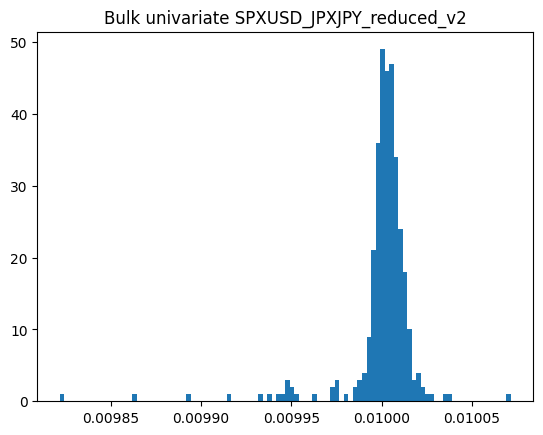

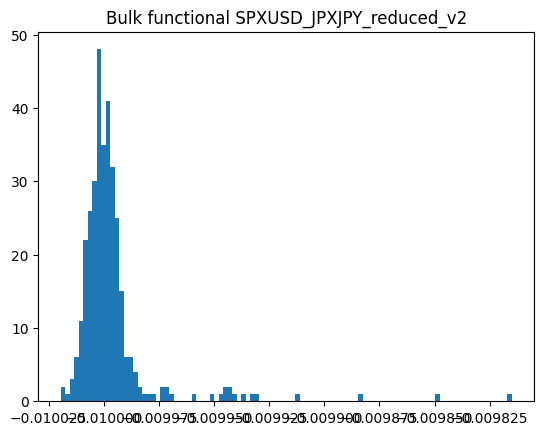

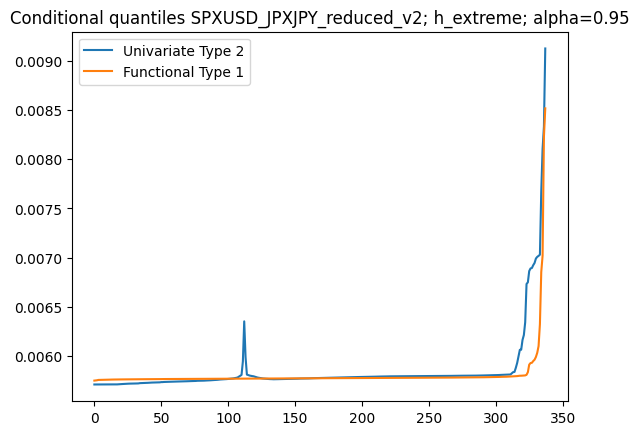

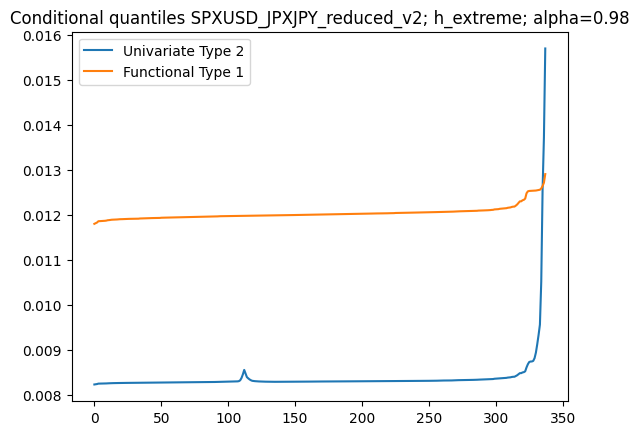

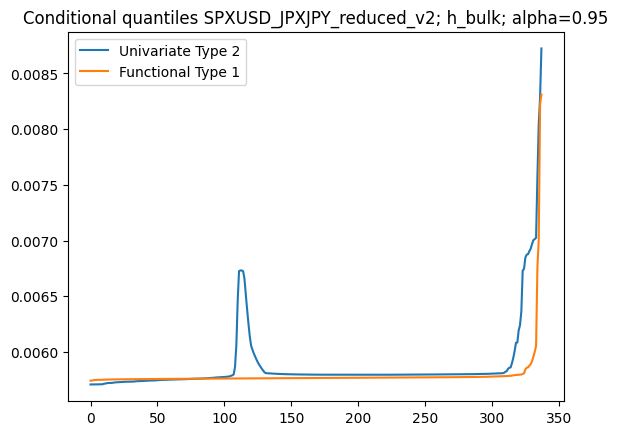

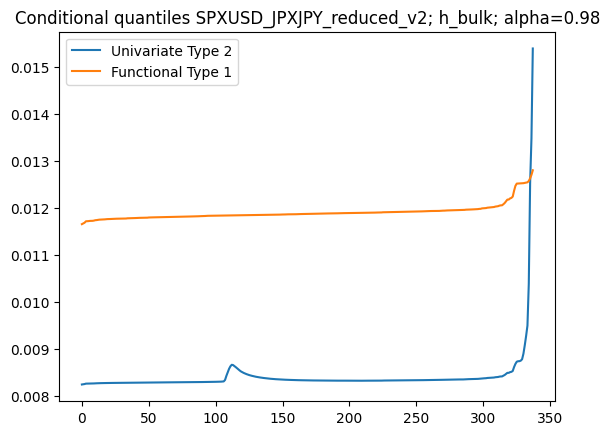

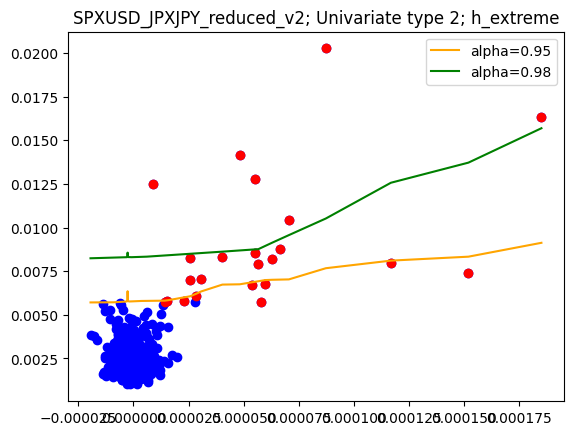

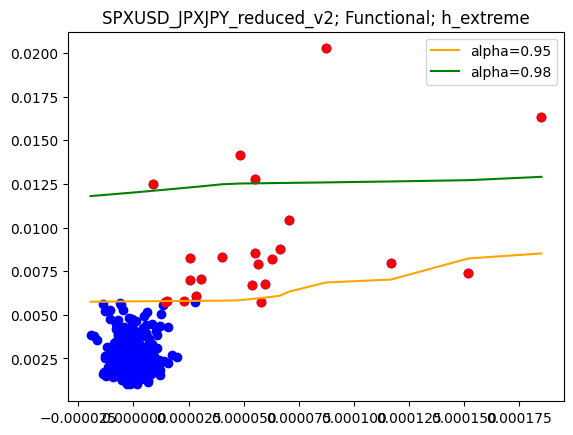

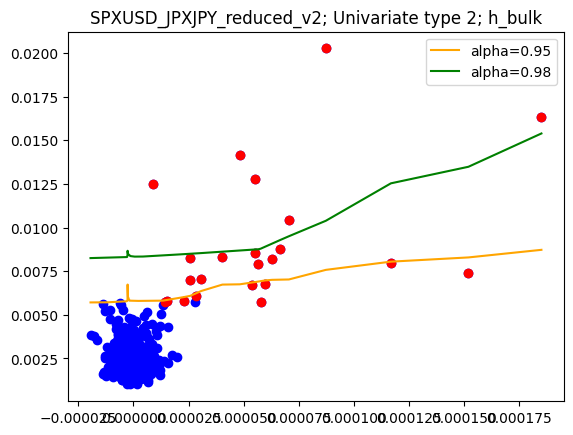

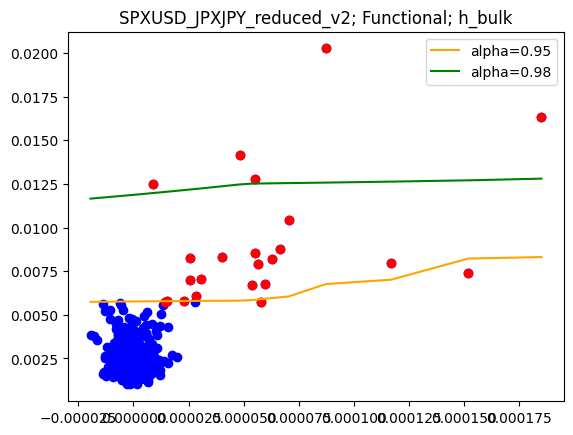

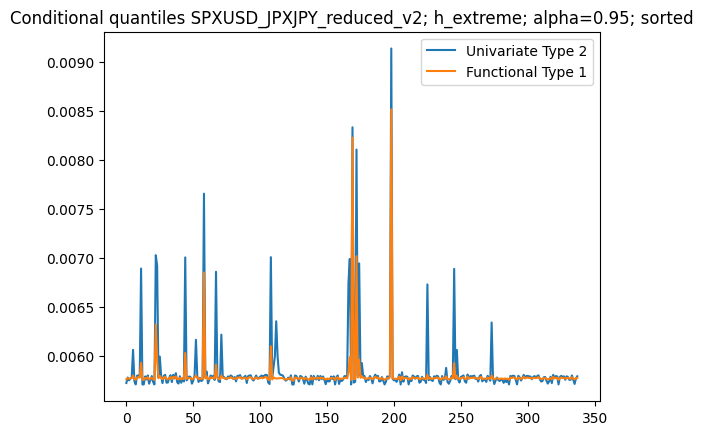

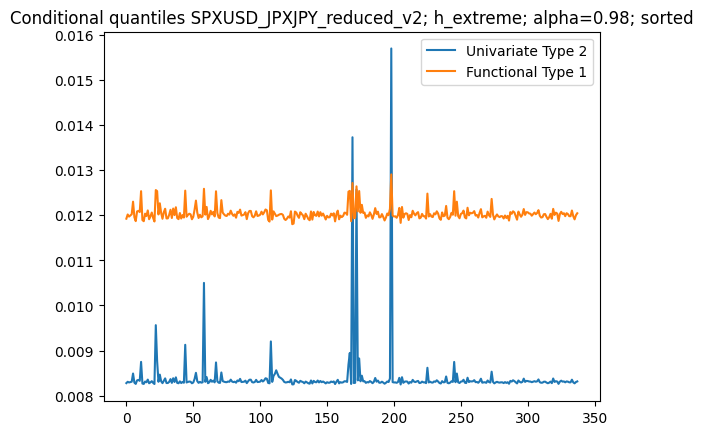

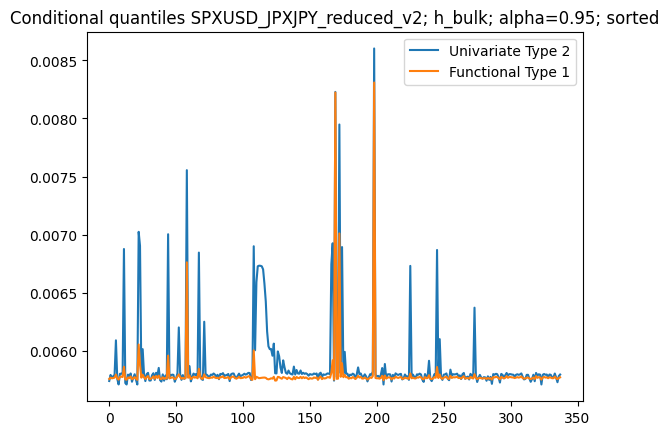

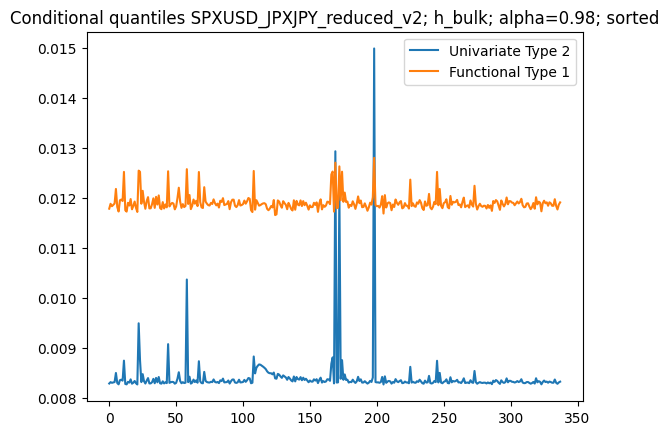

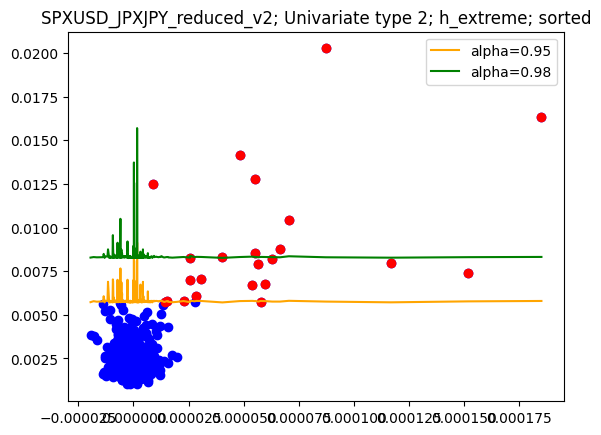

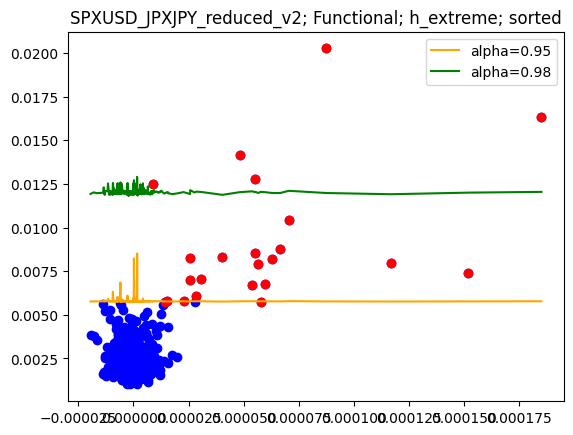

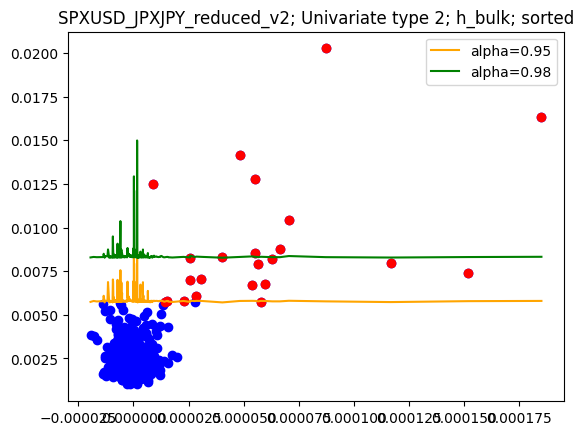

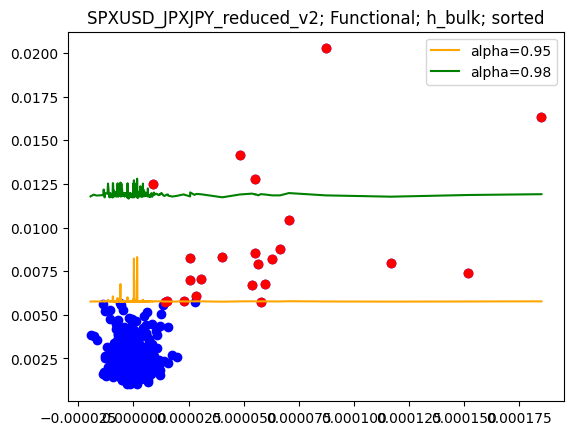

In [13]:

#########################
x=0.01
a=-0.05
b=0.1
alpha1=0.95
alpha2=0.98
kernel=2 # Gaussian kernel
J=9
N=X_SPXUSD_JPXJPY_reduced.shape[0]
n=X_SPXUSD_JPXJPY_reduced.shape[1]
d=X_SPXUSD_JPXJPY_reduced.shape[2]
max_threshold_SPXUSD_JPXJPY_reduced = int(n/5)
min_threshold = 15
s1=2
s2=2

#####################################
X_2D = X_SPXUSD_JPXJPY_reduced[0,:,:]
Y_sort_index = np.argsort(Y_SPXUSD_JPXJPY_reduced,axis=1)
x_func = E0_SPXUSD_JPXJPY_reduced[0,:]

#############################
H_extreme=hist_weight_extreme_2D(X_2D,Y_SPXUSD_JPXJPY_reduced,Y_sort_index,x_func,x,tau,max_threshold_SPXUSD_JPXJPY_reduced,min_threshold)
thresholdd = threshold(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,Y_sort_index,tau,max_threshold_SPXUSD_JPXJPY_reduced,min_threshold)
index_to_remove = np.where(Y_SPXUSD_JPXJPY_reduced<=thresholdd)
X_extreme_2D=np.delete(X_2D,index_to_remove,axis=0)
H_total_extreme=hist_weight_extreme_2D_total(X_extreme_2D,x_func,a,b,n)

#############################
plt.hist(H_extreme[:,0],bins=100)
plt.title('Extreme univariate SPXUSD_JPXJPY_reduced_v2')
plt.show()
plt.hist(H_extreme[:,1],bins=100)
plt.title('Extreme functional SPXUSD_JPXJPY_reduced_v2')
plt.show()

#############################
H_bulk=hist_weight_2D(X_2D,Y_SPXUSD_JPXJPY_reduced,Y_sort_index,x_func,x,tau)
H_total_bulk=hist_weight_2D_total(X_2D,x_func,a,b,n)

#############################
plt.hist(H_bulk[:,0],bins=100)
plt.title('Bulk univariate SPXUSD_JPXJPY_reduced_v2')
plt.show()
plt.hist(H_bulk[:,1],bins=100)
plt.title('Bulk functional SPXUSD_JPXJPY_reduced_v2')
plt.show()

############################################# Window/Bandwidth choice
h_vector_extreme = (np.max(H_total_extreme[:,:,0],axis=0)-np.min(H_total_extreme[:,:,0],axis=0))/s1
h_func_vector_extreme = (np.max(H_total_extreme[:,:,1],axis=0)-np.min(H_total_extreme[:,:,1],axis=0))/s2
h_extreme=(np.max(H_extreme[:,0],axis=0)-np.min(H_extreme[:,0],axis=0))/s1
h_func_extreme=(np.max(H_extreme[:,1],axis=0)-np.min(H_extreme[:,1],axis=0))/s2
h_func_2D_extreme=np.transpose(np.outer(h_func_extreme*np.ones(n),np.ones(N))) # of shape (N,n) where A.shape = (n,); e.g., A=h_func*np.ones(n)

h_vector_bulk = (np.max(H_total_bulk[:,:,0],axis=0)-np.min(H_total_bulk[:,:,0],axis=0))/s1
h_func_vector_bulk = (np.max(H_total_bulk[:,:,1],axis=0)-np.min(H_total_bulk[:,:,1],axis=0))/s2
h_bulk=(np.max(H_bulk[:,0],axis=0)-np.min(H_bulk[:,0],axis=0))/s1
h_func_bulk=(np.max(H_bulk[:,1],axis=0)-np.min(H_bulk[:,1],axis=0))/s2
h_func_2D_bulk=np.transpose(np.outer(h_func_bulk*np.ones(n),np.ones(N))) # of shape (N,n) where A.shape = (n,); e.g., A=h_func*np.ones(n)

###############################################################################
# Y|(X,dimred1)=(x*x_func,dimred1) (type 1) vs Y|(X,dimred2) = x (type 2) vs Y|X = x*x_func (type functional)
covalues = np.sort(np.dot(X_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced[0,:])/d,axis=1)
covalues_sorted = np.dot(X_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced[0,:])/d

PP11_extreme_sample=plot_quantile_conditional_on_sample(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced[0,:],alpha1,covalues,h_vector_extreme,h_func_vector_extreme,kernel) 
PP12_extreme_sample=plot_quantile_conditional_on_sample(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced[0,:],alpha2,covalues,h_vector_extreme,h_func_vector_extreme,kernel)
PP11_bulk_sample=plot_quantile_conditional_on_sample(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced[0,:],alpha1,covalues,h_vector_bulk,h_func_vector_bulk,kernel)
PP12_bulk_sample=plot_quantile_conditional_on_sample(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced[0,:],alpha2,covalues,h_vector_bulk,h_func_vector_bulk,kernel)

plt.plot(PP11_extreme_sample[:,0],label='Univariate Type 2')
plt.plot(PP11_extreme_sample[:,1],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_JPXJPY_reduced_v2; h_extreme; alpha=0.95')
plt.show()
plt.plot(PP12_extreme_sample[:,0],label='Univariate Type 2')
plt.plot(PP12_extreme_sample[:,1],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_JPXJPY_reduced_v2; h_extreme; alpha=0.98')
plt.show()
plt.plot(PP11_bulk_sample[:,0],label='Univariate Type 2')
plt.plot(PP11_bulk_sample[:,1],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_JPXJPY_reduced_v2; h_bulk; alpha=0.95')
plt.show()
plt.plot(PP12_bulk_sample[:,0],label='Univariate Type 2')
plt.plot(PP12_bulk_sample[:,1],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_JPXJPY_reduced_v2; h_bulk; alpha=0.98')
plt.show()

###############################################################################
offset1=0
offset2=0

plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
highest_indices_SPXUSD_JPXJPY_reduced = np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-bti:]
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset1,  PP11_extreme_sample[:,0], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset2,  PP12_extreme_sample[:,0], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_JPXJPY_reduced_v2; Univariate type 2; h_extreme')
plt.legend()
#plt.savefig('SPXUSD_JPXJPY_reduced_Univariate_type2_h_extreme.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
highest_indices_SPXUSD_JPXJPY_reduced = np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-bti:]
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset1,  PP11_extreme_sample[:,1], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset2,  PP12_extreme_sample[:,1], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_JPXJPY_reduced_v2; Functional; h_extreme')
plt.legend()
#plt.savefig('SPXUSD_JPXJPY_reduced_Functional_h_extreme.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
highest_indices_SPXUSD_JPXJPY_reduced = np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-bti:]
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset1,  PP11_bulk_sample[:,0], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset2,  PP12_bulk_sample[:,0], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_JPXJPY_reduced_v2; Univariate type 2; h_bulk')
plt.legend()
#plt.savefig('SPXUSD_JPXJPY_reduced_Univariate_type2_h_bulk.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
highest_indices_SPXUSD_JPXJPY_reduced = np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-bti:]
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset1,  PP11_bulk_sample[:,1], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset2,  PP12_bulk_sample[:,1], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_JPXJPY_reduced_v2; Functional; h_bulk')
plt.legend()
#plt.savefig('SPXUSD_JPXJPY_reduced_Functional_h_bulk.pdf')  
plt.show()

PP11_extreme_sample_sorted=plot_quantile_conditional_on_sample(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced[0,:],alpha1,covalues_sorted,h_vector_extreme,h_func_vector_extreme,kernel) 
PP12_extreme_sample_sorted=plot_quantile_conditional_on_sample(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced[0,:],alpha2,covalues_sorted,h_vector_extreme,h_func_vector_extreme,kernel)
PP11_bulk_sample_sorted=plot_quantile_conditional_on_sample(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced[0,:],alpha1,covalues_sorted,h_vector_bulk,h_func_vector_bulk,kernel)
PP12_bulk_sample_sorted=plot_quantile_conditional_on_sample(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced[0,:],alpha2,covalues_sorted,h_vector_bulk,h_func_vector_bulk,kernel)

plt.plot(PP11_extreme_sample_sorted[:,0],label='Univariate Type 2')
plt.plot(PP11_extreme_sample_sorted[:,1],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_JPXJPY_reduced_v2; h_extreme; alpha=0.95; sorted')
plt.show()
plt.plot(PP12_extreme_sample_sorted[:,0],label='Univariate Type 2')
plt.plot(PP12_extreme_sample_sorted[:,1],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_JPXJPY_reduced_v2; h_extreme; alpha=0.98; sorted')
plt.show()
plt.plot(PP11_bulk_sample_sorted[:,0],label='Univariate Type 2')
plt.plot(PP11_bulk_sample_sorted[:,1],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_JPXJPY_reduced_v2; h_bulk; alpha=0.95; sorted')
plt.show()
plt.plot(PP12_bulk_sample_sorted[:,0],label='Univariate Type 2')
plt.plot(PP12_bulk_sample_sorted[:,1],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles SPXUSD_JPXJPY_reduced_v2; h_bulk; alpha=0.98; sorted')
plt.show()

###############################################################################
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
highest_indices_SPXUSD_JPXJPY_reduced = np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-bti:]
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset1,  PP11_extreme_sample_sorted[:,0], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset2,  PP12_extreme_sample_sorted[:,0], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_JPXJPY_reduced_v2; Univariate type 2; h_extreme; sorted')
plt.legend()
#plt.savefig('SPXUSD_JPXJPY_reduced_v2_Univariate_type2_h_extreme_sorted.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
highest_indices_SPXUSD_JPXJPY_reduced = np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-bti:]
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset1,  PP11_extreme_sample_sorted[:,1], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset2,  PP12_extreme_sample_sorted[:,1], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_JPXJPY_reduced_v2; Functional; h_extreme; sorted')
plt.legend()
#plt.savefig('SPXUSD_JPXJPY_reduced_v2_Functional_h_extreme_sorted.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
highest_indices_SPXUSD_JPXJPY_reduced = np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-bti:]
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset1,  PP11_bulk_sample_sorted[:,0], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset2,  PP12_bulk_sample_sorted[:,0], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_JPXJPY_reduced_v2; Univariate type 2; h_bulk; sorted')
plt.legend()
#plt.savefig('SPXUSD_JPXJPY_reduced_v2_Univariate_type2_h_bulk_sorted.pdf')  
plt.show()

plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
highest_indices_SPXUSD_JPXJPY_reduced = np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-bti:]
plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset1,  PP11_bulk_sample_sorted[:,1], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset2,  PP12_bulk_sample_sorted[:,1], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('SPXUSD_JPXJPY_reduced_v2; Functional; h_bulk; sorted')
plt.legend()
#plt.savefig('SPXUSD_JPXJPY_reduced_v2_Functional_h_bulk_sorted.pdf')  
plt.show()

The bandwidth h for the following plots is 0.004


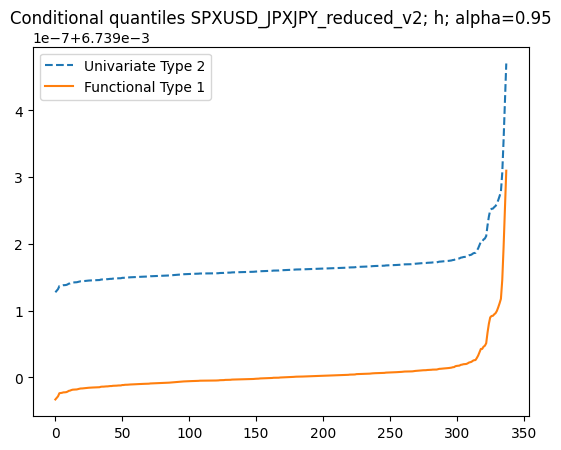

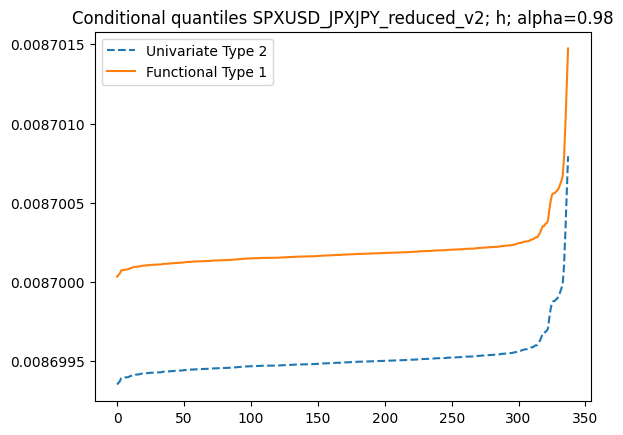

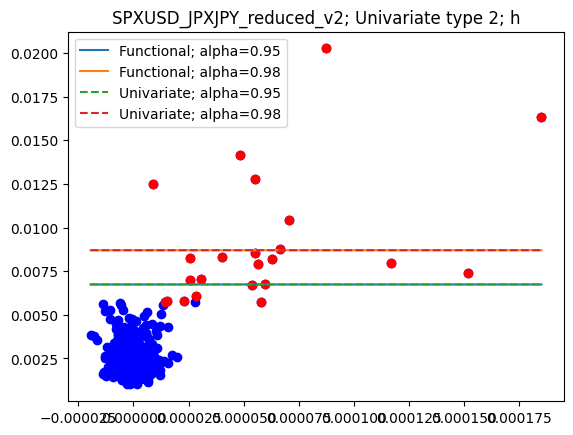

In [14]:
@numba.njit(parallel=True, fastmath=False) 
def plot_quantile_conditional_on_sample2(X,Y,dimred,covalues,x_func,alpha,h_vector,h_func_vector,kernel): 
    # X of shape (N,n,d) and Y of shape (N,n) with N=1;n=...;d=1440
    # covalues=np.dot(X_SPXUSD_JPXJPY_reduced,E0_SPXUSD_JPXJPY_reduced[0,:])/d   # shape = (N,n) = (1,431) family of (<X_i,dimred>)_{1\le i \le n} avec dimred \in H de taille (d,)=(1440)
    # dimred of shape (d,), e.g., dimred = E0[0,:] with E0 = fepls(X,Y,y_matrix,tau)
    # h_vector.shape = h_func_vector.shape = (n,)
    # Functional: X = x_func \in H; Univariate (type 2): <X,dimred>=covalues\in \R with covalues=<X_i,x_func> for 1 \le i \le n.   
    # x_func is a generical function/vector of shape (d,) and dimred is the FEPLS, i.e., E0[0,:] also of shape (d,)
    n=Y.shape[1]
    out = np.zeros((n,2))
    for p in numba.prange(n):
        weight2=univariate_Nadaraya_weight_2D(X[0,:,:],dimred,dimred,covalues[0,p],h_vector[p],2,kernel)
        weight_func=functional_Nadaraya_weight_2D(X[0,:,:],covalues[0,p]*dimred,h_func_vector[p],kernel)
        out[p,0]=weighted_quantile(Y[0,:],weight2,alpha)
        out[p,1]=weighted_quantile(Y[0,:],weight_func,alpha)
    return out

#########################

alpha1=0.95
alpha2=0.98
kernel=2 # Gaussian kernel
J=9

N=X_SPXUSD_JPXJPY_reduced.shape[0]
n=X_SPXUSD_JPXJPY_reduced.shape[1]
d=X_SPXUSD_JPXJPY_reduced.shape[2]

##############################################################################
# Y|(X,dimred) = covalues (type univariate) vs Y|X = x_func (type functional)

dimred = E0_SPXUSD_JPXJPY_reduced[0,:] # of shape (d,)
x_func = E0_SPXUSD_JPXJPY_reduced[0,:] # of shape (d,)
covalues = np.sort(np.dot(X_SPXUSD_JPXJPY_reduced,x_func)/d,axis=1)

##############################################################

H_grid=[0.004] #np.linspace(0.0002,0.004,51)

for h in H_grid:
    h_vector = h*np.ones((n,))
    h_func_vector = h*np.ones((n,))
    
    PP11_sample=plot_quantile_conditional_on_sample2(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,dimred,covalues,x_func,alpha1,h_vector,h_func_vector,kernel) 
    PP12_sample=plot_quantile_conditional_on_sample2(X_SPXUSD_JPXJPY_reduced,Y_SPXUSD_JPXJPY_reduced,dimred,covalues,x_func,alpha2,h_vector,h_func_vector,kernel)
    print('The bandwidth h for the following plots is',h) 
    plt.plot(PP11_sample[:,0], linestyle='dashed', label='Univariate Type 2')
    plt.plot(PP11_sample[:,1], label='Functional Type 1')
    plt.legend()
    plt.title('Conditional quantiles SPXUSD_JPXJPY_reduced_v2; h; alpha=0.95')
    plt.show()
    plt.plot(PP12_sample[:,0], linestyle='dashed', label='Univariate Type 2')
    plt.plot(PP12_sample[:,1],label='Functional Type 1')
    plt.legend()
    plt.title('Conditional quantiles SPXUSD_JPXJPY_reduced_v2; h; alpha=0.98')
    plt.show()
    ###########################################################
    offset1=0
    offset2=0
    plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,:], Y_SPXUSD_JPXJPY_reduced[0,:], color='blue', marker='o')
    highest_indices_SPXUSD_JPXJPY_reduced = np.argsort(Y_SPXUSD_JPXJPY_reduced)[0,-bti:]
    plt.scatter(F0_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], Y_SPXUSD_JPXJPY_reduced[0,highest_indices_SPXUSD_JPXJPY_reduced], color='red')
    plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset1,  PP11_sample[:,1],  label='Functional; alpha=0.95')
    plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset2,  PP12_sample[:,1],  label='Functional; alpha=0.98')
    plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset1,  PP11_sample[:,0],  linestyle='dashed',label='Univariate; alpha=0.95')
    plt.plot(np.sort(F0_SPXUSD_JPXJPY_reduced[0,:])+offset2,  PP12_sample[:,0],  linestyle='dashed',label='Univariate; alpha=0.98')
    #plt.xlim(-0.02, 0.03) 
    #plt.ylim(-0.01, 0.22) 
    plt.title('SPXUSD_JPXJPY_reduced_v2')
    plt.legend()
    #plt.savefig('SPXUSD_JPXJPY_reduced_Univariate_type2_h.pdf')  
    plt.show()



Data size 440


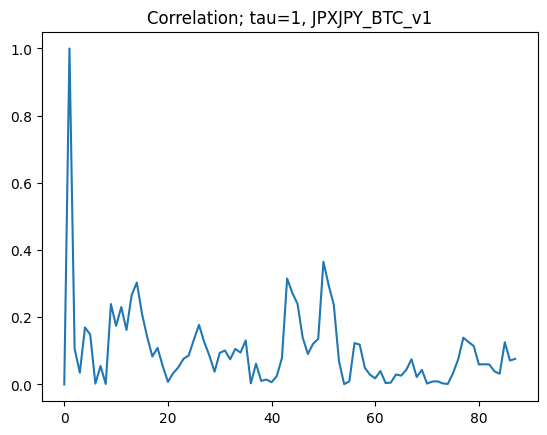

JPXJPY_BTC_v1 - max corr - index: 0.3652615994552687 50


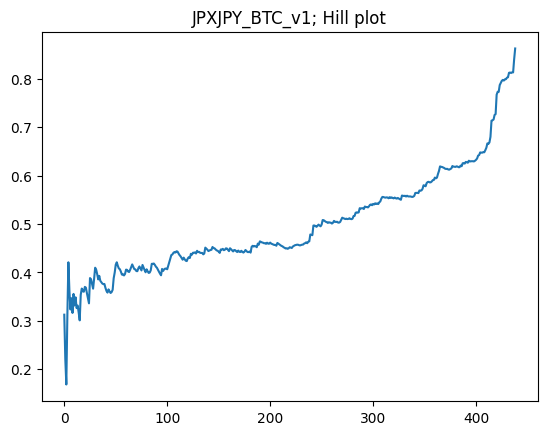

intermediate_seq k_n is 80


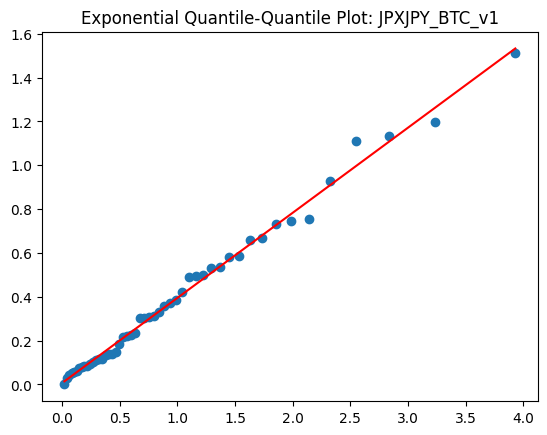

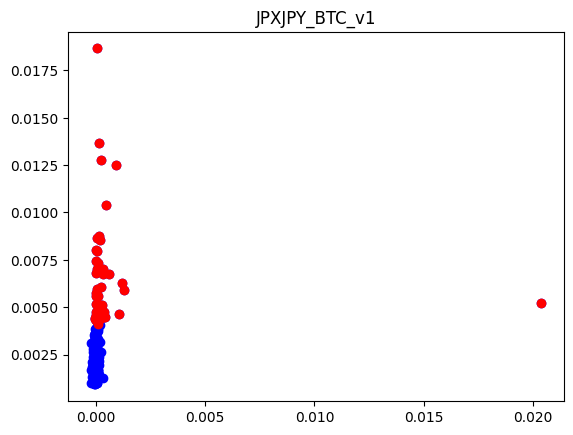

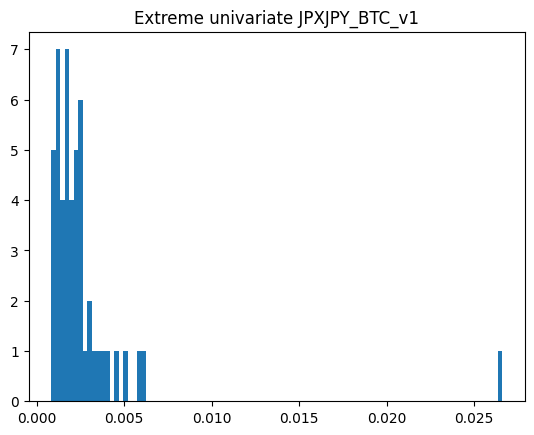

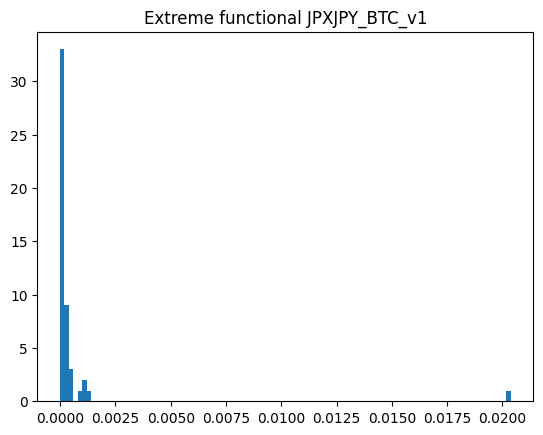

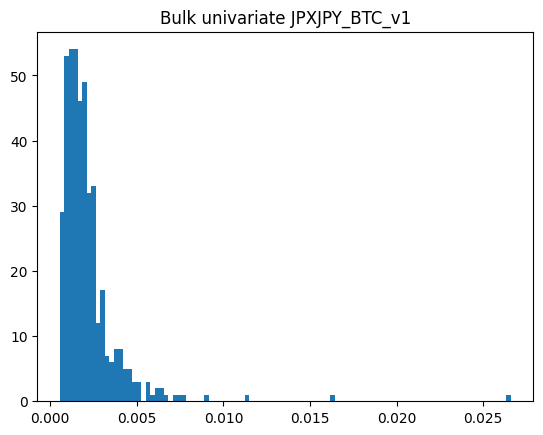

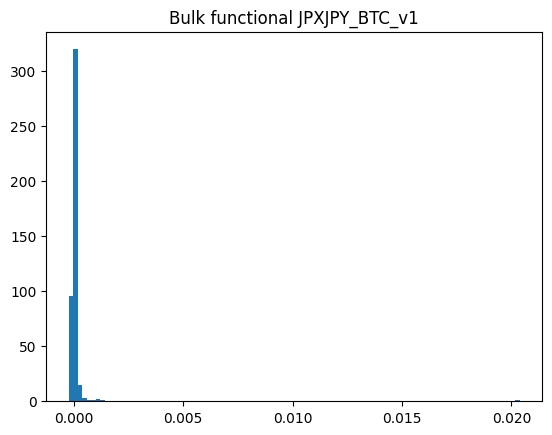

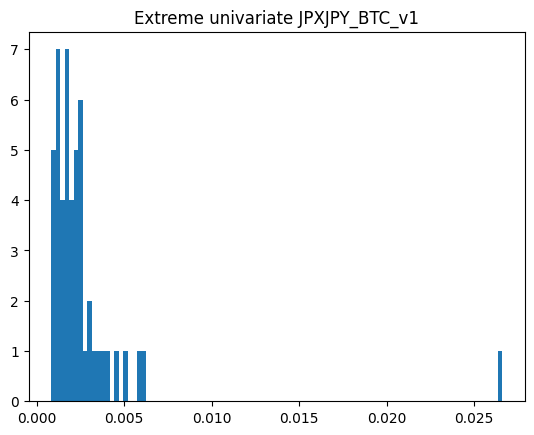

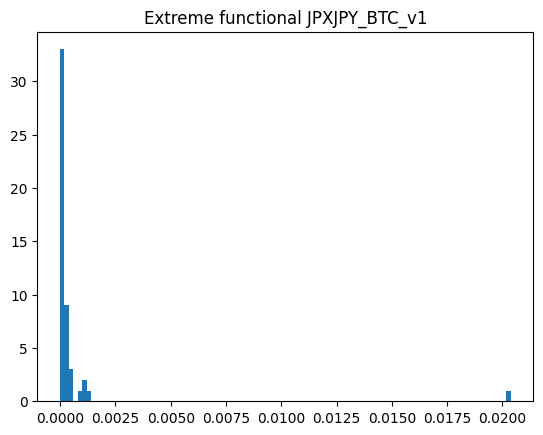

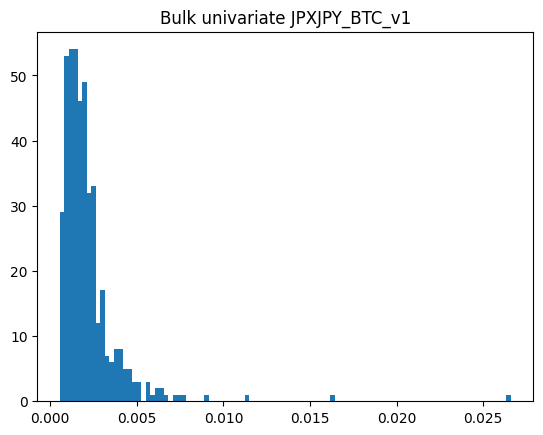

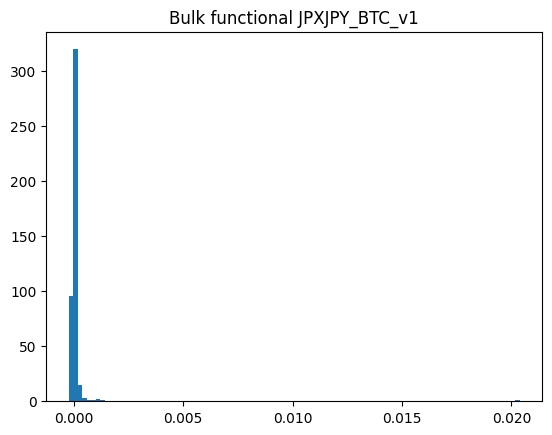

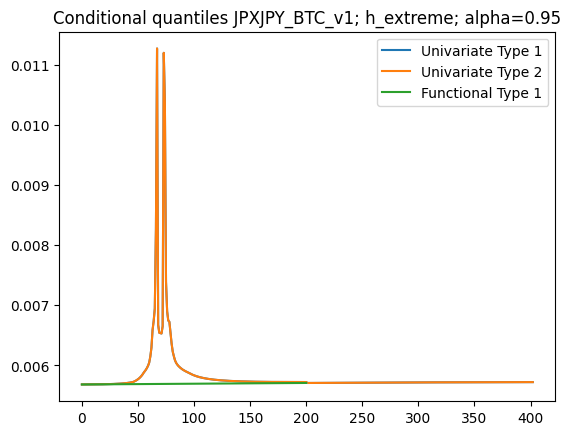

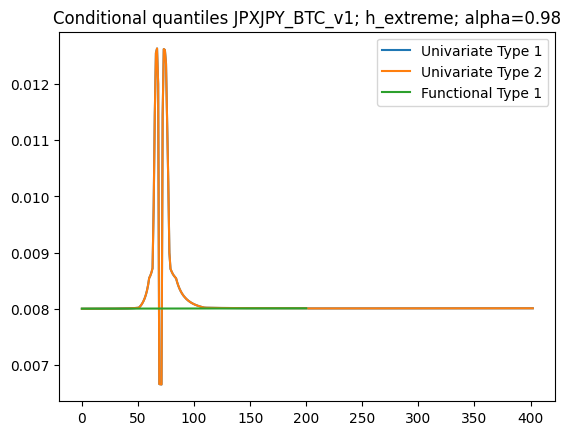

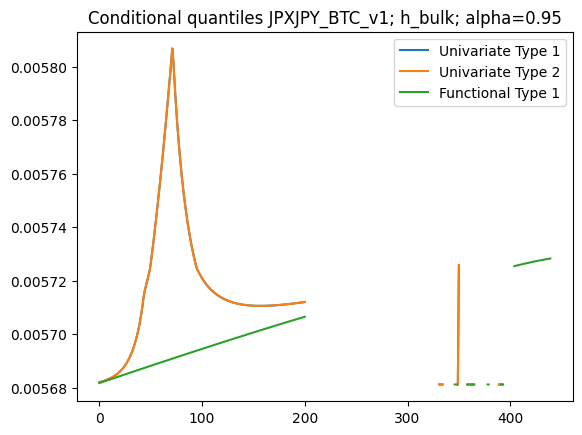

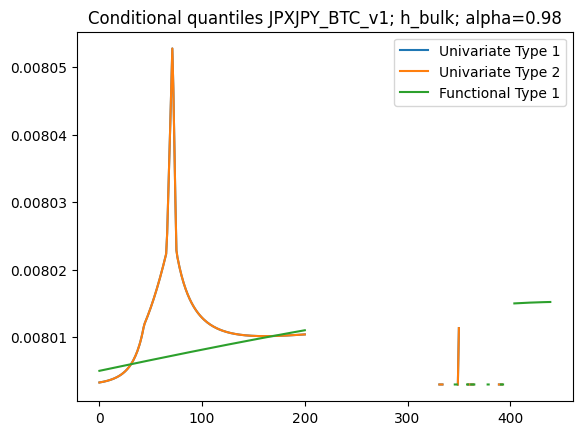

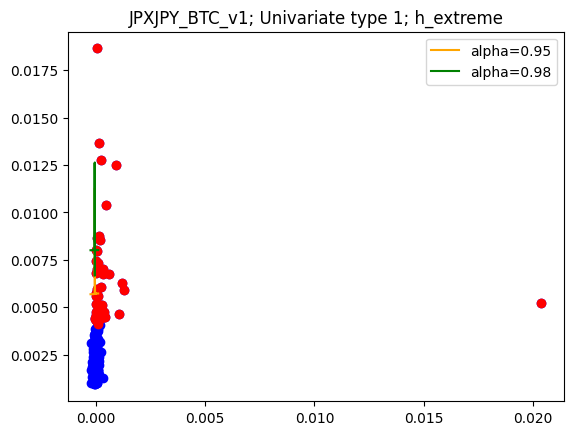

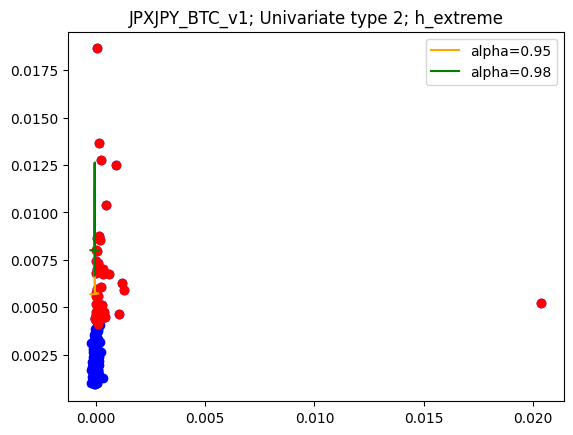

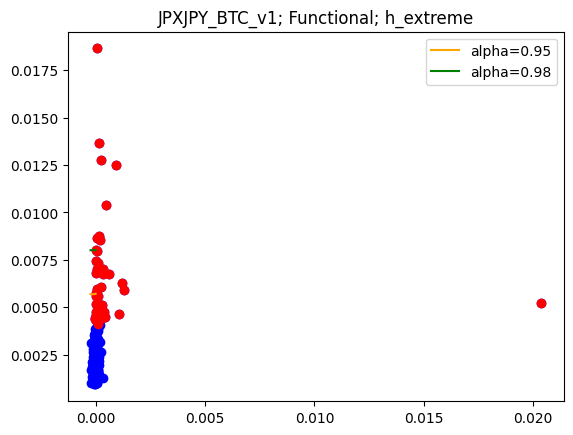

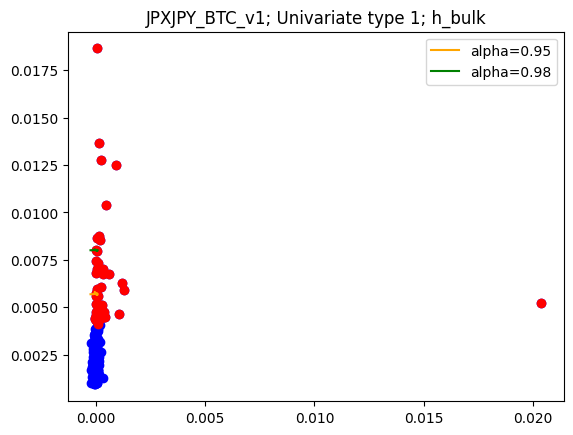

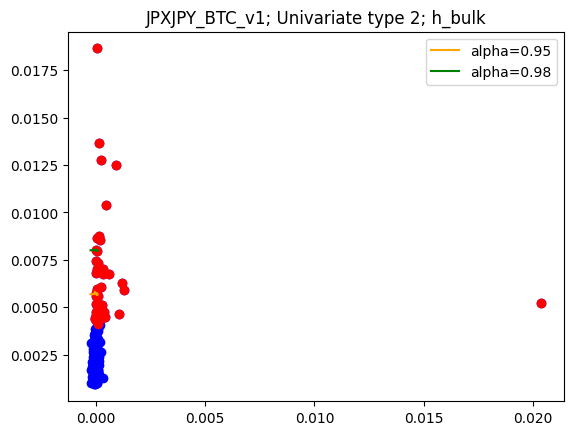

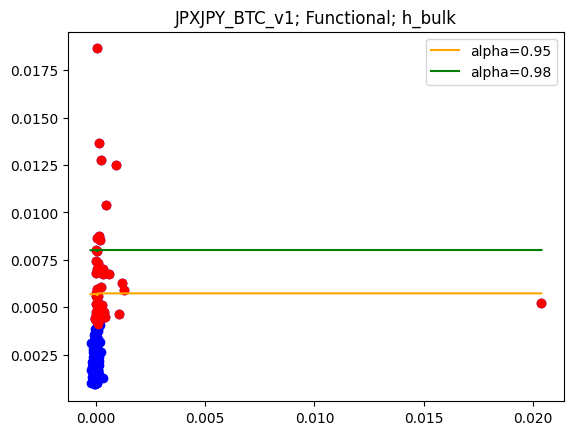

In [15]:

X1_2013_JPXJPY_BTC = pd.merge(X1_2013_JPXJPY, X1_2013_BTC, on='date', how='inner')
X1_2014_JPXJPY_BTC = pd.merge(X1_2014_JPXJPY, X1_2014_BTC, on='date', how='inner')
X1_2015_JPXJPY_BTC = pd.merge(X1_2015_JPXJPY, X1_2015_BTC, on='date', how='inner')
X1_2016_JPXJPY_BTC = pd.merge(X1_2016_JPXJPY, X1_2016_BTC, on='date', how='inner')
X1_2017_JPXJPY_BTC = pd.merge(X1_2017_JPXJPY, X1_2017_BTC, on='date', how='inner')

X_2013_JPXJPY_BTC = ((X1_2013_JPXJPY_BTC.values)[:,[4,9]]).astype(float)
X_2014_JPXJPY_BTC = ((X1_2014_JPXJPY_BTC.values)[:,[4,9]]).astype(float)
X_2015_JPXJPY_BTC = ((X1_2015_JPXJPY_BTC.values)[:,[4,9]]).astype(float)
X_2016_JPXJPY_BTC = ((X1_2016_JPXJPY_BTC.values)[:,[4,9]]).astype(float)
X_2017_JPXJPY_BTC = ((X1_2017_JPXJPY_BTC.values)[:,[4,9]]).astype(float)

X_conc_JPXJPY_BTC =np.append(X_2013_JPXJPY_BTC,X_2014_JPXJPY_BTC,axis=0)
X_conc_JPXJPY_BTC =np.append(X_conc_JPXJPY_BTC,X_2015_JPXJPY_BTC,axis=0)
X_conc_JPXJPY_BTC =np.append(X_conc_JPXJPY_BTC,X_2016_JPXJPY_BTC,axis=0)
X_conc_JPXJPY_BTC =np.append(X_conc_JPXJPY_BTC,X_2017_JPXJPY_BTC,axis=0)

X_conc_JPXJPY=X_conc_JPXJPY_BTC[:,0]
X_conc_BTC=X_conc_JPXJPY_BTC[:,1]

X_logreturn_conc2_JPXJPY=np.diff(np.log(X_conc_JPXJPY)) # shape -1
X_logreturn_conc_JPXJPY = np.append(X_logreturn_conc2_JPXJPY[0],X_logreturn_conc2_JPXJPY) # shape +1

X_logreturn_conc2_BTC=np.diff(np.log(X_conc_BTC)) # shape -1
X_logreturn_conc_BTC = np.append(X_logreturn_conc2_BTC[0],X_logreturn_conc2_BTC) # shape +1

JPXJPY_per_day=mesh_time(X_logreturn_conc_JPXJPY,'24h') # shape = (863, 1440) - 863 days with 1440 minutes recorded 
BTC_per_day=mesh_time(X_logreturn_conc_BTC,'24h') # shape = (863, 1440)

JPXJPY_per_day_even=JPXJPY_per_day[::2,:]
BTC_per_day_even=BTC_per_day[::2,:]
JPXJPY_per_day_odd=JPXJPY_per_day[1::2,:]
BTC_per_day_odd=BTC_per_day[1::2,:]

Y_JPXJPY_BTC = np.max(JPXJPY_per_day_odd,axis=1)
X_JPXJPY_BTC = BTC_per_day_even[:-1,:]

#Y_JPXJPY_BTC = np.max(BTC_per_day_odd,axis=1)
#X_JPXJPY_BTC = JPXJPY_per_day_even[:-1,:]

X_JPXJPY_BTC=np.expand_dims(X_JPXJPY_BTC,axis=0) # shape (N,n,d) with N=1;n=...;1440
Y_JPXJPY_BTC=np.expand_dims(Y_JPXJPY_BTC,axis=0) # shape (N,n,d) with N=1;n=431;1440

index_to_remove1_JPXJPY_BTC = np.argmax(Y_JPXJPY_BTC,axis=1)
Y_JPXJPY_BTC_new1 = np.expand_dims(np.delete(Y_JPXJPY_BTC[0,:],index_to_remove1_JPXJPY_BTC),axis=0)
X_JPXJPY_BTC_new1=np.delete(X_JPXJPY_BTC,index_to_remove1_JPXJPY_BTC,axis=1)
index_to_remove2_JPXJPY_BTC=np.argmax(Y_JPXJPY_BTC_new1,axis=1)
Y_JPXJPY_BTC_reduced=np.expand_dims(np.delete(Y_JPXJPY_BTC_new1,index_to_remove2_JPXJPY_BTC),axis=0)
X_JPXJPY_BTC_reduced=np.delete(X_JPXJPY_BTC_new1,index_to_remove2_JPXJPY_BTC,axis=1)


###################################################
N=X_JPXJPY_BTC.shape[0]
n=X_JPXJPY_BTC.shape[1]
d=X_JPXJPY_BTC.shape[2]

print('Data size', n)
max_threshold_JPXJPY_BTC = int(np.floor(n/5)) # top 20% if n/5, top10% if n/10
min_threshold = 15
tau=1

############################### Correlation and Scatterplot
C0_JPXJPY_BTC = bitcoin_concomittant_corr(X_JPXJPY_BTC,Y_JPXJPY_BTC,tau,max_threshold_JPXJPY_BTC)
plt.plot(C0_JPXJPY_BTC)
plt.title('Correlation; tau=1, JPXJPY_BTC_v1')
plt.show()

ind=np.argmax(C0_JPXJPY_BTC[min_threshold:max_threshold_JPXJPY_BTC])+min_threshold 
print('JPXJPY_BTC_v1 - max corr - index:', C0_JPXJPY_BTC[ind], ind)

############### Hill Plot
G_JPXJPY_BTC=get_hill_estimator(np.sort(Y_JPXJPY_BTC[0,:])[::-1])
index_min = 750
plt.plot(G_JPXJPY_BTC[:index_min])
plt.title('JPXJPY_BTC_v1; Hill plot')
plt.show()

####################### Exponential Quantile-Quantile Plot
QQ=Exponential_QQ_Plot_1D(Y_JPXJPY_BTC,ind)
x=QQ[:,0]
y=QQ[:,1]
res=linregress(QQ[:,0],QQ[:,1])
plt.plot(QQ[:,0], QQ[:,1], 'o')
plt.plot(QQ[:,0], res.intercept + res.slope*QQ[:,0], 'r')
plt.title('Exponential Quantile-Quantile Plot: JPXJPY_BTC_v1')
print('intermediate_seq k_n is',80)
plt.show()

################################################################## FEPLS
y_matrix_JPXJPY_BTC = bitcoin_threshold(X_JPXJPY_BTC,Y_JPXJPY_BTC,tau,max_threshold_JPXJPY_BTC,min_threshold)
E0_JPXJPY_BTC=fepls(X_JPXJPY_BTC,Y_JPXJPY_BTC,y_matrix_JPXJPY_BTC,tau)
F0_JPXJPY_BTC=hatbeta_dot_X(X_JPXJPY_BTC,E0_JPXJPY_BTC)
bti = bitcoin_threshold_index(X_JPXJPY_BTC,Y_JPXJPY_BTC,tau,max_threshold_JPXJPY_BTC,min_threshold)

################################################################# Scatter plot
plt.scatter(F0_JPXJPY_BTC[0,:], Y_JPXJPY_BTC[0,:], color='blue', marker='o')
highest_indices_JPXJPY_BTC= np.argsort(Y_JPXJPY_BTC)[0,-bti:]
plt.scatter(F0_JPXJPY_BTC[0,highest_indices_JPXJPY_BTC], Y_JPXJPY_BTC[0,highest_indices_JPXJPY_BTC], color='red')
#plt.savefig('Scatter_JPXJPY500_5_tau_-2_v2.pdf') 
plt.title('JPXJPY_BTC_v1')
plt.show()

#########################
x=0
a=0
b=0.05
alpha1=0.95
alpha2=0.98
kernel=2 # Gaussian kernel
J=9
N=X_JPXJPY_BTC.shape[0]
n=X_JPXJPY_BTC.shape[1]
d=X_JPXJPY_BTC.shape[2]
max_threshold_JPXJPY_BTC = int(n/5)
min_threshold = 15
s1=1
s2=1

#####################################
X_2D = X_JPXJPY_BTC[0,:,:]
Y_sort_index = np.argsort(Y_JPXJPY_BTC,axis=1)
x_func = E0_JPXJPY_BTC[0,:]
#############################
H_extreme=hist_weight_extreme_2D(X_2D,Y_JPXJPY_BTC,Y_sort_index,x_func,x,tau,max_threshold_JPXJPY_BTC,min_threshold)
thresholdd = threshold(X_JPXJPY_BTC,Y_JPXJPY_BTC,Y_sort_index,tau,max_threshold_JPXJPY_BTC,min_threshold)
index_to_remove = np.where(Y_JPXJPY_BTC<=thresholdd)
X_extreme_2D=np.delete(X_2D,index_to_remove,axis=0)
H_total_extreme=hist_weight_extreme_2D_total(X_extreme_2D,x_func,a,b,1440)
#############################
plt.hist(H_extreme[:,0],bins=100)
plt.title('Extreme univariate JPXJPY_BTC_v1')
plt.show()
plt.hist(H_extreme[:,1],bins=100)
plt.title('Extreme functional JPXJPY_BTC_v1')
plt.show()
#############################
H_bulk=hist_weight_2D(X_2D,Y_JPXJPY_BTC,Y_sort_index,x_func,x,tau)
H_total_bulk=hist_weight_2D_total(X_2D,x_func,a,b,1440)
#############################
plt.hist(H_bulk[:,0],bins=100)
plt.title('Bulk univariate JPXJPY_BTC_v1')
plt.show()
plt.hist(H_bulk[:,1],bins=100)
plt.title('Bulk functional JPXJPY_BTC_v1')
plt.show()

#####################################
X_2D = X_JPXJPY_BTC[0,:,:]
Y_sort_index = np.argsort(Y_JPXJPY_BTC,axis=1)
x_func = E0_JPXJPY_BTC[0,:]

#############################
H_extreme=hist_weight_extreme_2D(X_2D,Y_JPXJPY_BTC,Y_sort_index,x_func,x,tau,max_threshold_JPXJPY_BTC,min_threshold)
thresholdd = threshold(X_JPXJPY_BTC,Y_JPXJPY_BTC,Y_sort_index,tau,max_threshold_JPXJPY_BTC,min_threshold)
index_to_remove = np.where(Y_JPXJPY_BTC<=thresholdd)
X_extreme_2D=np.delete(X_2D,index_to_remove,axis=0)
H_total_extreme=hist_weight_extreme_2D_total(X_extreme_2D,x_func,a,b,201)

#############################
plt.hist(H_extreme[:,0],bins=100)
plt.title('Extreme univariate JPXJPY_BTC_v1')
plt.show()
plt.hist(H_extreme[:,1],bins=100)
plt.title('Extreme functional JPXJPY_BTC_v1')
plt.show()

#############################
H_bulk=hist_weight_2D(X_2D,Y_JPXJPY_BTC,Y_sort_index,x_func,x,tau)
H_total_bulk=hist_weight_2D_total(X_2D,x_func,a,b,201)

#############################
plt.hist(H_bulk[:,0],bins=100)
plt.title('Bulk univariate JPXJPY_BTC_v1')
plt.show()
plt.hist(H_bulk[:,1],bins=100)
plt.title('Bulk functional JPXJPY_BTC_v1')
plt.show()

############################################# Window/Bandwidth choice
h_vector_extreme = (np.max(H_total_extreme[:,:,0],axis=0)-np.min(H_total_extreme[:,:,0],axis=0))/s1
h_func_vector_extreme = (np.max(H_total_extreme[:,:,1],axis=0)-np.min(H_total_extreme[:,:,1],axis=0))/s2
h_extreme=(np.max(H_extreme[:,0],axis=0)-np.min(H_extreme[:,0],axis=0))/s1
h_func_extreme=(np.max(H_extreme[:,1],axis=0)-np.min(H_extreme[:,1],axis=0))/s2
h_func_2D_extreme=np.transpose(np.outer(h_func_extreme*np.ones(n),np.ones(N))) # of shape (N,n) where A.shape = (n,); e.g., A=h_func*np.ones(n)

h_vector_bulk = (np.max(H_total_bulk[:,:,0],axis=0)-np.min(H_total_bulk[:,:,0],axis=0))/s1
h_func_vector_bulk = (np.max(H_total_bulk[:,:,1],axis=0)-np.min(H_total_bulk[:,:,1],axis=0))/s2
h_bulk=(np.max(H_bulk[:,0],axis=0)-np.min(H_bulk[:,0],axis=0))/s1
h_func_bulk=(np.max(H_bulk[:,1],axis=0)-np.min(H_bulk[:,1],axis=0))/s2
h_func_2D_bulk=np.transpose(np.outer(h_func_bulk*np.ones(n),np.ones(N))) # of shape (N,n) where A.shape = (n,); e.g., A=h_func*np.ones(n)

###############################################################################
# Y|(X,dimred1)=(x*x_func,dimred1) (type 1) vs Y|(X,dimred2) = x (type 2) vs Y|X = x*x_func (type functional)
PP11_extreme=plot_quantile_conditional(X_JPXJPY_BTC,Y_JPXJPY_BTC,E0_JPXJPY_BTC[0,:],E0_JPXJPY_BTC[0,:],E0_JPXJPY_BTC[0,:],alpha1,a,b,n,h_vector_extreme,h_func_vector_extreme,kernel) 
PP12_extreme=plot_quantile_conditional(X_JPXJPY_BTC,Y_JPXJPY_BTC,E0_JPXJPY_BTC[0,:],E0_JPXJPY_BTC[0,:],E0_JPXJPY_BTC[0,:],alpha2,a,b,n,h_vector_extreme,h_func_vector_extreme,kernel) 
PP11_bulk=plot_quantile_conditional(X_JPXJPY_BTC,Y_JPXJPY_BTC,E0_JPXJPY_BTC[0,:],E0_JPXJPY_BTC[0,:],E0_JPXJPY_BTC[0,:],alpha1,a,b,n,h_vector_bulk,h_func_vector_bulk,kernel) 
PP12_bulk=plot_quantile_conditional(X_JPXJPY_BTC,Y_JPXJPY_BTC,E0_JPXJPY_BTC[0,:],E0_JPXJPY_BTC[0,:],E0_JPXJPY_BTC[0,:],alpha2,a,b,n,h_vector_bulk,h_func_vector_bulk,kernel) 

plt.plot(PP11_extreme[:,0],label='Univariate Type 1')
plt.plot(PP11_extreme[:,1],label='Univariate Type 2')
plt.plot(PP11_extreme[:,2],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles JPXJPY_BTC_v1; h_extreme; alpha=0.95')
plt.show()
plt.plot(PP12_extreme[:,0],label='Univariate Type 1')
plt.plot(PP12_extreme[:,1],label='Univariate Type 2')
plt.plot(PP12_extreme[:,2],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles JPXJPY_BTC_v1; h_extreme; alpha=0.98')
plt.show()
plt.plot(PP11_bulk[:,0],label='Univariate Type 1')
plt.plot(PP11_bulk[:,1],label='Univariate Type 2')
plt.plot(PP11_bulk[:,2],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles JPXJPY_BTC_v1; h_bulk; alpha=0.95')
plt.show()
plt.plot(PP12_bulk[:,0],label='Univariate Type 1')
plt.plot(PP12_bulk[:,1],label='Univariate Type 2')
plt.plot(PP12_bulk[:,2],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles JPXJPY_BTC_v1; h_bulk; alpha=0.98')
plt.show()

###############################################################################
offset1=0
offset2=0

plt.scatter(F0_JPXJPY_BTC[0,:], Y_JPXJPY_BTC[0,:], color='blue', marker='o')
highest_indices_JPXJPY_BTC = np.argsort(Y_JPXJPY_BTC)[0,-bti:]
plt.scatter(F0_JPXJPY_BTC[0,highest_indices_JPXJPY_BTC], Y_JPXJPY_BTC[0,highest_indices_JPXJPY_BTC], color='red')
plt.plot(np.sort(F0_JPXJPY_BTC[0,:])+offset1,  PP11_extreme[:,0], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_JPXJPY_BTC[0,:])+offset2,  PP12_extreme[:,0], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('JPXJPY_BTC_v1; Univariate type 1; h_extreme')
plt.legend()
#plt.savefig('JPXJPY_BTC_Univariate_type1_h_extreme.pdf')  
plt.show()

plt.scatter(F0_JPXJPY_BTC[0,:], Y_JPXJPY_BTC[0,:], color='blue', marker='o')
highest_indices_JPXJPY_BTC = np.argsort(Y_JPXJPY_BTC)[0,-bti:]
plt.scatter(F0_JPXJPY_BTC[0,highest_indices_JPXJPY_BTC], Y_JPXJPY_BTC[0,highest_indices_JPXJPY_BTC], color='red')
plt.plot(np.sort(F0_JPXJPY_BTC[0,:])+offset1,  PP11_extreme[:,1], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_JPXJPY_BTC[0,:])+offset2,  PP12_extreme[:,1], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('JPXJPY_BTC_v1; Univariate type 2; h_extreme')
plt.legend()
#plt.savefig('JPXJPY_BTC_Univariate_type2_h_extreme.pdf')  
plt.show()

plt.scatter(F0_JPXJPY_BTC[0,:], Y_JPXJPY_BTC[0,:], color='blue', marker='o')
highest_indices_JPXJPY_BTC = np.argsort(Y_JPXJPY_BTC)[0,-bti:]
plt.scatter(F0_JPXJPY_BTC[0,highest_indices_JPXJPY_BTC], Y_JPXJPY_BTC[0,highest_indices_JPXJPY_BTC], color='red')
plt.plot(np.sort(F0_JPXJPY_BTC[0,:])+offset1,  PP11_extreme[:,2], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_JPXJPY_BTC[0,:])+offset2,  PP12_extreme[:,2], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('JPXJPY_BTC_v1; Functional; h_extreme')
plt.legend()
#plt.savefig('JPXJPY_BTC_Functional_h_extreme.pdf')  
plt.show()

plt.scatter(F0_JPXJPY_BTC[0,:], Y_JPXJPY_BTC[0,:], color='blue', marker='o')
highest_indices_JPXJPY_BTC = np.argsort(Y_JPXJPY_BTC)[0,-bti:]
plt.scatter(F0_JPXJPY_BTC[0,highest_indices_JPXJPY_BTC], Y_JPXJPY_BTC[0,highest_indices_JPXJPY_BTC], color='red')
plt.plot(np.sort(F0_JPXJPY_BTC[0,:])+offset1,  PP11_bulk[:,0], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_JPXJPY_BTC[0,:])+offset2,  PP12_bulk[:,0], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('JPXJPY_BTC_v1; Univariate type 1; h_bulk')
plt.legend()
#plt.savefig('JPXJPY_BTC_Univariate_type1_h_bulk.pdf')  
plt.show()

plt.scatter(F0_JPXJPY_BTC[0,:], Y_JPXJPY_BTC[0,:], color='blue', marker='o')
highest_indices_JPXJPY_BTC = np.argsort(Y_JPXJPY_BTC)[0,-bti:]
plt.scatter(F0_JPXJPY_BTC[0,highest_indices_JPXJPY_BTC], Y_JPXJPY_BTC[0,highest_indices_JPXJPY_BTC], color='red')
plt.plot(np.sort(F0_JPXJPY_BTC[0,:])+offset1,  PP11_bulk[:,1], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_JPXJPY_BTC[0,:])+offset2,  PP12_bulk[:,1], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('JPXJPY_BTC_v1; Univariate type 2; h_bulk')
plt.legend()
#plt.savefig('JPXJPY_BTC_Univariate_type2_h_bulk.pdf')  
plt.show()

plt.scatter(F0_JPXJPY_BTC[0,:], Y_JPXJPY_BTC[0,:], color='blue', marker='o')
highest_indices_JPXJPY_BTC = np.argsort(Y_JPXJPY_BTC)[0,-bti:]
plt.scatter(F0_JPXJPY_BTC[0,highest_indices_JPXJPY_BTC], Y_JPXJPY_BTC[0,highest_indices_JPXJPY_BTC], color='red')
plt.plot(np.sort(F0_JPXJPY_BTC[0,:])+offset1,  PP11_bulk[:,2], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_JPXJPY_BTC[0,:])+offset2,  PP12_bulk[:,2], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('JPXJPY_BTC_v1; Functional; h_bulk')
plt.legend()
#plt.savefig('JPXJPY_BTC_Functional_h_bulk.pdf')  
plt.show()


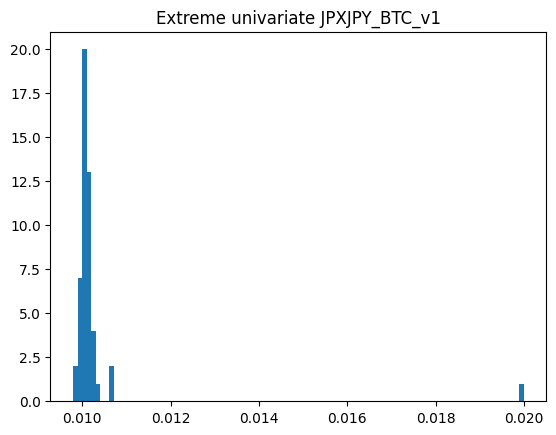

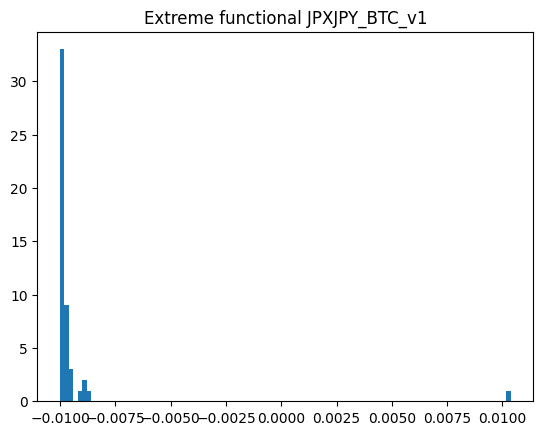

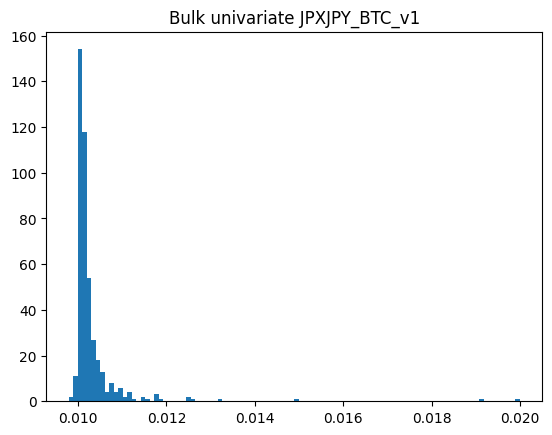

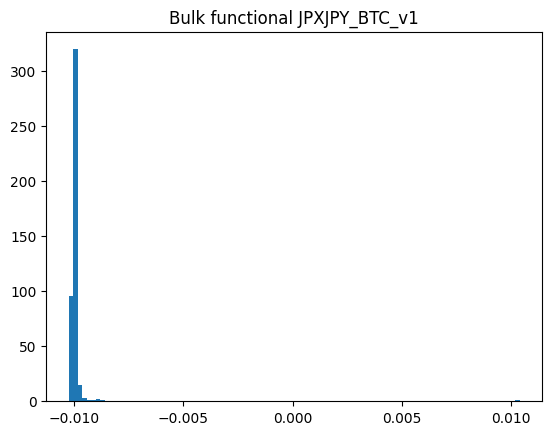

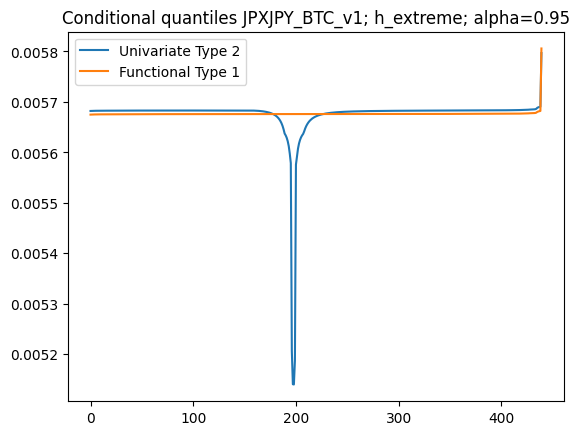

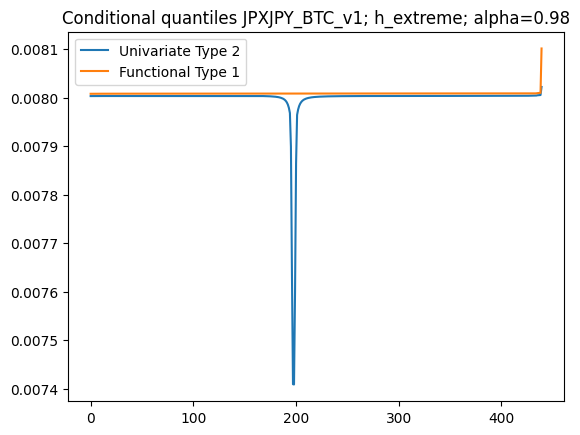

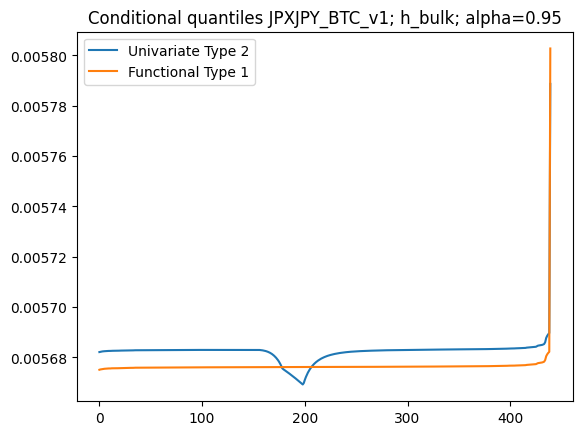

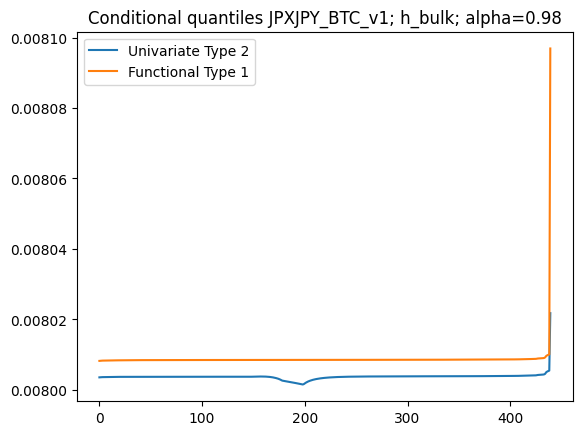

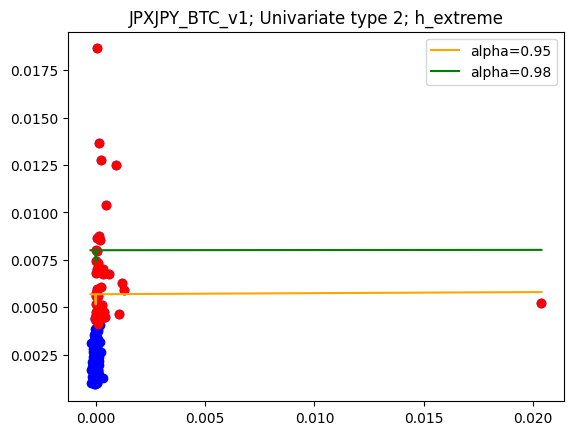

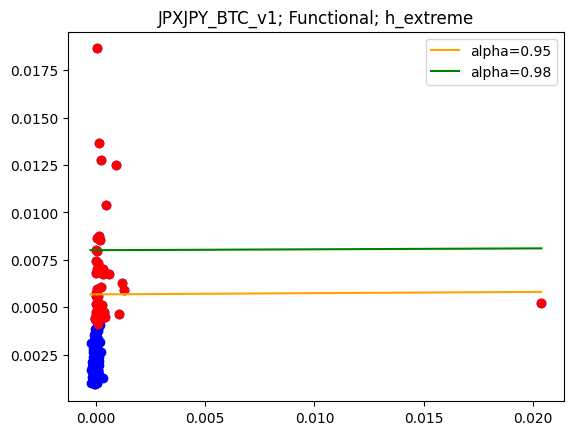

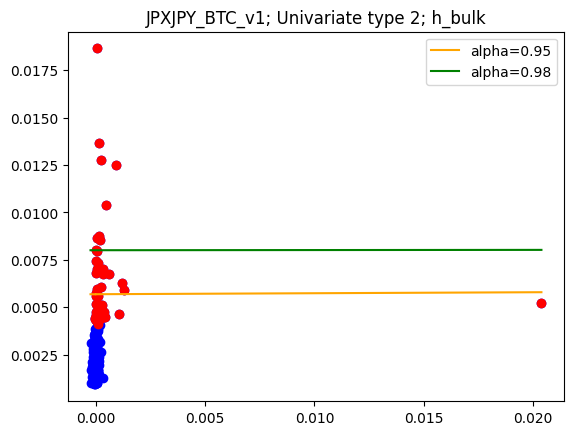

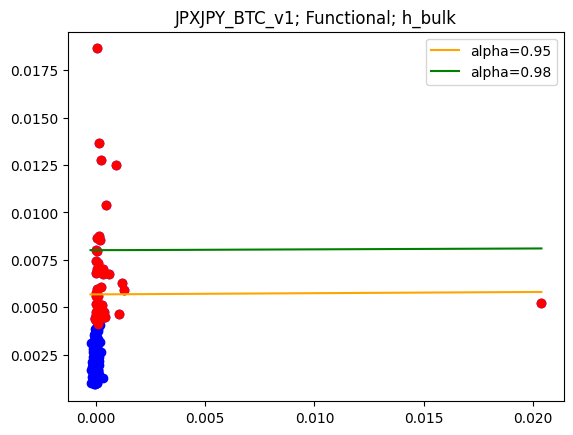

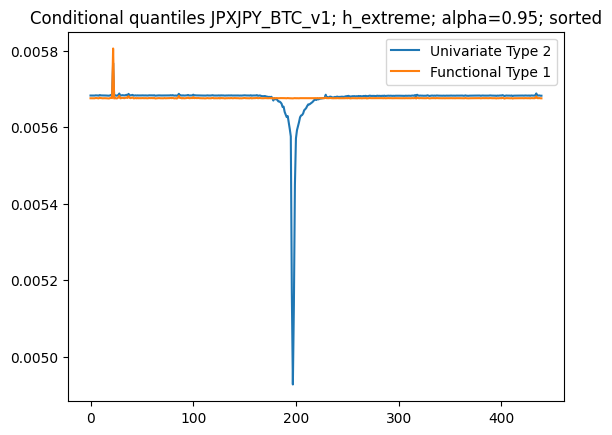

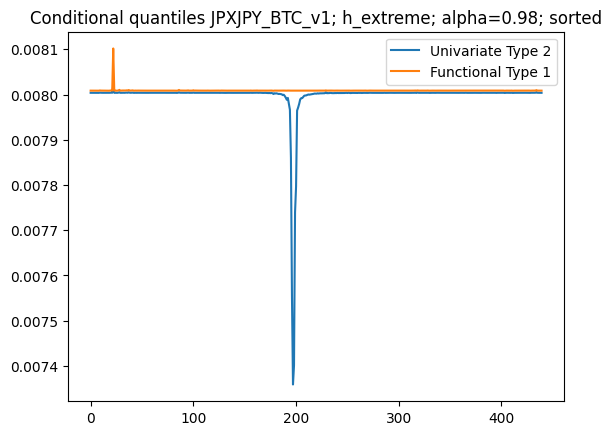

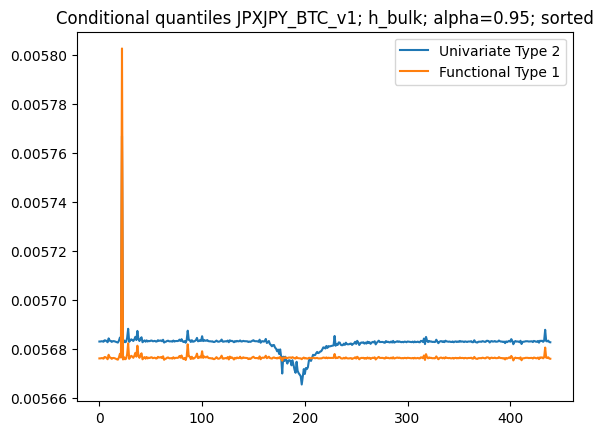

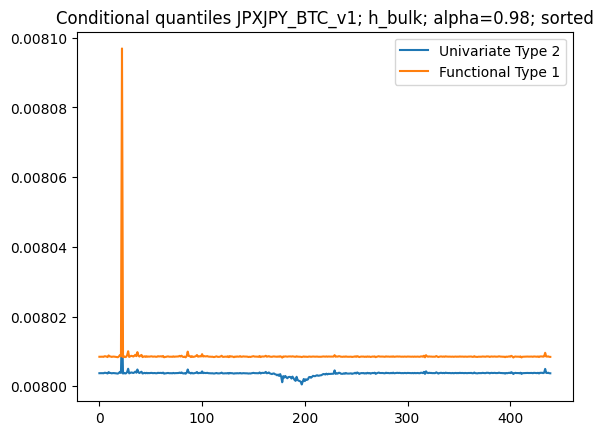

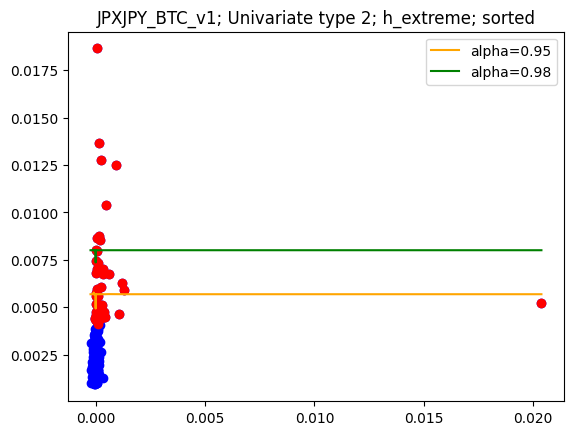

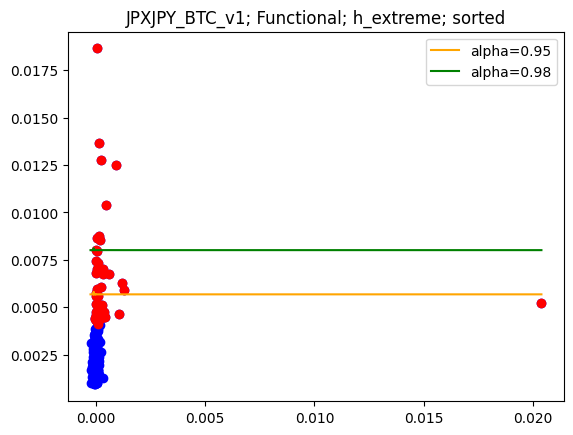

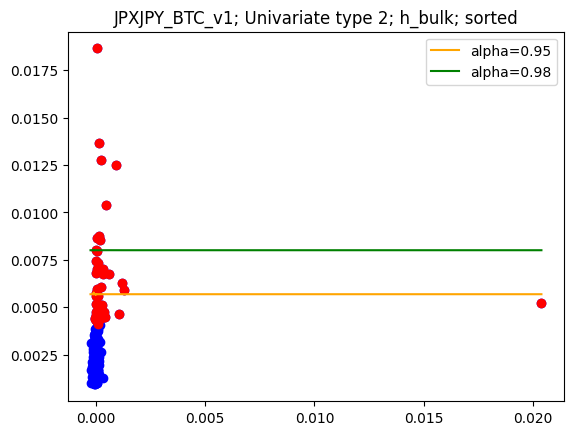

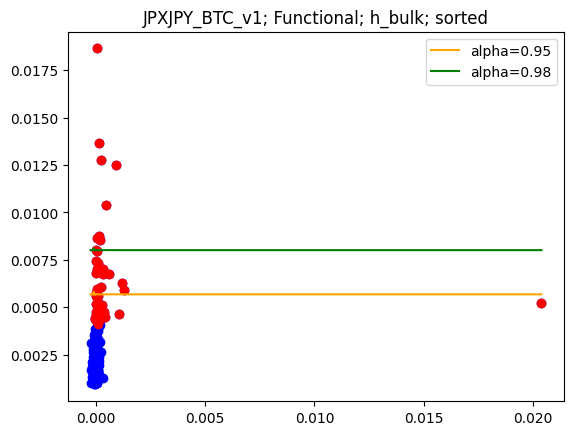

In [16]:

#########################
x=0.01
a=-0.05
b=0.1
alpha1=0.95
alpha2=0.98
kernel=2 # Gaussian kernel
J=9
N=X_JPXJPY_BTC.shape[0]
n=X_JPXJPY_BTC.shape[1]
d=X_JPXJPY_BTC.shape[2]
max_threshold_JPXJPY_BTC = int(n/5)
min_threshold = 15
s1=2
s2=2

#####################################
X_2D = X_JPXJPY_BTC[0,:,:]
Y_sort_index = np.argsort(Y_JPXJPY_BTC,axis=1)
x_func = E0_JPXJPY_BTC[0,:]

#############################
H_extreme=hist_weight_extreme_2D(X_2D,Y_JPXJPY_BTC,Y_sort_index,x_func,x,tau,max_threshold_JPXJPY_BTC,min_threshold)
thresholdd = threshold(X_JPXJPY_BTC,Y_JPXJPY_BTC,Y_sort_index,tau,max_threshold_JPXJPY_BTC,min_threshold)
index_to_remove = np.where(Y_JPXJPY_BTC<=thresholdd)
X_extreme_2D=np.delete(X_2D,index_to_remove,axis=0)
H_total_extreme=hist_weight_extreme_2D_total(X_extreme_2D,x_func,a,b,n)

#############################
plt.hist(H_extreme[:,0],bins=100)
plt.title('Extreme univariate JPXJPY_BTC_v1')
plt.show()
plt.hist(H_extreme[:,1],bins=100)
plt.title('Extreme functional JPXJPY_BTC_v1')
plt.show()

#############################
H_bulk=hist_weight_2D(X_2D,Y_JPXJPY_BTC,Y_sort_index,x_func,x,tau)
H_total_bulk=hist_weight_2D_total(X_2D,x_func,a,b,n)

#############################
plt.hist(H_bulk[:,0],bins=100)
plt.title('Bulk univariate JPXJPY_BTC_v1')
plt.show()
plt.hist(H_bulk[:,1],bins=100)
plt.title('Bulk functional JPXJPY_BTC_v1')
plt.show()

############################################# Window/Bandwidth choice
h_vector_extreme = (np.max(H_total_extreme[:,:,0],axis=0)-np.min(H_total_extreme[:,:,0],axis=0))/s1
h_func_vector_extreme = (np.max(H_total_extreme[:,:,1],axis=0)-np.min(H_total_extreme[:,:,1],axis=0))/s2
h_extreme=(np.max(H_extreme[:,0],axis=0)-np.min(H_extreme[:,0],axis=0))/s1
h_func_extreme=(np.max(H_extreme[:,1],axis=0)-np.min(H_extreme[:,1],axis=0))/s2
h_func_2D_extreme=np.transpose(np.outer(h_func_extreme*np.ones(n),np.ones(N))) # of shape (N,n) where A.shape = (n,); e.g., A=h_func*np.ones(n)

h_vector_bulk = (np.max(H_total_bulk[:,:,0],axis=0)-np.min(H_total_bulk[:,:,0],axis=0))/s1
h_func_vector_bulk = (np.max(H_total_bulk[:,:,1],axis=0)-np.min(H_total_bulk[:,:,1],axis=0))/s2
h_bulk=(np.max(H_bulk[:,0],axis=0)-np.min(H_bulk[:,0],axis=0))/s1
h_func_bulk=(np.max(H_bulk[:,1],axis=0)-np.min(H_bulk[:,1],axis=0))/s2
h_func_2D_bulk=np.transpose(np.outer(h_func_bulk*np.ones(n),np.ones(N))) # of shape (N,n) where A.shape = (n,); e.g., A=h_func*np.ones(n)

###############################################################################
# Y|(X,dimred1)=(x*x_func,dimred1) (type 1) vs Y|(X,dimred2) = x (type 2) vs Y|X = x*x_func (type functional)
covalues = np.sort(np.dot(X_JPXJPY_BTC,E0_JPXJPY_BTC[0,:])/d,axis=1)
covalues_sorted = np.dot(X_JPXJPY_BTC,E0_JPXJPY_BTC[0,:])/d

PP11_extreme_sample=plot_quantile_conditional_on_sample(X_JPXJPY_BTC,Y_JPXJPY_BTC,E0_JPXJPY_BTC[0,:],alpha1,covalues,h_vector_extreme,h_func_vector_extreme,kernel) 
PP12_extreme_sample=plot_quantile_conditional_on_sample(X_JPXJPY_BTC,Y_JPXJPY_BTC,E0_JPXJPY_BTC[0,:],alpha2,covalues,h_vector_extreme,h_func_vector_extreme,kernel)
PP11_bulk_sample=plot_quantile_conditional_on_sample(X_JPXJPY_BTC,Y_JPXJPY_BTC,E0_JPXJPY_BTC[0,:],alpha1,covalues,h_vector_bulk,h_func_vector_bulk,kernel)
PP12_bulk_sample=plot_quantile_conditional_on_sample(X_JPXJPY_BTC,Y_JPXJPY_BTC,E0_JPXJPY_BTC[0,:],alpha2,covalues,h_vector_bulk,h_func_vector_bulk,kernel)

plt.plot(PP11_extreme_sample[:,0],label='Univariate Type 2')
plt.plot(PP11_extreme_sample[:,1],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles JPXJPY_BTC_v1; h_extreme; alpha=0.95')
plt.show()
plt.plot(PP12_extreme_sample[:,0],label='Univariate Type 2')
plt.plot(PP12_extreme_sample[:,1],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles JPXJPY_BTC_v1; h_extreme; alpha=0.98')
plt.show()
plt.plot(PP11_bulk_sample[:,0],label='Univariate Type 2')
plt.plot(PP11_bulk_sample[:,1],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles JPXJPY_BTC_v1; h_bulk; alpha=0.95')
plt.show()
plt.plot(PP12_bulk_sample[:,0],label='Univariate Type 2')
plt.plot(PP12_bulk_sample[:,1],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles JPXJPY_BTC_v1; h_bulk; alpha=0.98')
plt.show()

###############################################################################
offset1=0
offset2=0

plt.scatter(F0_JPXJPY_BTC[0,:], Y_JPXJPY_BTC[0,:], color='blue', marker='o')
highest_indices_JPXJPY_BTC = np.argsort(Y_JPXJPY_BTC)[0,-bti:]
plt.scatter(F0_JPXJPY_BTC[0,highest_indices_JPXJPY_BTC], Y_JPXJPY_BTC[0,highest_indices_JPXJPY_BTC], color='red')
plt.plot(np.sort(F0_JPXJPY_BTC[0,:])+offset1,  PP11_extreme_sample[:,0], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_JPXJPY_BTC[0,:])+offset2,  PP12_extreme_sample[:,0], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('JPXJPY_BTC_v1; Univariate type 2; h_extreme')
plt.legend()
#plt.savefig('JPXJPY_BTC_Univariate_type2_h_extreme.pdf')  
plt.show()

plt.scatter(F0_JPXJPY_BTC[0,:], Y_JPXJPY_BTC[0,:], color='blue', marker='o')
highest_indices_JPXJPY_BTC = np.argsort(Y_JPXJPY_BTC)[0,-bti:]
plt.scatter(F0_JPXJPY_BTC[0,highest_indices_JPXJPY_BTC], Y_JPXJPY_BTC[0,highest_indices_JPXJPY_BTC], color='red')
plt.plot(np.sort(F0_JPXJPY_BTC[0,:])+offset1,  PP11_extreme_sample[:,1], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_JPXJPY_BTC[0,:])+offset2,  PP12_extreme_sample[:,1], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('JPXJPY_BTC_v1; Functional; h_extreme')
plt.legend()
#plt.savefig('JPXJPY_BTC_Functional_h_extreme.pdf')  
plt.show()

plt.scatter(F0_JPXJPY_BTC[0,:], Y_JPXJPY_BTC[0,:], color='blue', marker='o')
highest_indices_JPXJPY_BTC = np.argsort(Y_JPXJPY_BTC)[0,-bti:]
plt.scatter(F0_JPXJPY_BTC[0,highest_indices_JPXJPY_BTC], Y_JPXJPY_BTC[0,highest_indices_JPXJPY_BTC], color='red')
plt.plot(np.sort(F0_JPXJPY_BTC[0,:])+offset1,  PP11_bulk_sample[:,0], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_JPXJPY_BTC[0,:])+offset2,  PP12_bulk_sample[:,0], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('JPXJPY_BTC_v1; Univariate type 2; h_bulk')
plt.legend()
#plt.savefig('JPXJPY_BTC_Univariate_type2_h_bulk.pdf')  
plt.show()

plt.scatter(F0_JPXJPY_BTC[0,:], Y_JPXJPY_BTC[0,:], color='blue', marker='o')
highest_indices_JPXJPY_BTC = np.argsort(Y_JPXJPY_BTC)[0,-bti:]
plt.scatter(F0_JPXJPY_BTC[0,highest_indices_JPXJPY_BTC], Y_JPXJPY_BTC[0,highest_indices_JPXJPY_BTC], color='red')
plt.plot(np.sort(F0_JPXJPY_BTC[0,:])+offset1,  PP11_bulk_sample[:,1], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_JPXJPY_BTC[0,:])+offset2,  PP12_bulk_sample[:,1], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('JPXJPY_BTC_v1; Functional; h_bulk')
plt.legend()
#plt.savefig('JPXJPY_BTC_Functional_h_bulk.pdf')  
plt.show()

PP11_extreme_sample_sorted=plot_quantile_conditional_on_sample(X_JPXJPY_BTC,Y_JPXJPY_BTC,E0_JPXJPY_BTC[0,:],alpha1,covalues_sorted,h_vector_extreme,h_func_vector_extreme,kernel) 
PP12_extreme_sample_sorted=plot_quantile_conditional_on_sample(X_JPXJPY_BTC,Y_JPXJPY_BTC,E0_JPXJPY_BTC[0,:],alpha2,covalues_sorted,h_vector_extreme,h_func_vector_extreme,kernel)
PP11_bulk_sample_sorted=plot_quantile_conditional_on_sample(X_JPXJPY_BTC,Y_JPXJPY_BTC,E0_JPXJPY_BTC[0,:],alpha1,covalues_sorted,h_vector_bulk,h_func_vector_bulk,kernel)
PP12_bulk_sample_sorted=plot_quantile_conditional_on_sample(X_JPXJPY_BTC,Y_JPXJPY_BTC,E0_JPXJPY_BTC[0,:],alpha2,covalues_sorted,h_vector_bulk,h_func_vector_bulk,kernel)

plt.plot(PP11_extreme_sample_sorted[:,0],label='Univariate Type 2')
plt.plot(PP11_extreme_sample_sorted[:,1],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles JPXJPY_BTC_v1; h_extreme; alpha=0.95; sorted')
plt.show()
plt.plot(PP12_extreme_sample_sorted[:,0],label='Univariate Type 2')
plt.plot(PP12_extreme_sample_sorted[:,1],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles JPXJPY_BTC_v1; h_extreme; alpha=0.98; sorted')
plt.show()
plt.plot(PP11_bulk_sample_sorted[:,0],label='Univariate Type 2')
plt.plot(PP11_bulk_sample_sorted[:,1],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles JPXJPY_BTC_v1; h_bulk; alpha=0.95; sorted')
plt.show()
plt.plot(PP12_bulk_sample_sorted[:,0],label='Univariate Type 2')
plt.plot(PP12_bulk_sample_sorted[:,1],label='Functional Type 1')
plt.legend()
plt.title('Conditional quantiles JPXJPY_BTC_v1; h_bulk; alpha=0.98; sorted')
plt.show()

###############################################################################
plt.scatter(F0_JPXJPY_BTC[0,:], Y_JPXJPY_BTC[0,:], color='blue', marker='o')
highest_indices_JPXJPY_BTC = np.argsort(Y_JPXJPY_BTC)[0,-bti:]
plt.scatter(F0_JPXJPY_BTC[0,highest_indices_JPXJPY_BTC], Y_JPXJPY_BTC[0,highest_indices_JPXJPY_BTC], color='red')
plt.plot(np.sort(F0_JPXJPY_BTC[0,:])+offset1,  PP11_extreme_sample_sorted[:,0], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_JPXJPY_BTC[0,:])+offset2,  PP12_extreme_sample_sorted[:,0], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('JPXJPY_BTC_v1; Univariate type 2; h_extreme; sorted')
plt.legend()
#plt.savefig('JPXJPY_BTC_Univariate_type2_h_extreme_sorted.pdf')  
plt.show()

plt.scatter(F0_JPXJPY_BTC[0,:], Y_JPXJPY_BTC[0,:], color='blue', marker='o')
highest_indices_JPXJPY_BTC = np.argsort(Y_JPXJPY_BTC)[0,-bti:]
plt.scatter(F0_JPXJPY_BTC[0,highest_indices_JPXJPY_BTC], Y_JPXJPY_BTC[0,highest_indices_JPXJPY_BTC], color='red')
plt.plot(np.sort(F0_JPXJPY_BTC[0,:])+offset1,  PP11_extreme_sample_sorted[:,1], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_JPXJPY_BTC[0,:])+offset2,  PP12_extreme_sample_sorted[:,1], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('JPXJPY_BTC_v1; Functional; h_extreme; sorted')
plt.legend()
#plt.savefig('JPXJPY_BTC_Functional_h_extreme_sorted.pdf')  
plt.show()

plt.scatter(F0_JPXJPY_BTC[0,:], Y_JPXJPY_BTC[0,:], color='blue', marker='o')
highest_indices_JPXJPY_BTC = np.argsort(Y_JPXJPY_BTC)[0,-bti:]
plt.scatter(F0_JPXJPY_BTC[0,highest_indices_JPXJPY_BTC], Y_JPXJPY_BTC[0,highest_indices_JPXJPY_BTC], color='red')
plt.plot(np.sort(F0_JPXJPY_BTC[0,:])+offset1,  PP11_bulk_sample_sorted[:,0], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_JPXJPY_BTC[0,:])+offset2,  PP12_bulk_sample_sorted[:,0], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('JPXJPY_BTC_v1; Univariate type 2; h_bulk; sorted')
plt.legend()
#plt.savefig('JPXJPY_BTC_Univariate_type2_h_bulk_sorted.pdf')  
plt.show()

plt.scatter(F0_JPXJPY_BTC[0,:], Y_JPXJPY_BTC[0,:], color='blue', marker='o')
highest_indices_JPXJPY_BTC = np.argsort(Y_JPXJPY_BTC)[0,-bti:]
plt.scatter(F0_JPXJPY_BTC[0,highest_indices_JPXJPY_BTC], Y_JPXJPY_BTC[0,highest_indices_JPXJPY_BTC], color='red')
plt.plot(np.sort(F0_JPXJPY_BTC[0,:])+offset1,  PP11_bulk_sample_sorted[:,1], color='orange',label='alpha=0.95')
plt.plot(np.sort(F0_JPXJPY_BTC[0,:])+offset2,  PP12_bulk_sample_sorted[:,1], color='green',label='alpha=0.98')
#plt.xlim(-0.02, 0.03) 
#plt.ylim(-0.01, 0.22) 
plt.title('JPXJPY_BTC_v1; Functional; h_bulk; sorted')
plt.legend()
#plt.savefig('JPXJPY_BTC_Functional_h_bulk_sorted.pdf')  
plt.show()

The bandwidth h for the following plots is 0.004


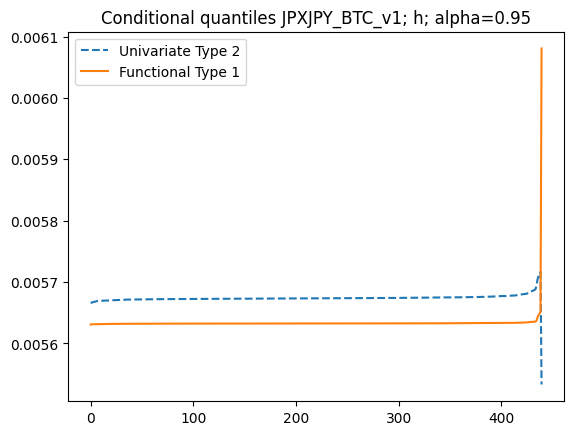

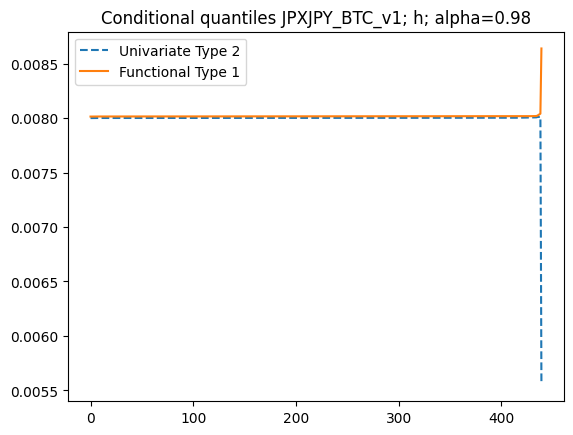

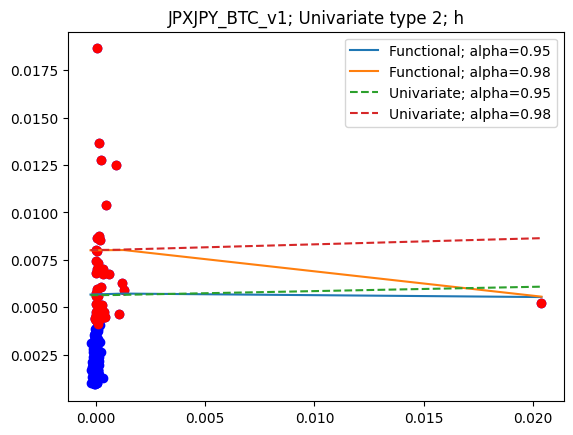

In [17]:
@numba.njit(parallel=True, fastmath=False) 
def plot_quantile_conditional_on_sample2(X,Y,dimred,covalues,x_func,alpha,h_vector,h_func_vector,kernel): 
    # X of shape (N,n,d) and Y of shape (N,n) with N=1;n=...;d=1440
    # covalues=np.dot(X_JPXJPY_BTC,E0_JPXJPY_BTC[0,:])/d   # shape = (N,n) = (1,431) family of (<X_i,dimred>)_{1\le i \le n} avec dimred \in H de taille (d,)=(1440)
    # dimred of shape (d,), e.g., dimred = E0[0,:] with E0 = fepls(X,Y,y_matrix,tau)
    # h_vector.shape = h_func_vector.shape = (n,)
    # Functional: X = x_func \in H; Univariate (type 2): <X,dimred>=covalues\in \R with covalues=<X_i,x_func> for 1 \le i \le n.   
    # x_func is a generical function/vector of shape (d,) and dimred is the FEPLS, i.e., E0[0,:] also of shape (d,)
    n=Y.shape[1]
    out = np.zeros((n,2))
    for p in numba.prange(n):
        weight2=univariate_Nadaraya_weight_2D(X[0,:,:],dimred,dimred,covalues[0,p],h_vector[p],2,kernel)
        weight_func=functional_Nadaraya_weight_2D(X[0,:,:],covalues[0,p]*dimred,h_func_vector[p],kernel)
        out[p,0]=weighted_quantile(Y[0,:],weight2,alpha)
        out[p,1]=weighted_quantile(Y[0,:],weight_func,alpha)
    return out

#########################

alpha1=0.95
alpha2=0.98
kernel=2 # Gaussian kernel
J=9

N=X_JPXJPY_BTC.shape[0]
n=X_JPXJPY_BTC.shape[1]
d=X_JPXJPY_BTC.shape[2]

##############################################################################
# Y|(X,dimred) = covalues (type univariate) vs Y|X = x_func (type functional)

dimred = E0_JPXJPY_BTC[0,:] # of shape (d,)
x_func = E0_JPXJPY_BTC[0,:] # of shape (d,)
covalues = np.sort(np.dot(X_JPXJPY_BTC,x_func)/d,axis=1)

##############################################################

H_grid=[0.004] #np.linspace(0.0002,0.004,51)

for h in H_grid:
    h_vector = h*np.ones((n,))
    h_func_vector = h*np.ones((n,))
    
    PP11_sample=plot_quantile_conditional_on_sample2(X_JPXJPY_BTC,Y_JPXJPY_BTC,dimred,covalues,x_func,alpha1,h_vector,h_func_vector,kernel) 
    PP12_sample=plot_quantile_conditional_on_sample2(X_JPXJPY_BTC,Y_JPXJPY_BTC,dimred,covalues,x_func,alpha2,h_vector,h_func_vector,kernel)
    print('The bandwidth h for the following plots is',h) 
    plt.plot(PP11_sample[:,0], linestyle='dashed', label='Univariate Type 2')
    plt.plot(PP11_sample[:,1], label='Functional Type 1')
    plt.legend()
    plt.title('Conditional quantiles JPXJPY_BTC_v1; h; alpha=0.95')
    plt.show()
    plt.plot(PP12_sample[:,0], linestyle='dashed', label='Univariate Type 2')
    plt.plot(PP12_sample[:,1],label='Functional Type 1')
    plt.legend()
    plt.title('Conditional quantiles JPXJPY_BTC_v1; h; alpha=0.98')
    plt.show()
    ###########################################################
    offset1=0
    offset2=0
    plt.scatter(F0_JPXJPY_BTC[0,:], Y_JPXJPY_BTC[0,:], color='blue', marker='o')
    highest_indices_JPXJPY_BTC = np.argsort(Y_JPXJPY_BTC)[0,-bti:]
    plt.scatter(F0_JPXJPY_BTC[0,highest_indices_JPXJPY_BTC], Y_JPXJPY_BTC[0,highest_indices_JPXJPY_BTC], color='red')
    plt.plot(np.sort(F0_JPXJPY_BTC[0,:])+offset1,  PP11_sample[:,1],  label='Functional; alpha=0.95')
    plt.plot(np.sort(F0_JPXJPY_BTC[0,:])+offset2,  PP12_sample[:,1],  label='Functional; alpha=0.98')
    plt.plot(np.sort(F0_JPXJPY_BTC[0,:])+offset1,  PP11_sample[:,0],  linestyle='dashed',label='Univariate; alpha=0.95')
    plt.plot(np.sort(F0_JPXJPY_BTC[0,:])+offset2,  PP12_sample[:,0],  linestyle='dashed',label='Univariate; alpha=0.98')
    #plt.xlim(-0.02, 0.03) 
    #plt.ylim(-0.01, 0.22) 
    plt.title('JPXJPY_BTC_v1')
    plt.legend()
    #plt.savefig('JPXJPY_BTC_Univariate_type2_h.pdf')  
    plt.show()

